<a href="https://colab.research.google.com/github/Flaiba/Coevolution_of_cooperative_lifestyles_and_reduced_cancer_prevalence_in_mammals/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python code for simulating Population Dynamics

This is the code for simulations and plotting of the Mathematical modeling presented in the paper "Coevolution of cooperative lifestyles and low cancer incidence in mammals" authored by Catalina Sierra, Julian Maxwell, Nicolás Flaibani, Constanza Sánchez de la Vega, Alejandra C. Ventura, Nicolás José Lavagnino and Matías Blaustein.

# Define functions for modeling populations, simulating models and plotting results

In [ ]:
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

## Functions

In [ ]:
def frame(param_tuple):
  """
Creates a parameters DataFrame from a tuple.
Must respect given order (see code).
  """
  param_keys = ('$π$', '$ρ$',
               '$κ_{JA1}$', '$κ_{JS1}$', '$κ_{A1}$', '$κ_{S1}$',
               '$α_1$', '$ω_1$', '$β_{A1}$', '$β_{S1}$', '$γ_{A1}$', '$γ_{S1}$', '$σ_1$',
               '$μ_{JA1}$', '$μ_{JS1}$', '$μ_{A1}$', '$μ_{S1}$',
               '$κ_{JA2}$', '$κ_{JS2}$', '$κ_{A2}$', '$κ_{S2}$',
               '$α_2$', '$ω_2$', '$β_{A2}$', '$β_{S2}$', '$γ_{A2}$', '$γ_{S2}$', '$σ_2$',
               '$μ_{JA2}$', '$μ_{JS2}$', '$μ_{A2}$', '$μ_{S2}$')
  dict_param = dict(map(lambda i,j : (i,j) , param_keys, param_tuple))
  param_df = pd.Series(dict_param, dict_param.keys())

  return param_df


In [ ]:
def sol_odeint_df(system, init_cond: list, parameters: tuple, t_fin: float, dt:float, t_ini: float = 0) -> pd.DataFrame:
  """
  Returns 3 DataFrames:
  Simulated Dynamics from time integration by scipy's odeint
  Input parameters
  Input initial values
  """
  t=np.arange(t_ini, t_fin, dt)
  sol = odeint(system, init_cond, t, args = (parameters))


# creates a DataFrame for time course data
  labels = ['R(t)', 'J_A1(t)', 'J_S1(t)', 'A1(t)', 'S1(t)', 'J_A2(t)', 'J_S2(t)', 'A2(t)', 'S2(t)']
  sol_df = pd.DataFrame(data=sol, index=t, columns = labels)

#creates a DataFrame for input parameter values used for simulation
  param_df = frame(parameters)

#creates a DataFrame for input Initial Conditions
  InCond_df = sol_df.iloc[0, :]

  return sol_df, param_df, InCond_df

In [ ]:
def expand_df(sol01: pd.DataFrame, full=False):
  """
  Adds further columns to input DataFrame.
  """
  # size of subpopulation 1
  sol01['N1(t)'] = sol01.iloc[:,[1,2,3,4]].sum(1)
  # size of subpopulation 2
  sol01['N2(t)'] = sol01.iloc[:,[5,6,7,8]].sum(1)
  # total consumer population size
  sol01['N(t)'] = sol01.iloc[:,[9,10]].sum(1)
  #fraction of each subpopulation over total consumer population
  sol01[['n1(t)', 'n2(t)']] = sol01[['N1(t)','N2(t)']].div(sol01['N(t)'], axis=0)

  if full == True:

    #sum of adult-born juveniles from both subpopulations
    sol01['J_A(t)']= sol01[['J_A1(t)', 'J_A2(t)']].sum(1)
    #sum of senior-born juveniles from both subpopulations
    sol01['J_S(t)']= sol01[['J_S1(t)', 'J_S2(t)']].sum(1)
    #sum of kinds of juveniles from the same subpopulation (1)
    sol01['J1(t)'] = sol01.iloc[:,[1,2]].sum(1)
    #sum of kinds of juveniles from the same subpopulation (2)
    sol01['J2(t)'] = sol01.iloc[:,[5,6]].sum(1)
    #all juveniles (regardless of origin) summed
    sol01['J(t)']  = sol01[['J_A(t)', 'J_S(t)']].sum(1)
    # sum of all adults in metapopulation
    sol01['A(t)']  = sol01[['A1(t)', 'A2(t)']].sum(1)
    # sum of all seniors in metapopulation
    sol01['S(t)']  = sol01[['S1(t)', 'S2(t)']].sum(1)

    #fraction of adults to total size in a single subpopulation (1)
    sol01['a1(t)'] = sol01['A1(t)'].div(sol01['N1(t)'], axis=0)
    #fraction of adults to total size in a single subpopulation (2)
    sol01['a2(t)'] = sol01['A2(t)'].div(sol01['N2(t)'], axis=0)
    #fraction of all adults in total metapopulation
    sol01['a(t)']  = sol01['A(t)'].div(sol01['N(t)'], axis=0)


  return sol01

In [ ]:
def mean_df(sol01: pd.DataFrame):
  """
  Calculates the mean value for last fifth of simulated time.
  Useful to compare to the last value of simulation.
  """
  df1 = pd.DataFrame(sol01.iloc[-len(sol01)//5:,:].mean(0)).T
  df1.index=['mean']

  return df1

In [ ]:
def function(system, start, end, step, param = tuple([0]*29), init_cond = [0]*9,
             t_fin = 0, dt = 0, control1='$μ_{S1}$', control2='$μ_{S1}$', full = True):
  """
  This function returns 2 lists (one of floats, another one of dictionaries)
  from the following input parameters

  System: must be a defined model (MetaPopX)

  (np.arange parameters)
  start: Lower bound for control parameter range
  end: Upper bound for control parameter range (not included)
  step: step of the control parameter range

  param: of paramater set values for system
  init_cond: list of initial values for system state variables

  t_fin: end time of simulation (total time)
  dt: time step for time course returned

  control1: keyword for selected control parameter
  control2: keyword for additonal control parameter

  full: False to get less information

  Floats in fifrst list are the control variables values
  in the order used for simulations.
  Dictonaries in second list provide all the information
  from the multiple simulations ran by this function.
  """
  mu_s_array=[]
  dict_sol_array = []

  for i in np.arange(start, end, step):
  # for i in np.linspace(start, end, step): #alternative
    i = round(i, 2)
    param[control1]=i
    param[control2]=i
    #uses sol_odeint_df to create 3 dataframes:
    #time course, input parameters and input initial values
    sol, param, Init_Cond = sol_odeint_df(system, list(init_cond[0:9]),
                                          tuple(param), t_fin=t_fin, dt=dt)
    expand_df(sol, full) #expands the dataframe for additional information
    #adds to the ouput list all data of current simulation in dictioanary form
    dict_sol_array.append({'control_name1': control1, 'control_name2': control2,
                           'parameter_value1': i, 'parameter_value2': i,
                           'last_value': sol.iloc[-1, :], 'mean_value': mean_df(sol),
                           'dynamics': sol, 'params': param, 'Init_Cond': Init_Cond})
    mu_s_array.append(i)

    # i+=step

  return mu_s_array, dict_sol_array


## Systems of Equations

The following systems of ODE are 4 versions of the same model. Variation can be found in the location of the cooperative/competitive term, herein refered to as the $ h $ function.

$$
h = \frac{(1 + \alpha_1 S_1 + \alpha_2 S_2)(1 + \rho R^2)}{{1 + (\omega_1 S_1 + \omega_2 S_2)}}
$$

These models are used for simulating populations in *Modeling cancer and population size* subsection of the paper's Results section and also in the *Extended Data Figures* of the Supplementary Information.

All systems of equations have an unstructered *Resource* dynamics equation and 2 "copies" of the structured *Consumer* population dynamics. This allows us to show the time evolution of a meta-population composed of two subpopulations (with two different sets of life history parameter values) competing for a common pool of resources (*Resource* population). When considering a single population, same initial conditions and parameter values are selected for both "subpopulations".

Additionally, in these models there 2 kinds of Juveniles in each *Consumer* population, those that are born from *Adults* (`J_A1` and `J_A2`), and those that are born from *Senior* adults (`J_S1` and `J_S2`).



In [ ]:
def MetaPopA(V: list,
             t,
             p, r,
             kja1, kjs1, ka1, ks1, a1, w1, ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1,
             kja2, kjs2, ka2, ks2, a2, w2, ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2) -> list:
    """
Model based on Extended Data Eqs. 4a-d. Here cooperativity/competition function is affecting Juvenile mortality.
This funtion should use the same set of parameters for both subpopulations (1 and 2) if it is simulating a single population.
This function receives an initial state for the system variables V in list form.
It returns the rate of change of the system variables in list form.

Except for V = [Ri, J_A1i, ..., S2i], every other input should be of type float.
    """
    R = V[0]
    J_A1 = V[1]
    J_S1 = V[2]
    A1 = V[3]
    S1 = V[4]
    J_A2 = V[5]
    J_S2 = V[6]
    A2 = V[7]
    S2 = V[8]

    h = (1 + a1*S1 + a2*S2)/(1 + (w1*S1 + w2*S2)/(1 + r*(R**2)))

    dRdt = p - kja1*R*J_A1 + kjs1*R*J_S1 - ka1*R*A1 - ks1*R*S1 - kja2*R*J_A2 + kjs2*R*J_S2 - ka2*R*A2 - ks2*R*S2

    dJ_A1dt = (ba1*(ka1*R))*A1 - (ga1*(kja1*R))*J_A1 - (mja1)*J_A1/h
    dJ_S1dt = (bs1*(ks1*R))*S1 - (gs1*(kjs1*R))*J_S1 - (mjs1)*J_S1/h
    dA1dt = (ga1*(kja1*R))*J_A1 + (gs1*(kjs1*R))*J_S1 - s1*A1 - ma1*A1
    dS1dt = s1*A1 - ms1*S1

    dJ_A2dt = (ba2*(ka2*R))*A2 - (ga2*(kja2*R))*J_A2 - (mja2)*J_A2/h
    dJ_S2dt = (bs2*(ks2*R))*S2 - (gs2*(kjs2*R))*J_S2 - (mjs2)*J_S2/h
    dA2dt = (ga2*(kja2*R))*J_A2 + (gs2*(kjs2*R))*J_S2 - s2*A2 - ma2*A2
    dS2dt = s2*A2 - ms2*S2

    return [dRdt, dJ_A1dt, dJ_S1dt, dA1dt, dS1dt, dJ_A2dt, dJ_S2dt, dA2dt, dS2dt]


In [ ]:
def MetaPopB(V: list,
             t,
             p, r,
             kja1, kjs1, ka1, ks1, a1, w1, ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1,
             kja2, kjs2, ka2, ks2, a2, w2, ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2):
    """
Model based on Extended Data Eqs. E1a-d. Here cooperativity/competition function is affecting Juvenile foraging.
This funtion should use the same set of parameters for both subpopulations (1 and 2) if it is simulating a single population.
This function receives an initial state for the system variables V in list form.
It returns the rate of change of the system variables in list form.

Except for V = [Ri, J_A1i, ..., S2i], every other input should be of type float.
    """
    R = V[0]
    J_A1 = V[1]
    J_S1 = V[2]
    A1 = V[3]
    S1 = V[4]
    J_A2 = V[5]
    J_S2 = V[6]
    A2 = V[7]
    S2 = V[8]

    h = (1 + a1*S1 + a2*S2)/(1 + (w1*S1 + w2*S2)/(1 + r*(R**2)))

    dRdt = p - ((kja1*h)*R*J_A1)+ ((kjs1*h)*R*J_S1) - ka1*R*A1 - ks1*R*S1 - ((kja2*h)*R*J_A2) + ((kjs2*h)*R*J_S2) - ka2*R*A2 - ks2*R*S2

    dJ_A1dt = (ba1*(ka1*R))*A1 - (ga1*((kja1*h)*R))*J_A1 - (mja1)*J_A1
    dJ_S1dt = (bs1*(ks1*R))*S1 - (gs1*((kjs1*h)*R))*J_S1 - (mjs1)*J_S1
    dA1dt = (ga1*((kja1*h)*R))*J_A1 + (gs1*((kjs1*h)*R))*J_S1 - s1*A1 - ma1*A1
    dS1dt = s1*A1 - ms1*S1

    dJ_A2dt = (ba2*(ka2*R))*A2 - (ga2*((kja2*h)*R))*J_A2 - (mja2)*J_A2
    dJ_S2dt = (bs2*(ks2*R))*S2 - (gs2*((kjs2*h)*R))*J_S2 - (mjs2)*J_S2
    dA2dt = (ga2*((kja2*h)*R))*J_A2 + (gs2*((kjs2*h)*R))*J_S2 - s2*A2 - ma2*A2
    dS2dt = s2*A2 - ms2*S2

    return [dRdt, dJ_A1dt, dJ_S1dt, dA1dt, dS1dt, dJ_A2dt, dJ_S2dt, dA2dt, dS2dt]


In [ ]:
def MetaPopC(V: list,
             t,
             p, r,
             kja1, kjs1, ka1, ks1, a1, w1, ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1,
             kja2, kjs2, ka2, ks2, a2, w2, ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2):
    """
Model based on Extended Data Eqs. E2a-d. Here cooperativity/competition function is affecting Juvenile to Adult maturation.
This funtion should use the same set of parameters for both subpopulations (1 and 2) if it is simulating a single population.
This function receives an initial state for the system variables V in list form.
It returns the rate of change of the system variables in list form.

Except for V = [Ri, J_A1i, ..., S2i], every other input should be of type float.
    """
    R = V[0]
    J_A1 = V[1]
    J_S1 = V[2]
    A1 = V[3]
    S1 = V[4]
    J_A2 = V[5]
    J_S2 = V[6]
    A2 = V[7]
    S2 = V[8]

    h = (1 + a1*S1 + a2*S2)/(1 + (w1*S1 + w2*S2)/(1 + r*(R**2)))

    dRdt = p - kja1*R*J_A1 + kjs1*R*J_S1 - ka1*R*A1 - ks1*R*S1 - kja2*R*J_A2 + kjs2*R*J_S2 - ka2*R*A2 - ks2*R*S2

    dJ_A1dt = (ba1*(ka1*R))*A1 - ((ga1*h)*(kja1*R))*J_A1 - (mja1)*J_A1
    dJ_S1dt = (bs1*(ks1*R))*S1 - ((gs1*h)*(kjs1*R))*J_S1 - (mjs1)*J_S1
    dA1dt = ((ga1*h)*(kja1*R))*J_A1 + ((gs1*h)*(kjs1*R))*J_S1 - s1*A1 - ma1*A1
    dS1dt = s1*A1 - ms1*S1

    dJ_A2dt = (ba2*(ka2*R))*A2 - ((ga2*h)*(kja2*R))*J_A2 - (mja2)*J_A2
    dJ_S2dt = (bs2*(ks2*R))*S2 - ((gs2*h)*(kjs2*R))*J_S2 - (mjs2)*J_S2
    dA2dt = ((ga2*h)*(kja2*R))*J_A2 + ((gs2*h)*(kjs2*R))*J_S2 - s2*A2 - ma2*A2
    dS2dt = s2*A2 - ms2*S2

    return [dRdt, dJ_A1dt, dJ_S1dt, dA1dt, dS1dt, dJ_A2dt, dJ_S2dt, dA2dt, dS2dt]


In [ ]:
def MetaPopD(V: list,
             t,
             p, r,
             kja1, kjs1, ka1, ks1, a1, w1, ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1,
             kja2, kjs2, ka2, ks2, a2, w2, ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2):
    """
Model based on Extended Data Eqs. E3a-d. Here cooperativity/competition function is affecting Adult and Senior fertility.
This funtion should use the same set of parameters for both subpopulations (1 and 2) if it is simulating a single population.
This function receives an initial state for the system variables V in list form.
It returns the rate of change of the system variables in list form.

Except for V = [Ri, J_A1i, ..., S2i], every other input should be of type float.
    """
    R = V[0]
    J_A1 = V[1]
    J_S1 = V[2]
    A1 = V[3]
    S1 = V[4]
    J_A2 = V[5]
    J_S2 = V[6]
    A2 = V[7]
    S2 = V[8]

    h = (1 + a1*S1 + a2*S2)/(1 + (w1*S1 + w2*S2)/(1 + r*(R**2)))

    dRdt = p - kja1*R*J_A1 + kjs1*R*J_S1 - ka1*R*A1 - ks1*R*S1 - kja2*R*J_A2 + kjs2*R*J_S2 - ka2*R*A2 - ks2*R*S2

    dJ_A1dt = ((ba1*h)*(ka1*R))*A1 - (ga1*(kja1*R))*J_A1 - (mja1)*J_A1
    dJ_S1dt = ((bs1*h)*(ks1*R))*S1 - (gs1*(kjs1*R))*J_S1 - (mjs1)*J_S1
    dA1dt = (ga1*(kja1*R))*J_A1 + (gs1*(kjs1*R))*J_S1 - s1*A1 - ma1*A1
    dS1dt = s1*A1 - ms1*S1

    dJ_A2dt = ((ba2*h)*(ka2*R))*A2 - (ga2*(kja2*R))*J_A2 - (mja2)*J_A2
    dJ_S2dt = ((bs2*h)*(ks2*R))*S2 - (gs2*(kjs2*R))*J_S2 - (mjs2)*J_S2
    dA2dt = (ga2*(kja2*R))*J_A2 + (gs2*(kjs2*R))*J_S2 - s2*A2 - ma2*A2
    dS2dt = s2*A2 - ms2*S2

    return [dRdt, dJ_A1dt, dJ_S1dt, dA1dt, dS1dt, dJ_A2dt, dJ_S2dt, dA2dt, dS2dt]


# Results

## Fig. 4B

Time course for the sum of population stages (color-coded). In pink vertical line there is a single immediate value change for "senior mortality" parameter (jumps from 1.5 to 2.5)

In [ ]:
# Init_Cond = [2.893384, 0.229396, 0.000000, 0.078086, 0.416458, 0.229396, 0.000000, 0.078086, 0.416458]

# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 9.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 1.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

Text(0, 0.5, 'Population Area Density [A.U.]')

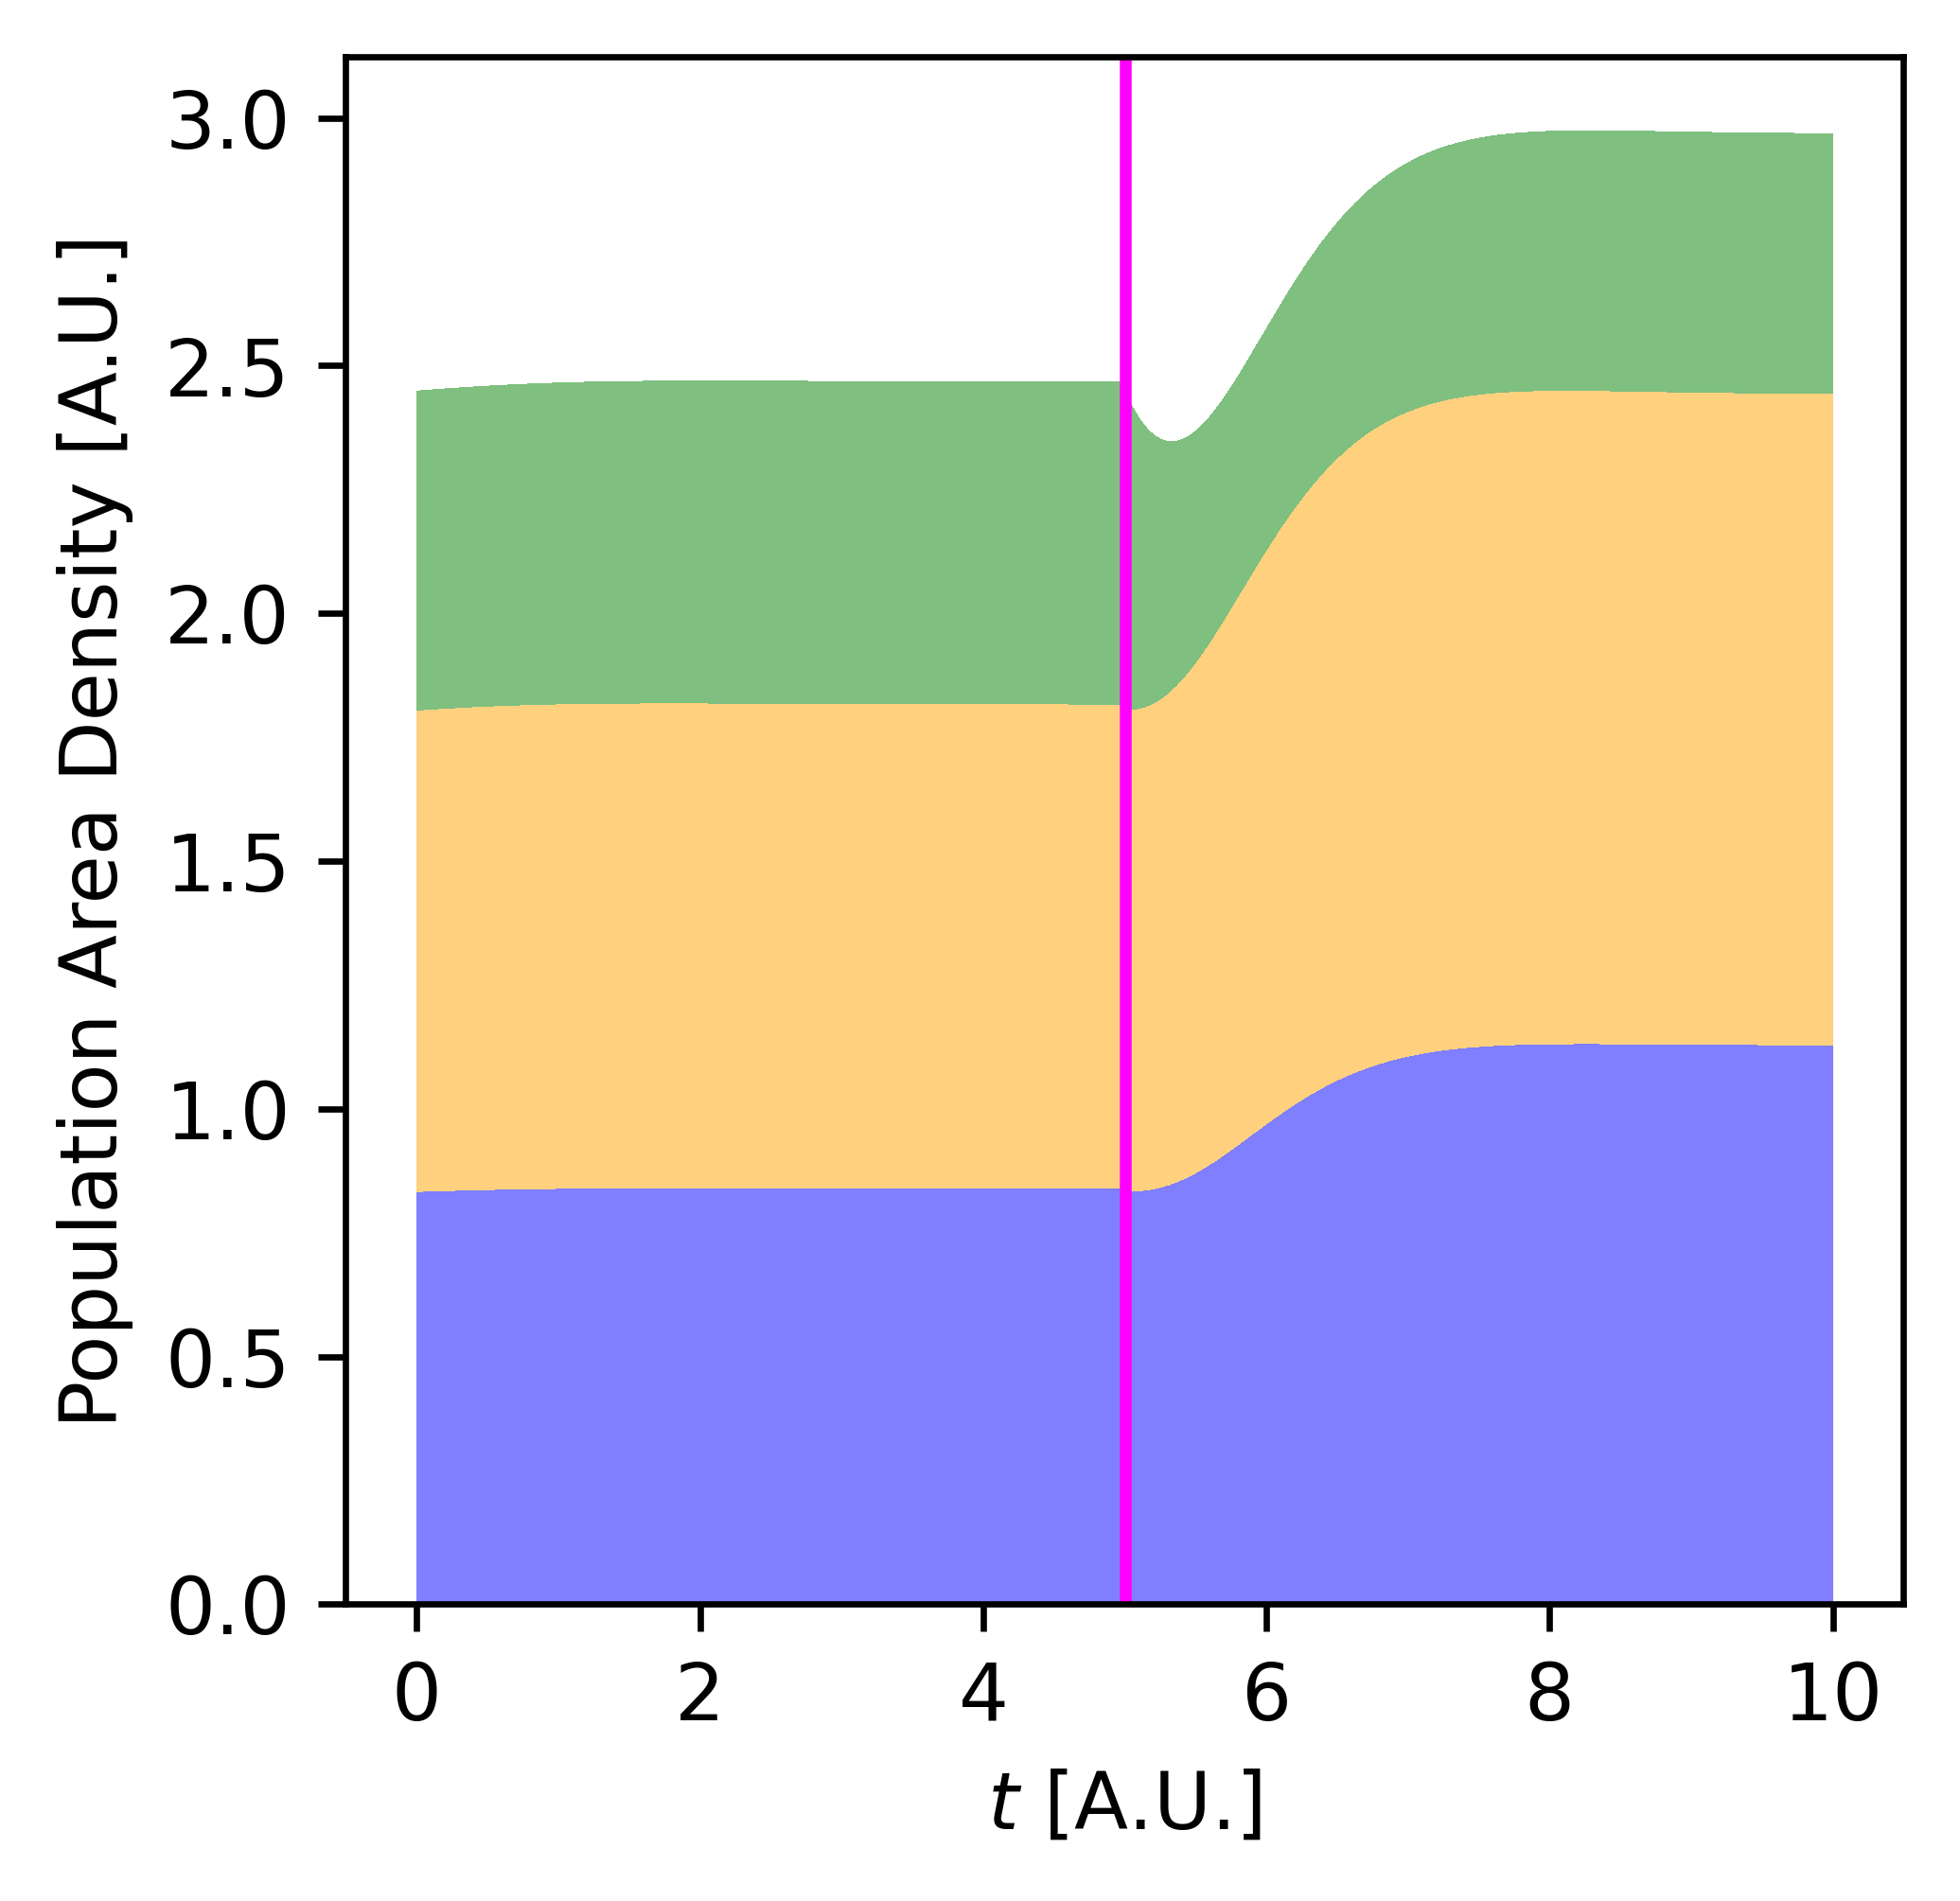

In [ ]:
# First integration to get to equilibrium from some set ot initial values
param['$μ_{S1}$'] = 1.5
param['$μ_{S2}$'] = 1.5
sol98 = sol_odeint_df(system = MetaPopA, init_cond = init_values,
                      parameters = tuple(param), t_fin = t_fin, dt = dt)
# Set initial conditions to previous simualation steady-state
init_values = list(sol98[0].iloc[-1][['R(t)', 'J_A1(t)', 'J_S1(t)', 'A1(t)', 'S1(t)', 'J_A2(t)', 'J_S2(t)', 'A2(t)', 'S2(t)']])
# Second integration starting from equilibirum conditions
sol98 = sol_odeint_df(system = MetaPopA, init_cond = init_values,
                      parameters = tuple(param), t_fin = t_fin, dt = dt)
expand_df(sol98[0], full= True)
#Second time evolution starting from senior mortality increase
param['$μ_{S1}$'] = 2.5
param['$μ_{S2}$'] = 2.5
sol99 = sol_odeint_df(system = MetaPopA, init_cond = init_values,
                      parameters = tuple(param), t_fin = t_fin*2.0, dt = dt/5, t_ini = t_fin)
expand_df(sol99[0], full= True)
#Plot stage-structured population evolution in time (before and after mortality increase)
fig4b  = plt.figure(figsize=(3.54,3.54), dpi=600)
ax1 = fig4b.add_subplot()

ax1.bar(sol98[0].index, sol98[0]['J_A(t)'], width=dt, bottom=0, label='$J$', color='blue', alpha=0.5, hatch='')
ax1.bar(sol98[0].index, sol98[0]['A(t)'], width=dt, bottom=sol98[0]['J_A(t)'], label='$A$', color='orange', alpha=0.5, hatch='')
ax1.bar(sol98[0].index, sol98[0]['S(t)'], width=dt, bottom=[j + a for j, a in zip(sol98[0]['J_A(t)'], sol98[0]['A(t)'])], label='$S$', color='green', alpha=0.5, hatch='')

ax1.bar(sol99[0].index, sol99[0]['J_A(t)'], width=dt/5, bottom=0, color='blue', alpha=0.5, hatch='')
ax1.bar(sol99[0].index, sol99[0]['A(t)'], width=dt/5, bottom=sol99[0]['J_A(t)'], color='orange', alpha=0.5, hatch='')
ax1.bar(sol99[0].index, sol99[0]['S(t)'], width=dt/5, bottom=[j + a for j, a in zip(sol99[0]['J_A(t)'], sol99[0]['A(t)'])], color='green', alpha=0.5, hatch='')

ax1.axvline(t_fin, label='$μ_{S}$ increase', color = 'magenta')

# ax1.plot(x, N, label='$N_T$', color = 'k', linewidth=2.5)

ax1.set_xlabel(r'$t$ [A.U.]')
ax1.set_ylabel('Population Area Density [A.U.]')
# ax1.legend()
# ax1.grid()

## Fig. 4c

Here we show how population equilibrium depends of parameters "adult fertilty" and "senior mortality". Increasing lines show hydra effect. Decreasing lines show anti-hydra (intuitively expected response). Unchanging line would be neither one nor the other.

Higher Reproductive Efficiencies in Adults ($β_A, where\ g_A(x) = β_A x$) allow and potentiate the hydra effect.


In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 2.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 1.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 1.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 1.0, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 0.1
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$β_{A1}$'] = 0.1
param['$β_{A2}$'] = 0.1
mu_range, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$β_{A1}$'] = 1.0
param['$β_{A2}$'] = 1.0
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$β_{A1}$'] = 5.0
param['$β_{A2}$'] = 5.0
_, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

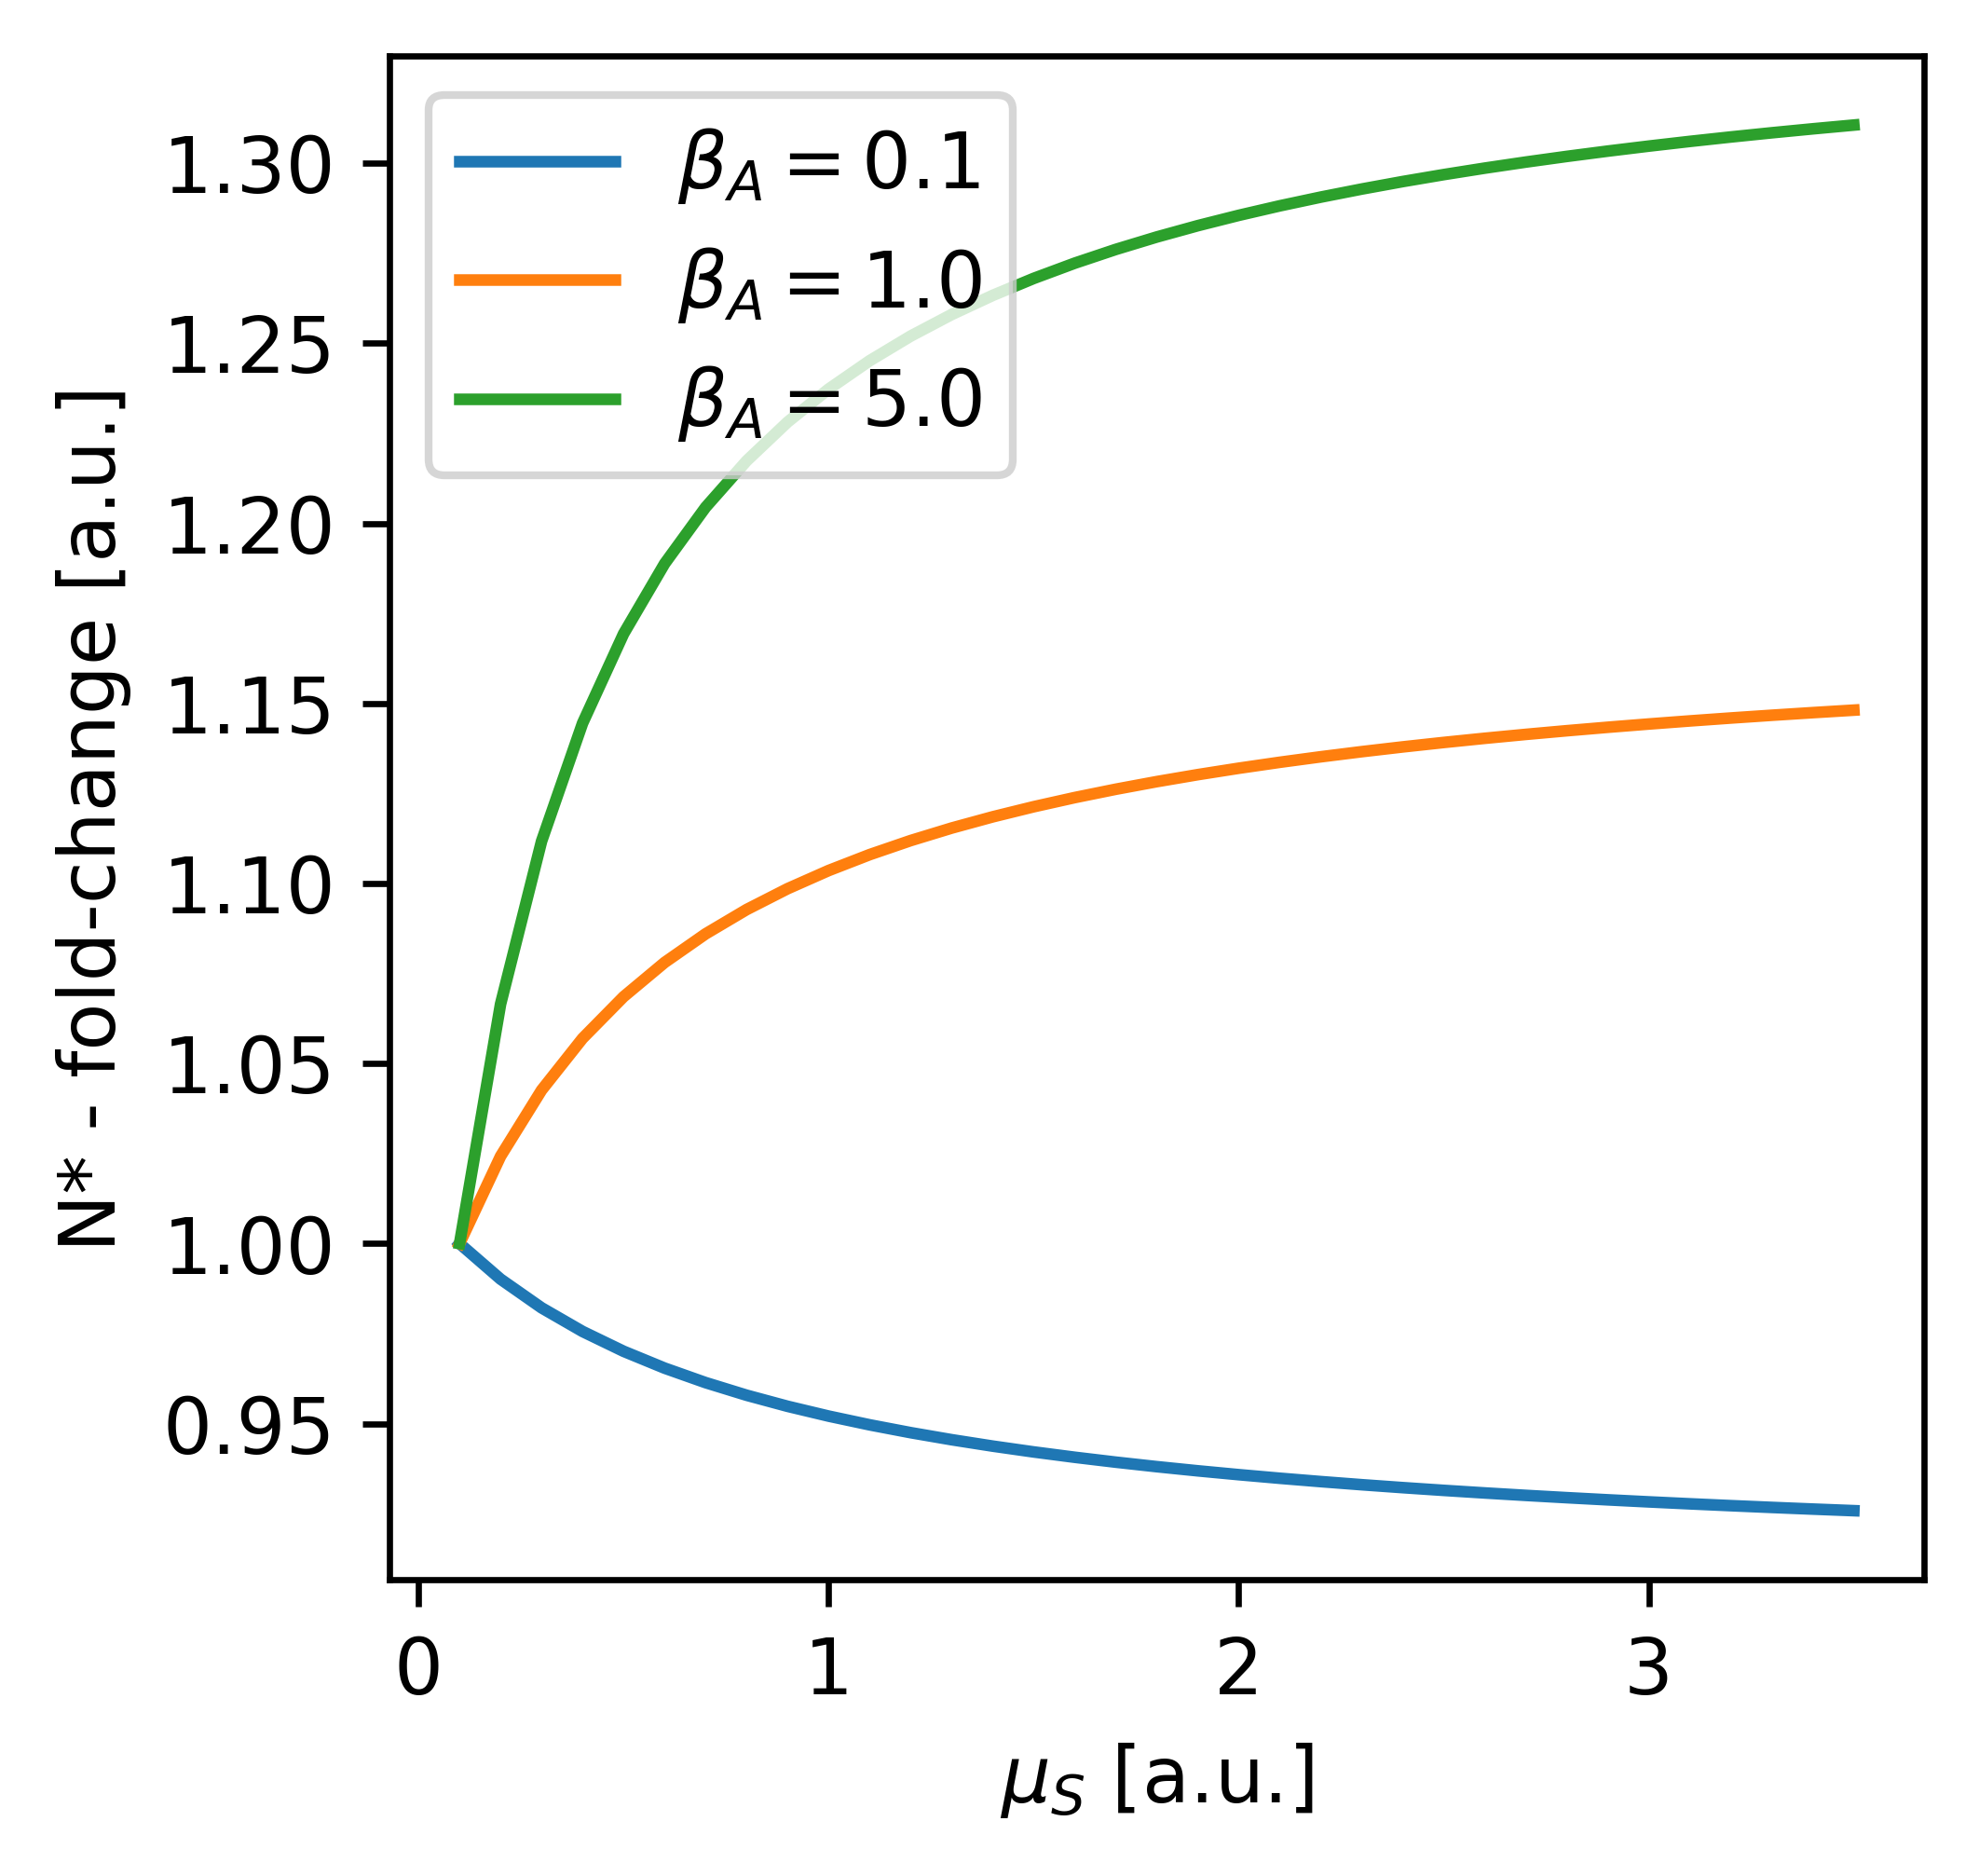

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$β_A = 0.1$')
dores.plot(mu_range, R_series, label='$β_A = 1.0$')
dores.plot(mu_range, G_series, label='$β_A = 5.0$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

## Fig. 4d

 The hydra effect is overturned with increasing caring interactions by older individuals ($α$).

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 1.5, 1.5 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 10.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 1.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 2.0, 0.0 # mortality rates for both types of juveniles
ma1 = 2.0 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 0.5
end_mu = 10.6
step_mu = 0.1


In [ ]:
param['$α_1$'] = 0
param['$α_2$'] = 0
mu_range, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$α_1$'] = 0.5
param['$α_2$'] = 0.5
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$α_1$'] = 1.0
param['$α_2$'] = 1.0
_, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

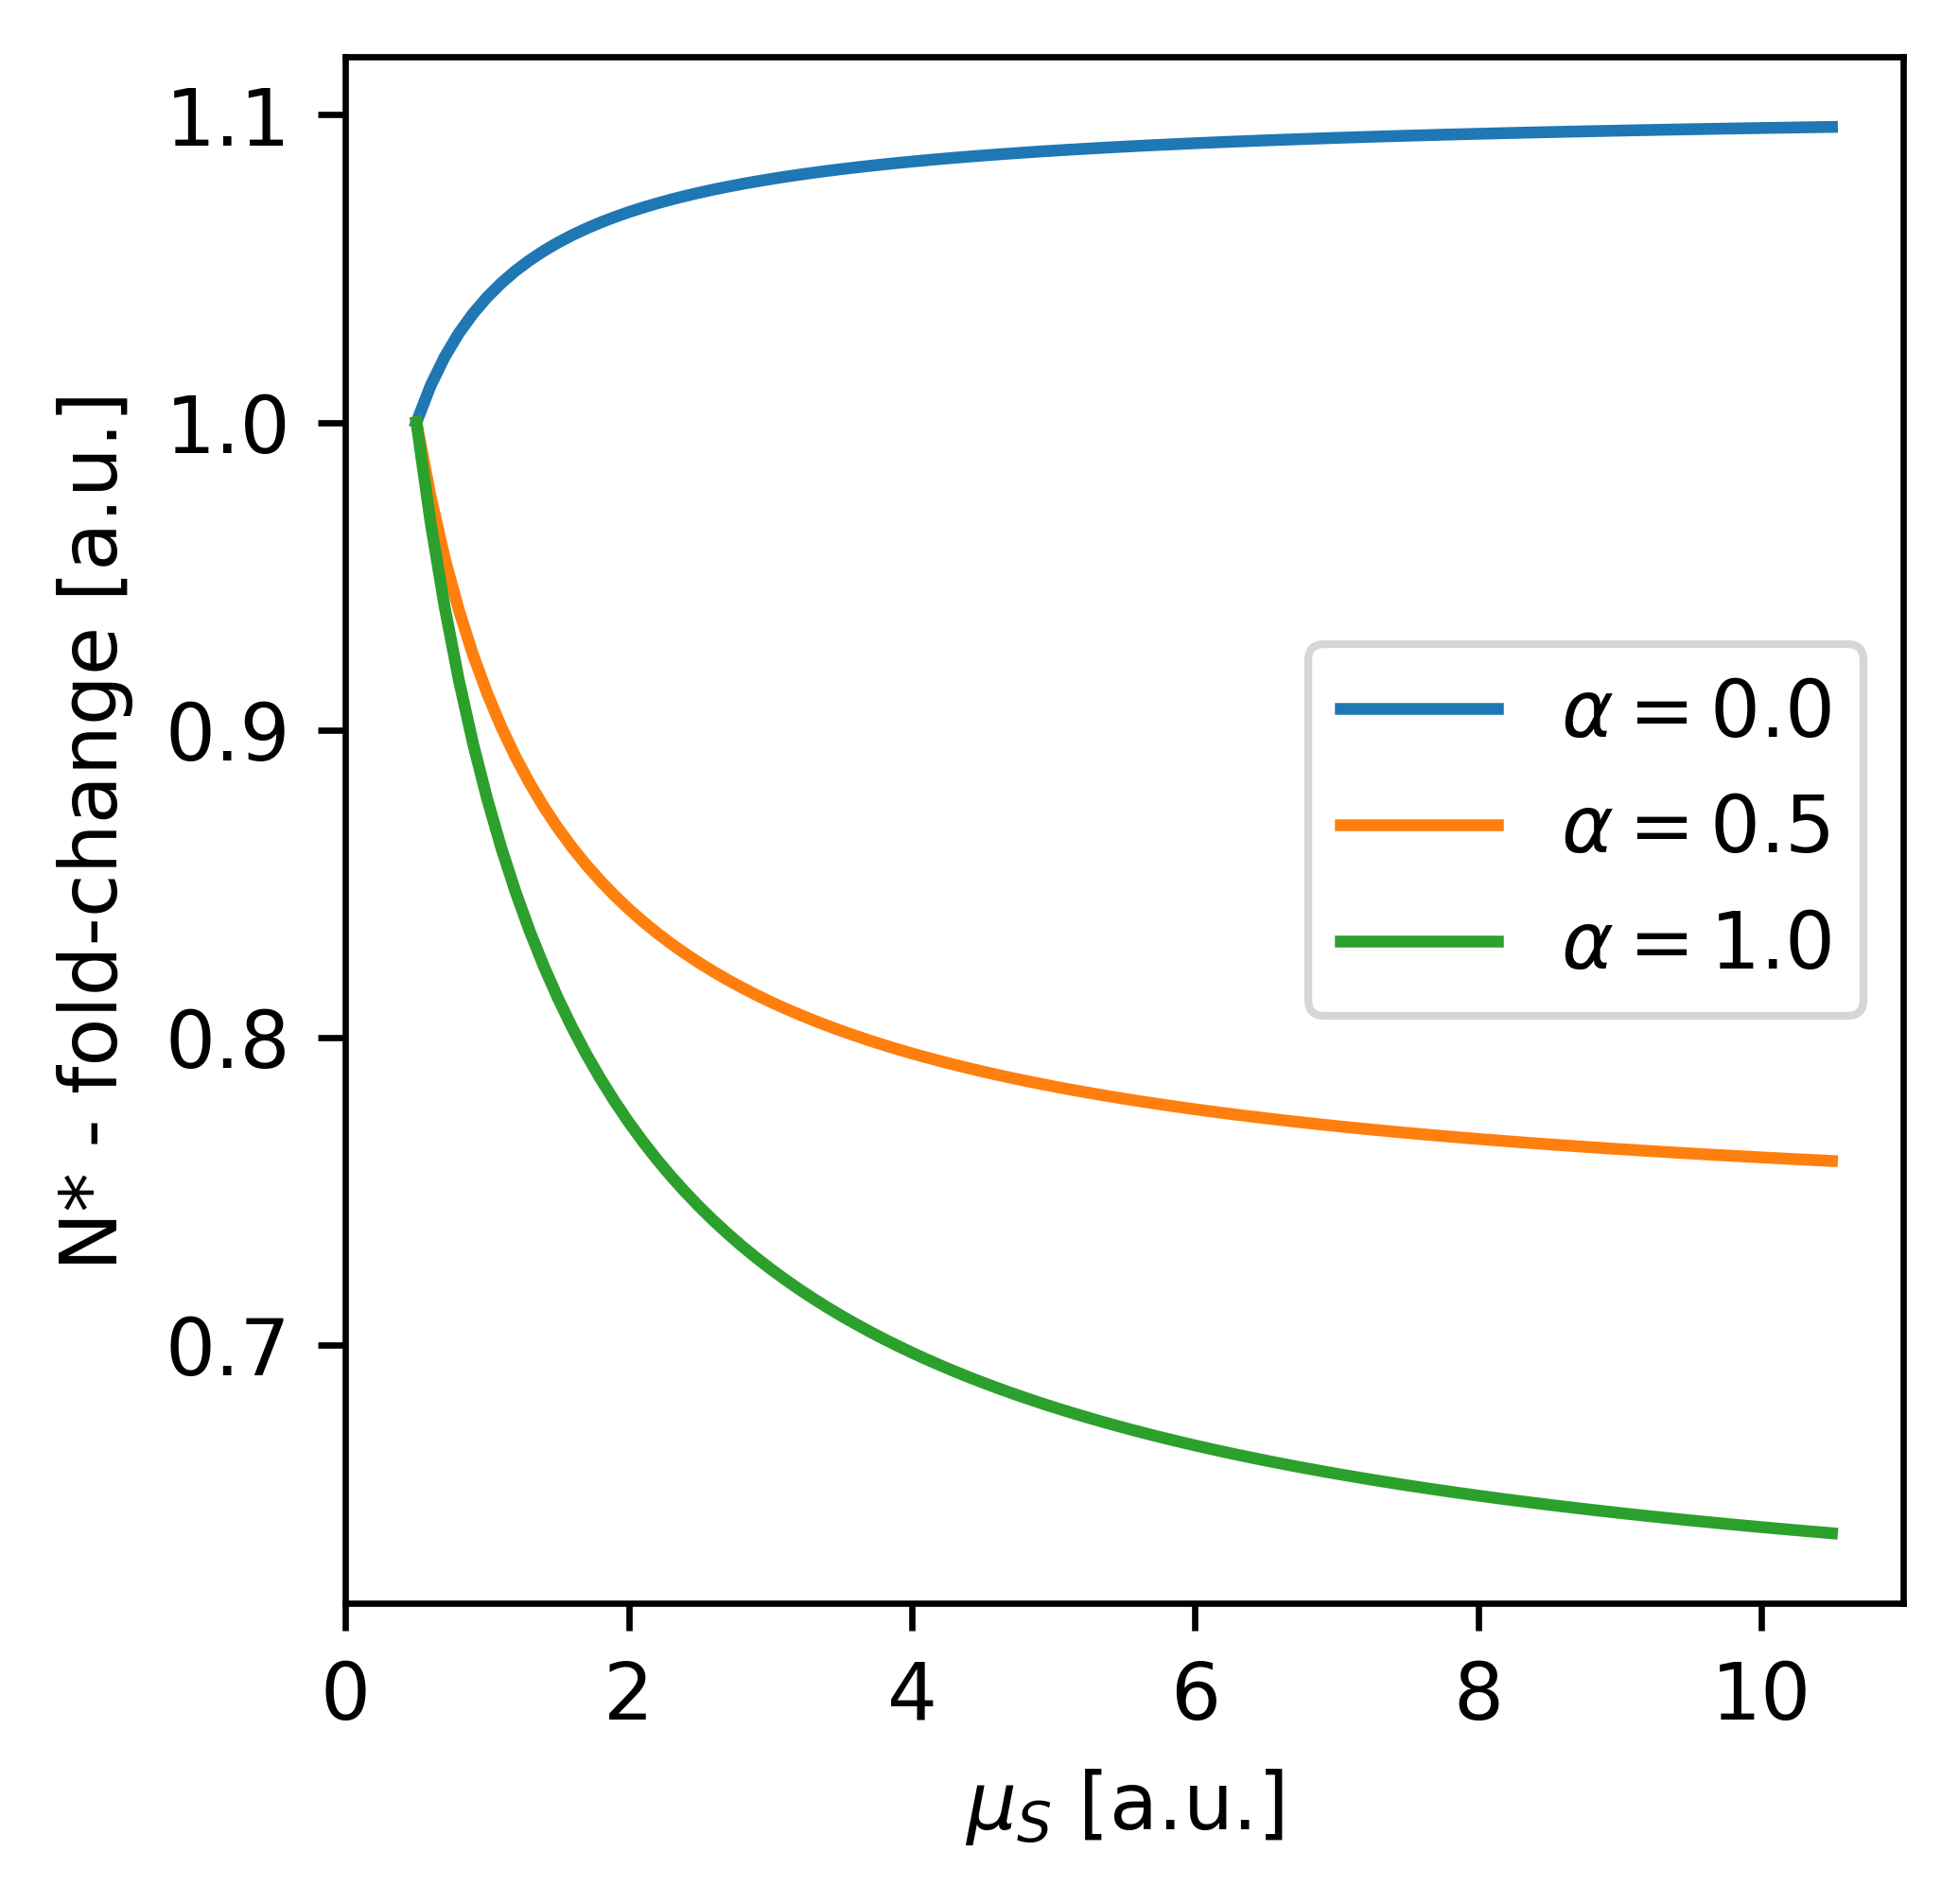

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$α = 0.0$')
dores.plot(mu_range, R_series, label='$α = 0.5$')
dores.plot(mu_range, G_series, label='$α = 1.0$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

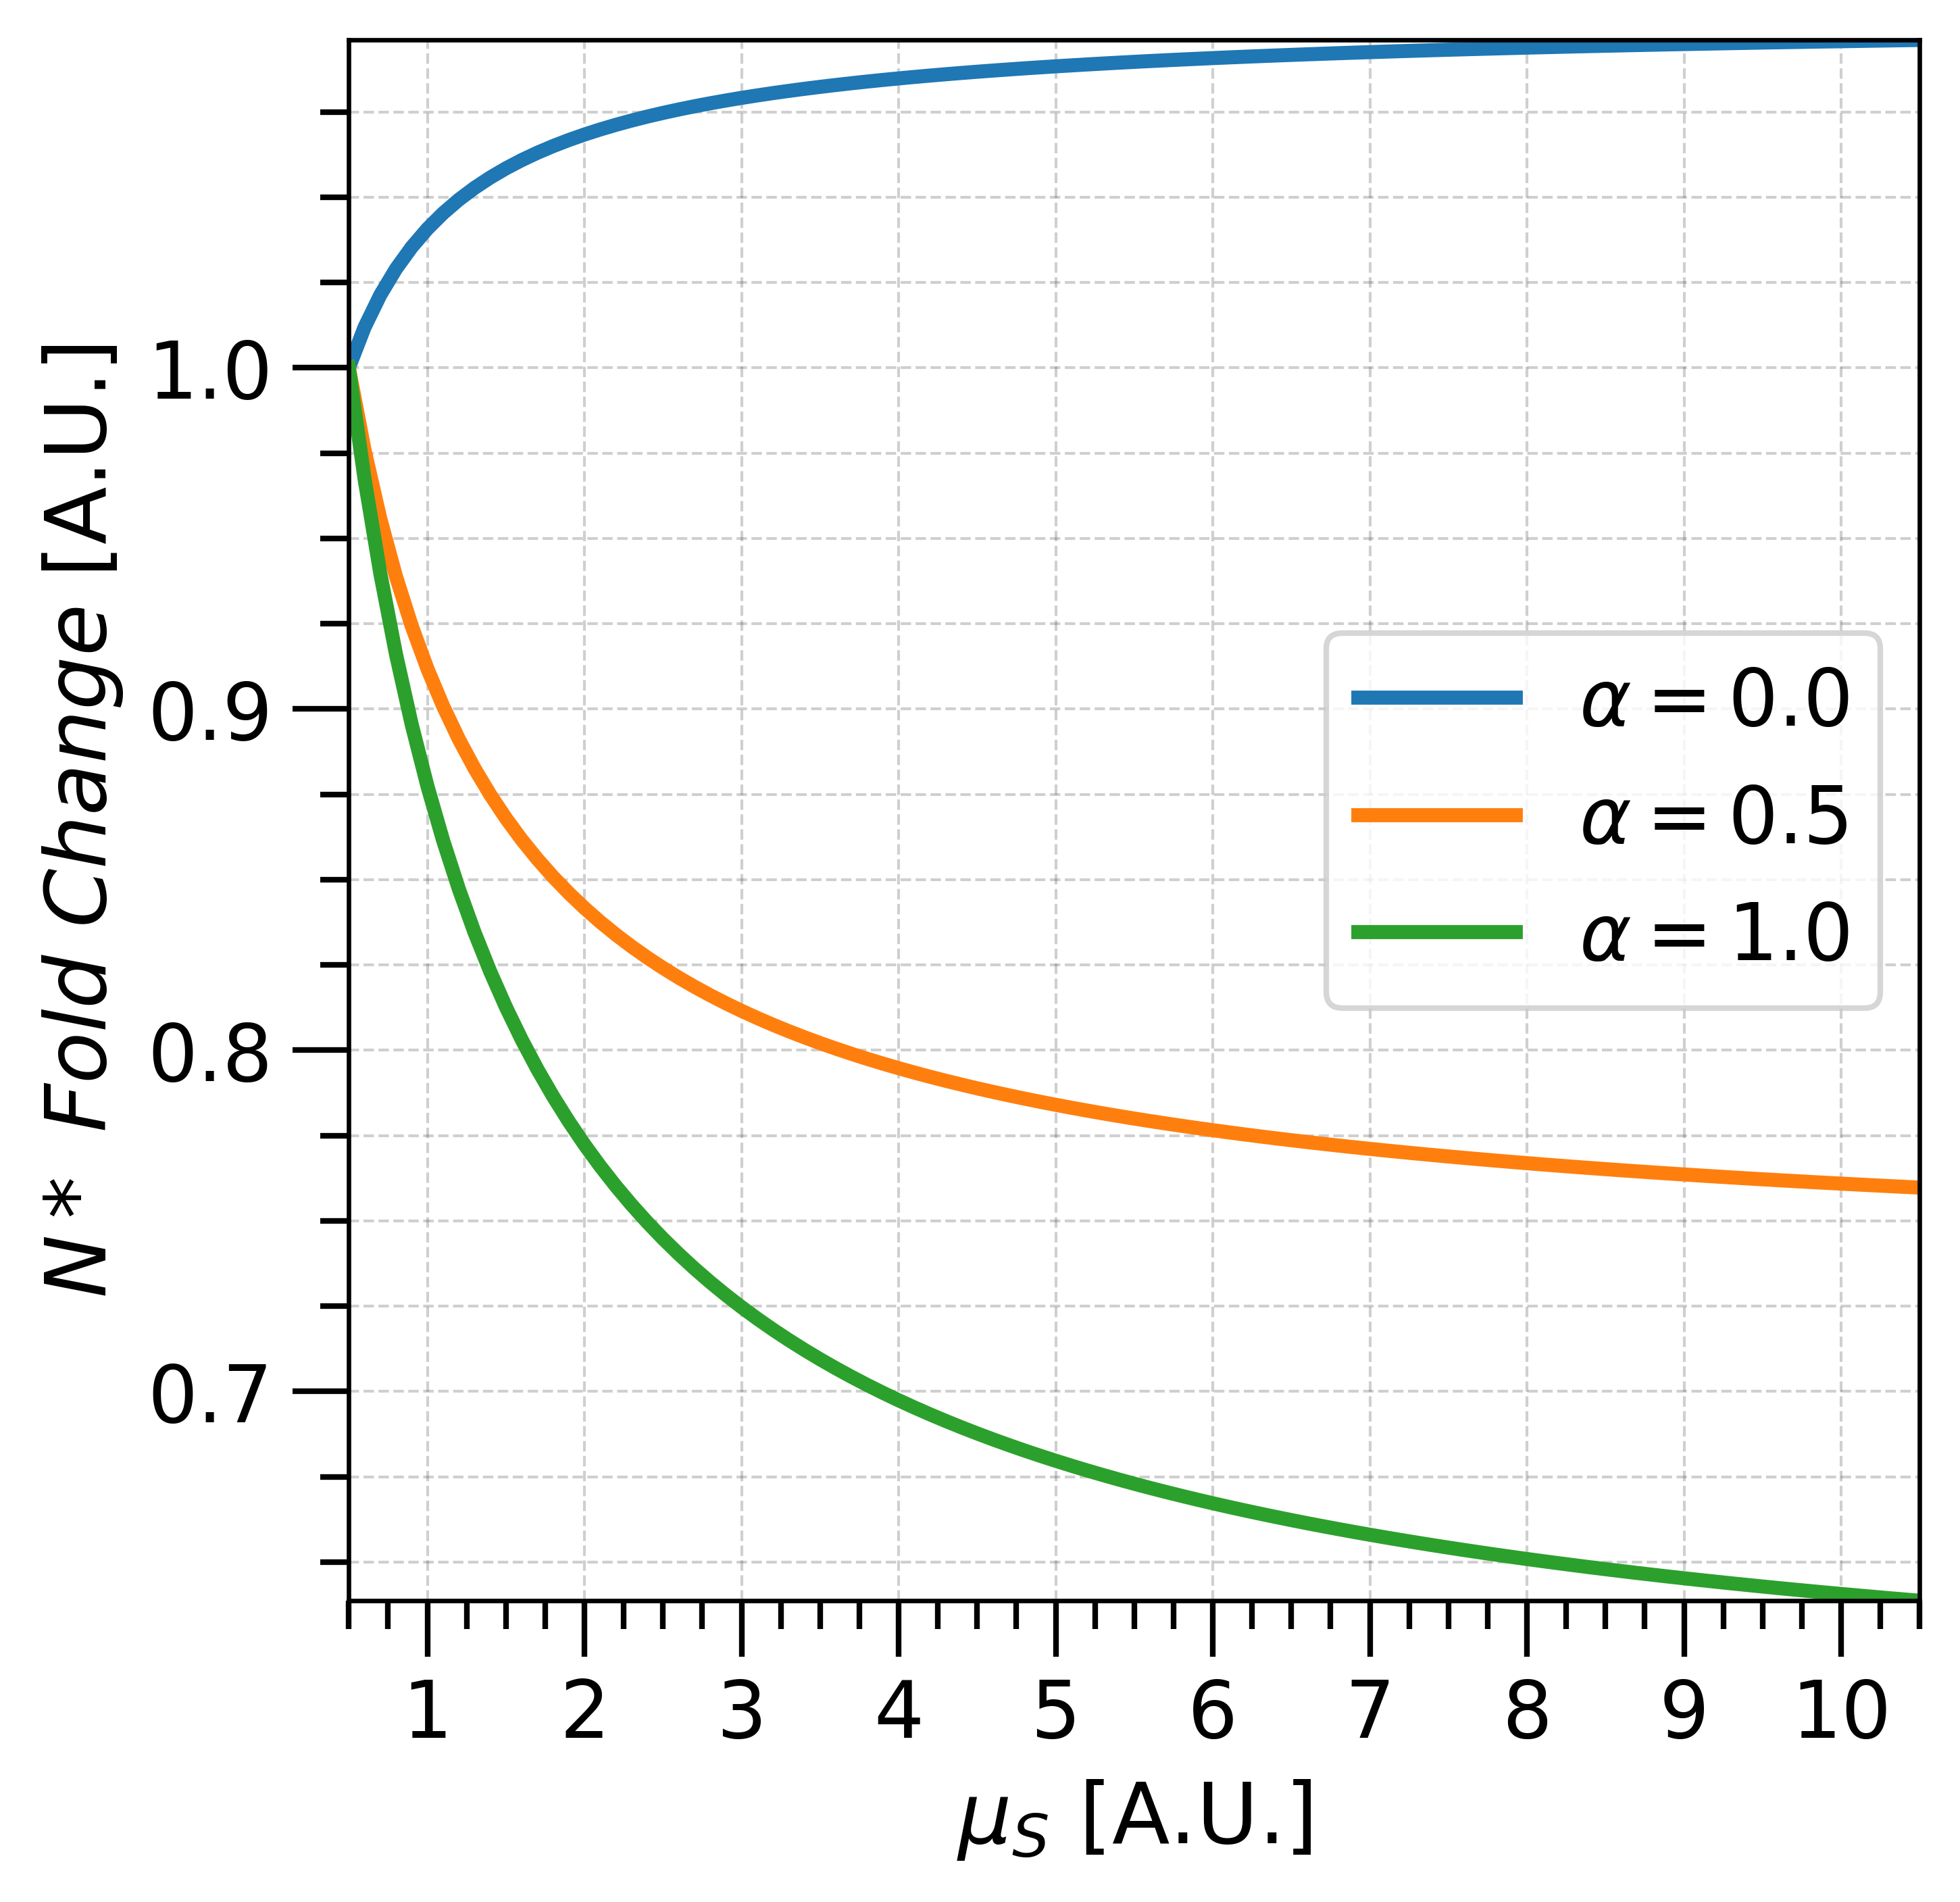

In [ ]:
#Second version of figure

fig4d  = plt.figure(figsize=(5,5), dpi=600)

ax1  = fig4d.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(G_series), max(B_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.1))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$α = 0.0$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$α = 0.5$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$α = 1.0$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. 4e

The hydra effect is potentiated by increasing intraspecific competition triggered by the presence of senior individuals ($ω$).

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 1.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 3.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 1.0
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$ω_1$'] = 0.0
param['$ω_2$'] = 0.0
mu_range, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$ω_1$'] = 1.0
param['$ω_2$'] = 1.0
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$ω_1$'] = 2.0
param['$ω_2$'] = 2.0
_, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

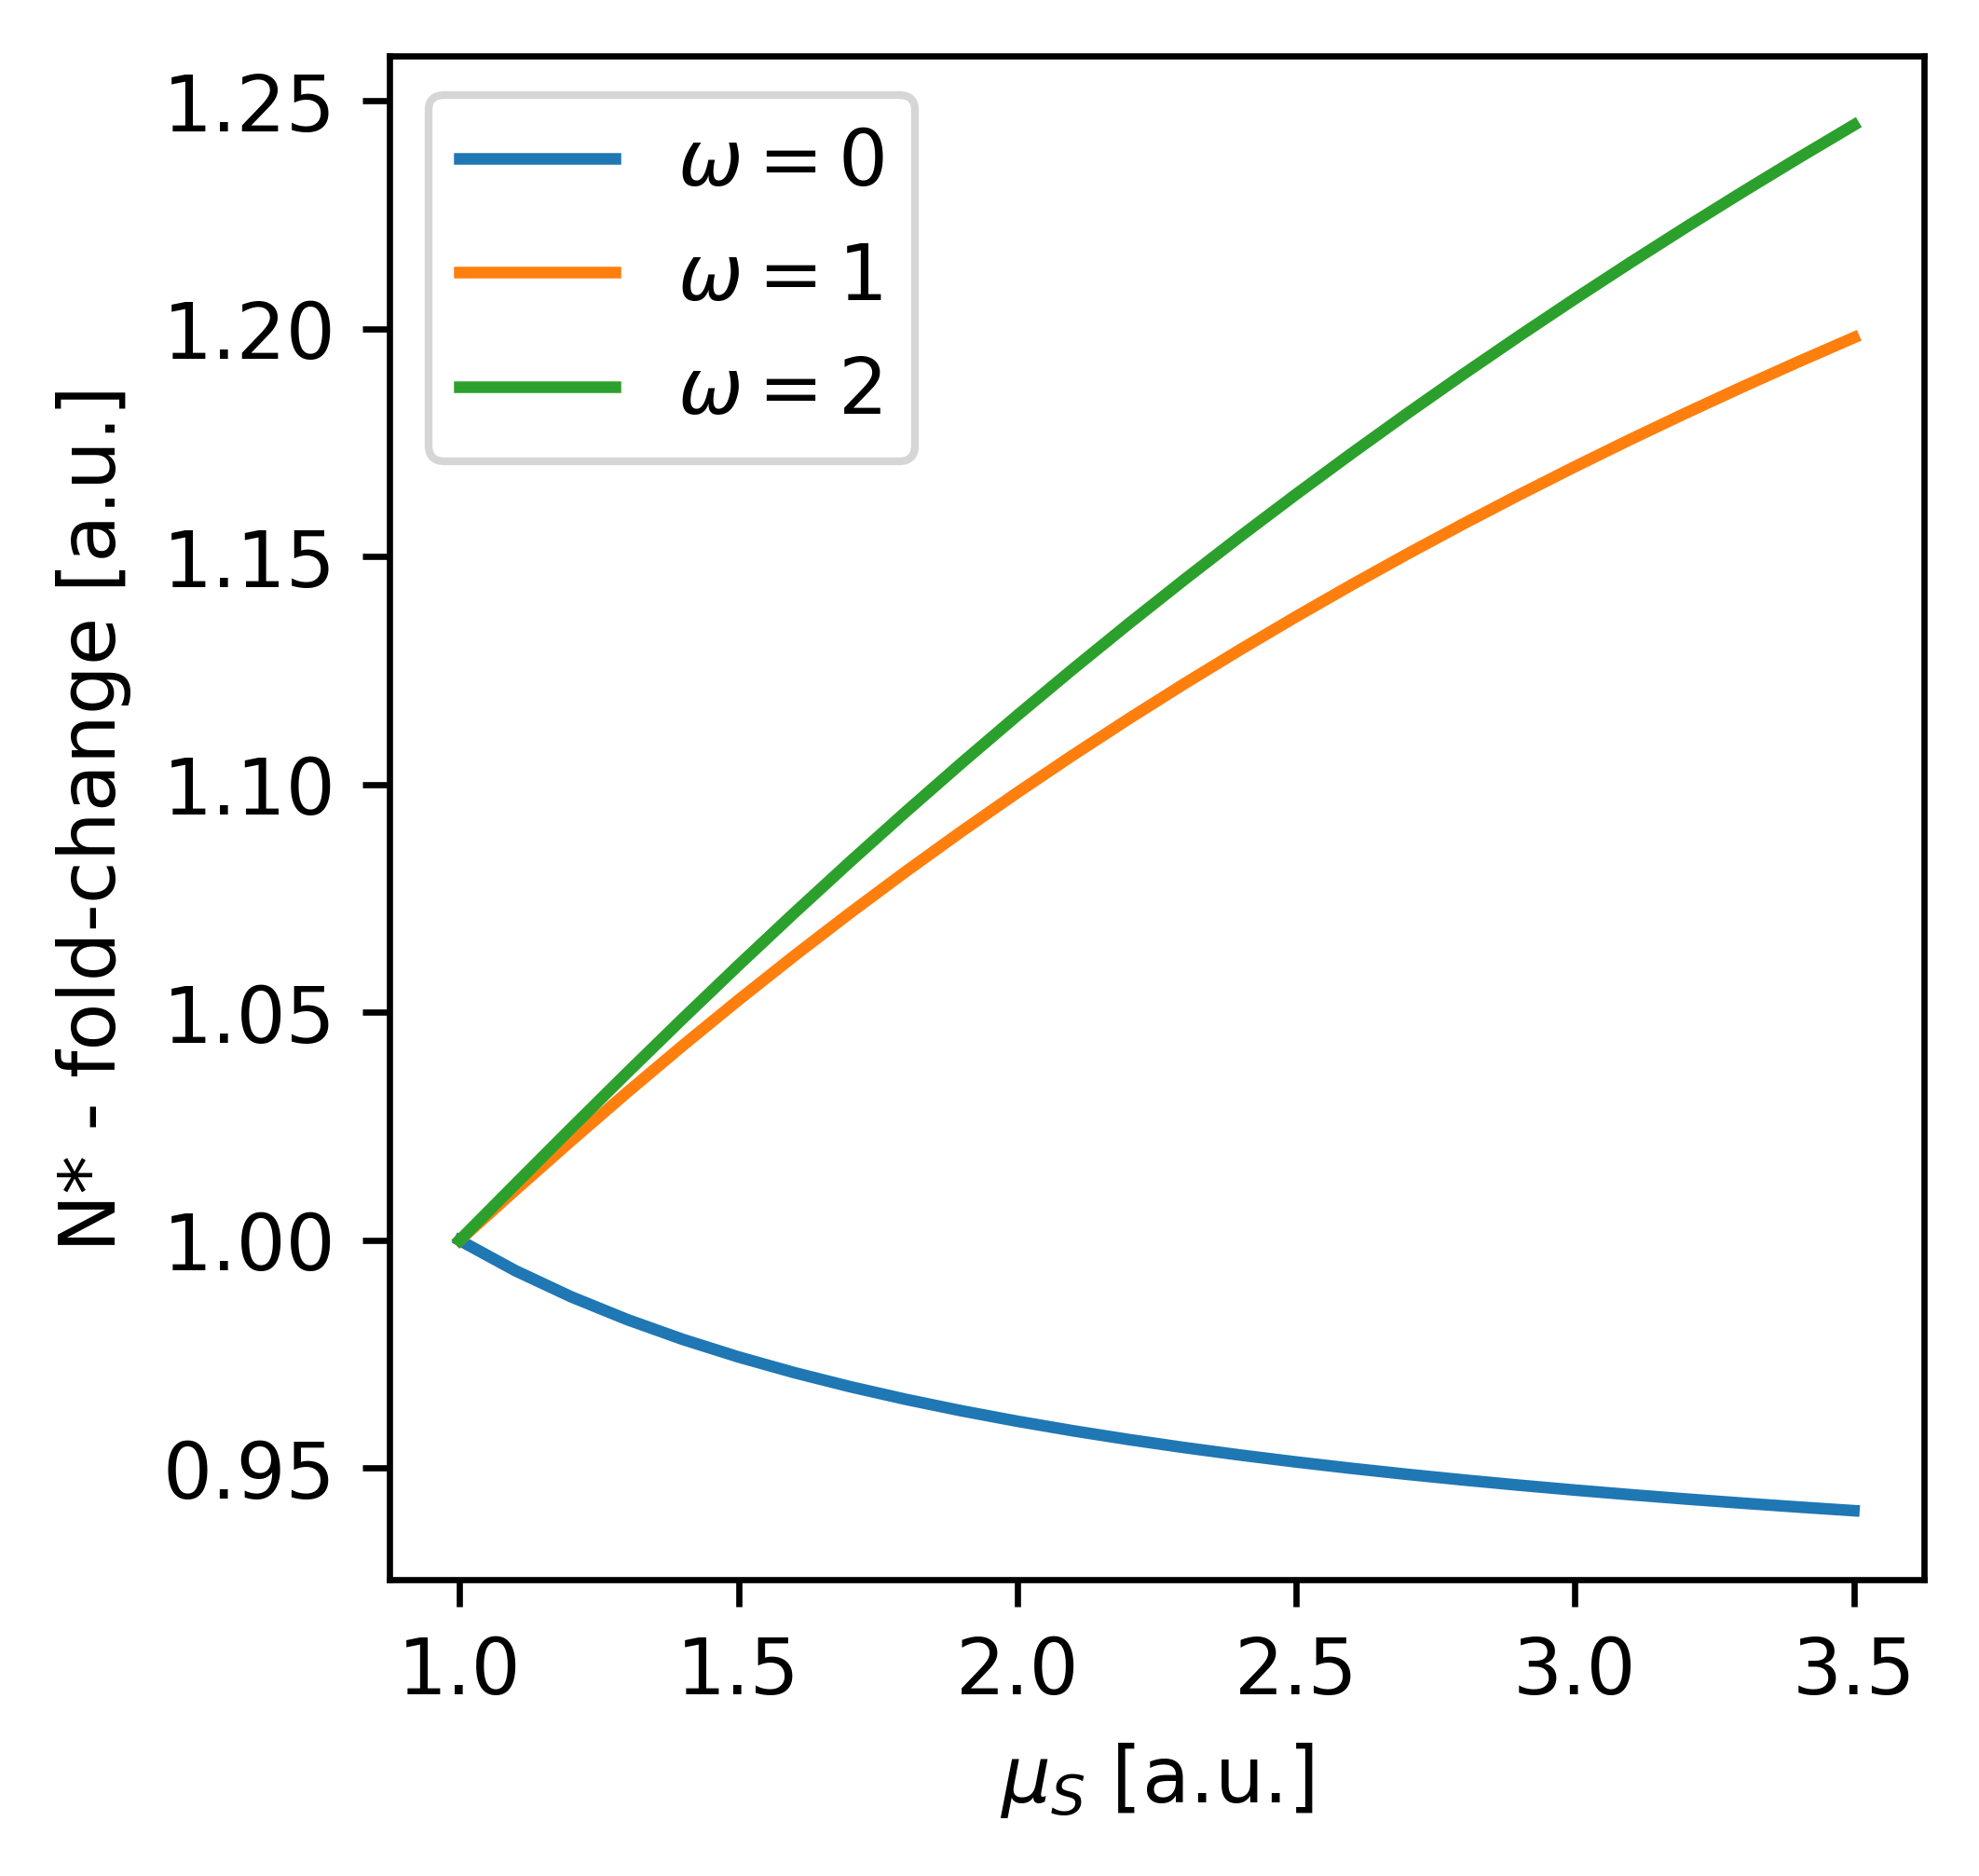

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$ω = 0$')
dores.plot(mu_range, R_series, label='$ω = 1$')
dores.plot(mu_range, G_series, label='$ω = 2$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

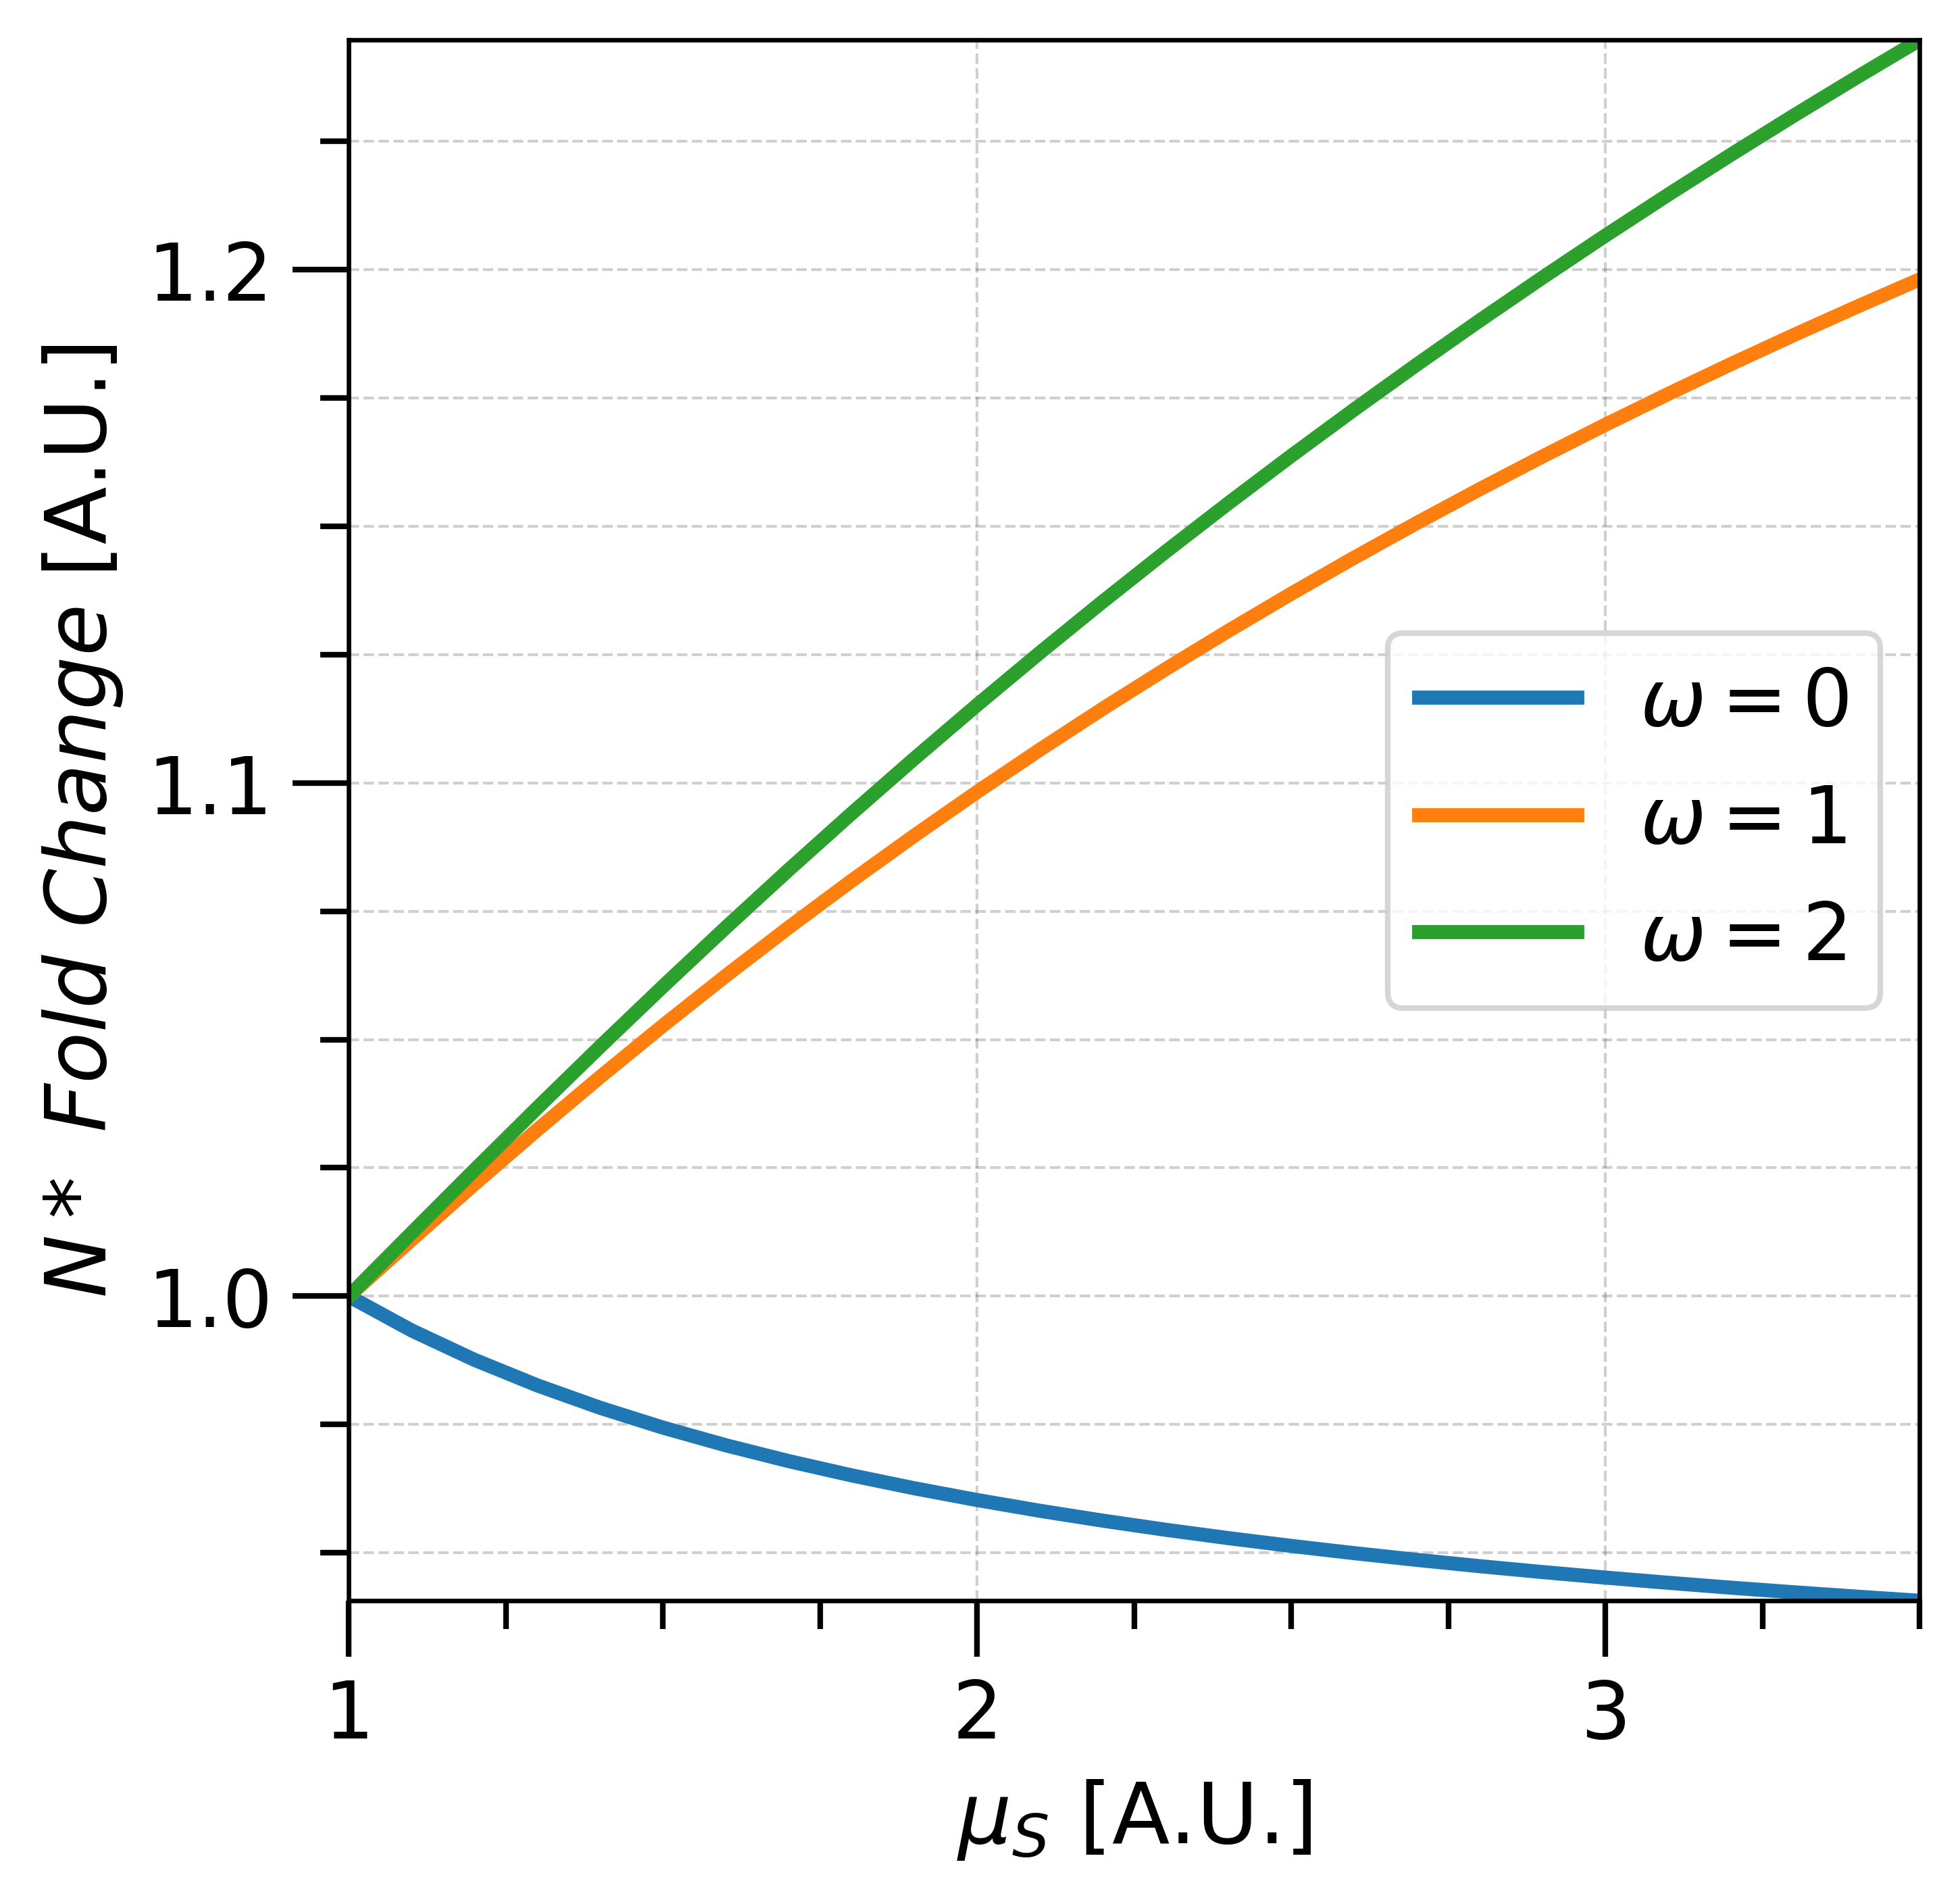

In [ ]:
#Second version of figure

fig4e  = plt.figure(figsize=(5,5), dpi=600)

ax1  = fig4e.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(B_series), max(G_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.1))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$ω = 0$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$ω = 1$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$ω = 2$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. 4F

## Fig. 5A

## Fig. 5B

## Fig. 5C

## Fig. 5D

# Supplementary Figures

## Fig. S8A

High Juvenile Mortality ($μ_J$) rates diminish or abrogate the hydra effect evaluated as a paradoxical increase in total population at equilibrium ($N^*$) with increasing values of CMR (higher $μ_S$).


In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 2.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 1.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 1.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 1.0, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 0.1
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$μ_{JA1}$'] = 1.0
param['$μ_{JA2}$'] = 1.0
mu_range, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$μ_{JA1}$'] = 2.0
param['$μ_{JA2}$'] = 2.0
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$μ_{JA1}$'] = 5.0
param['$μ_{JA2}$'] = 5.0
_, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

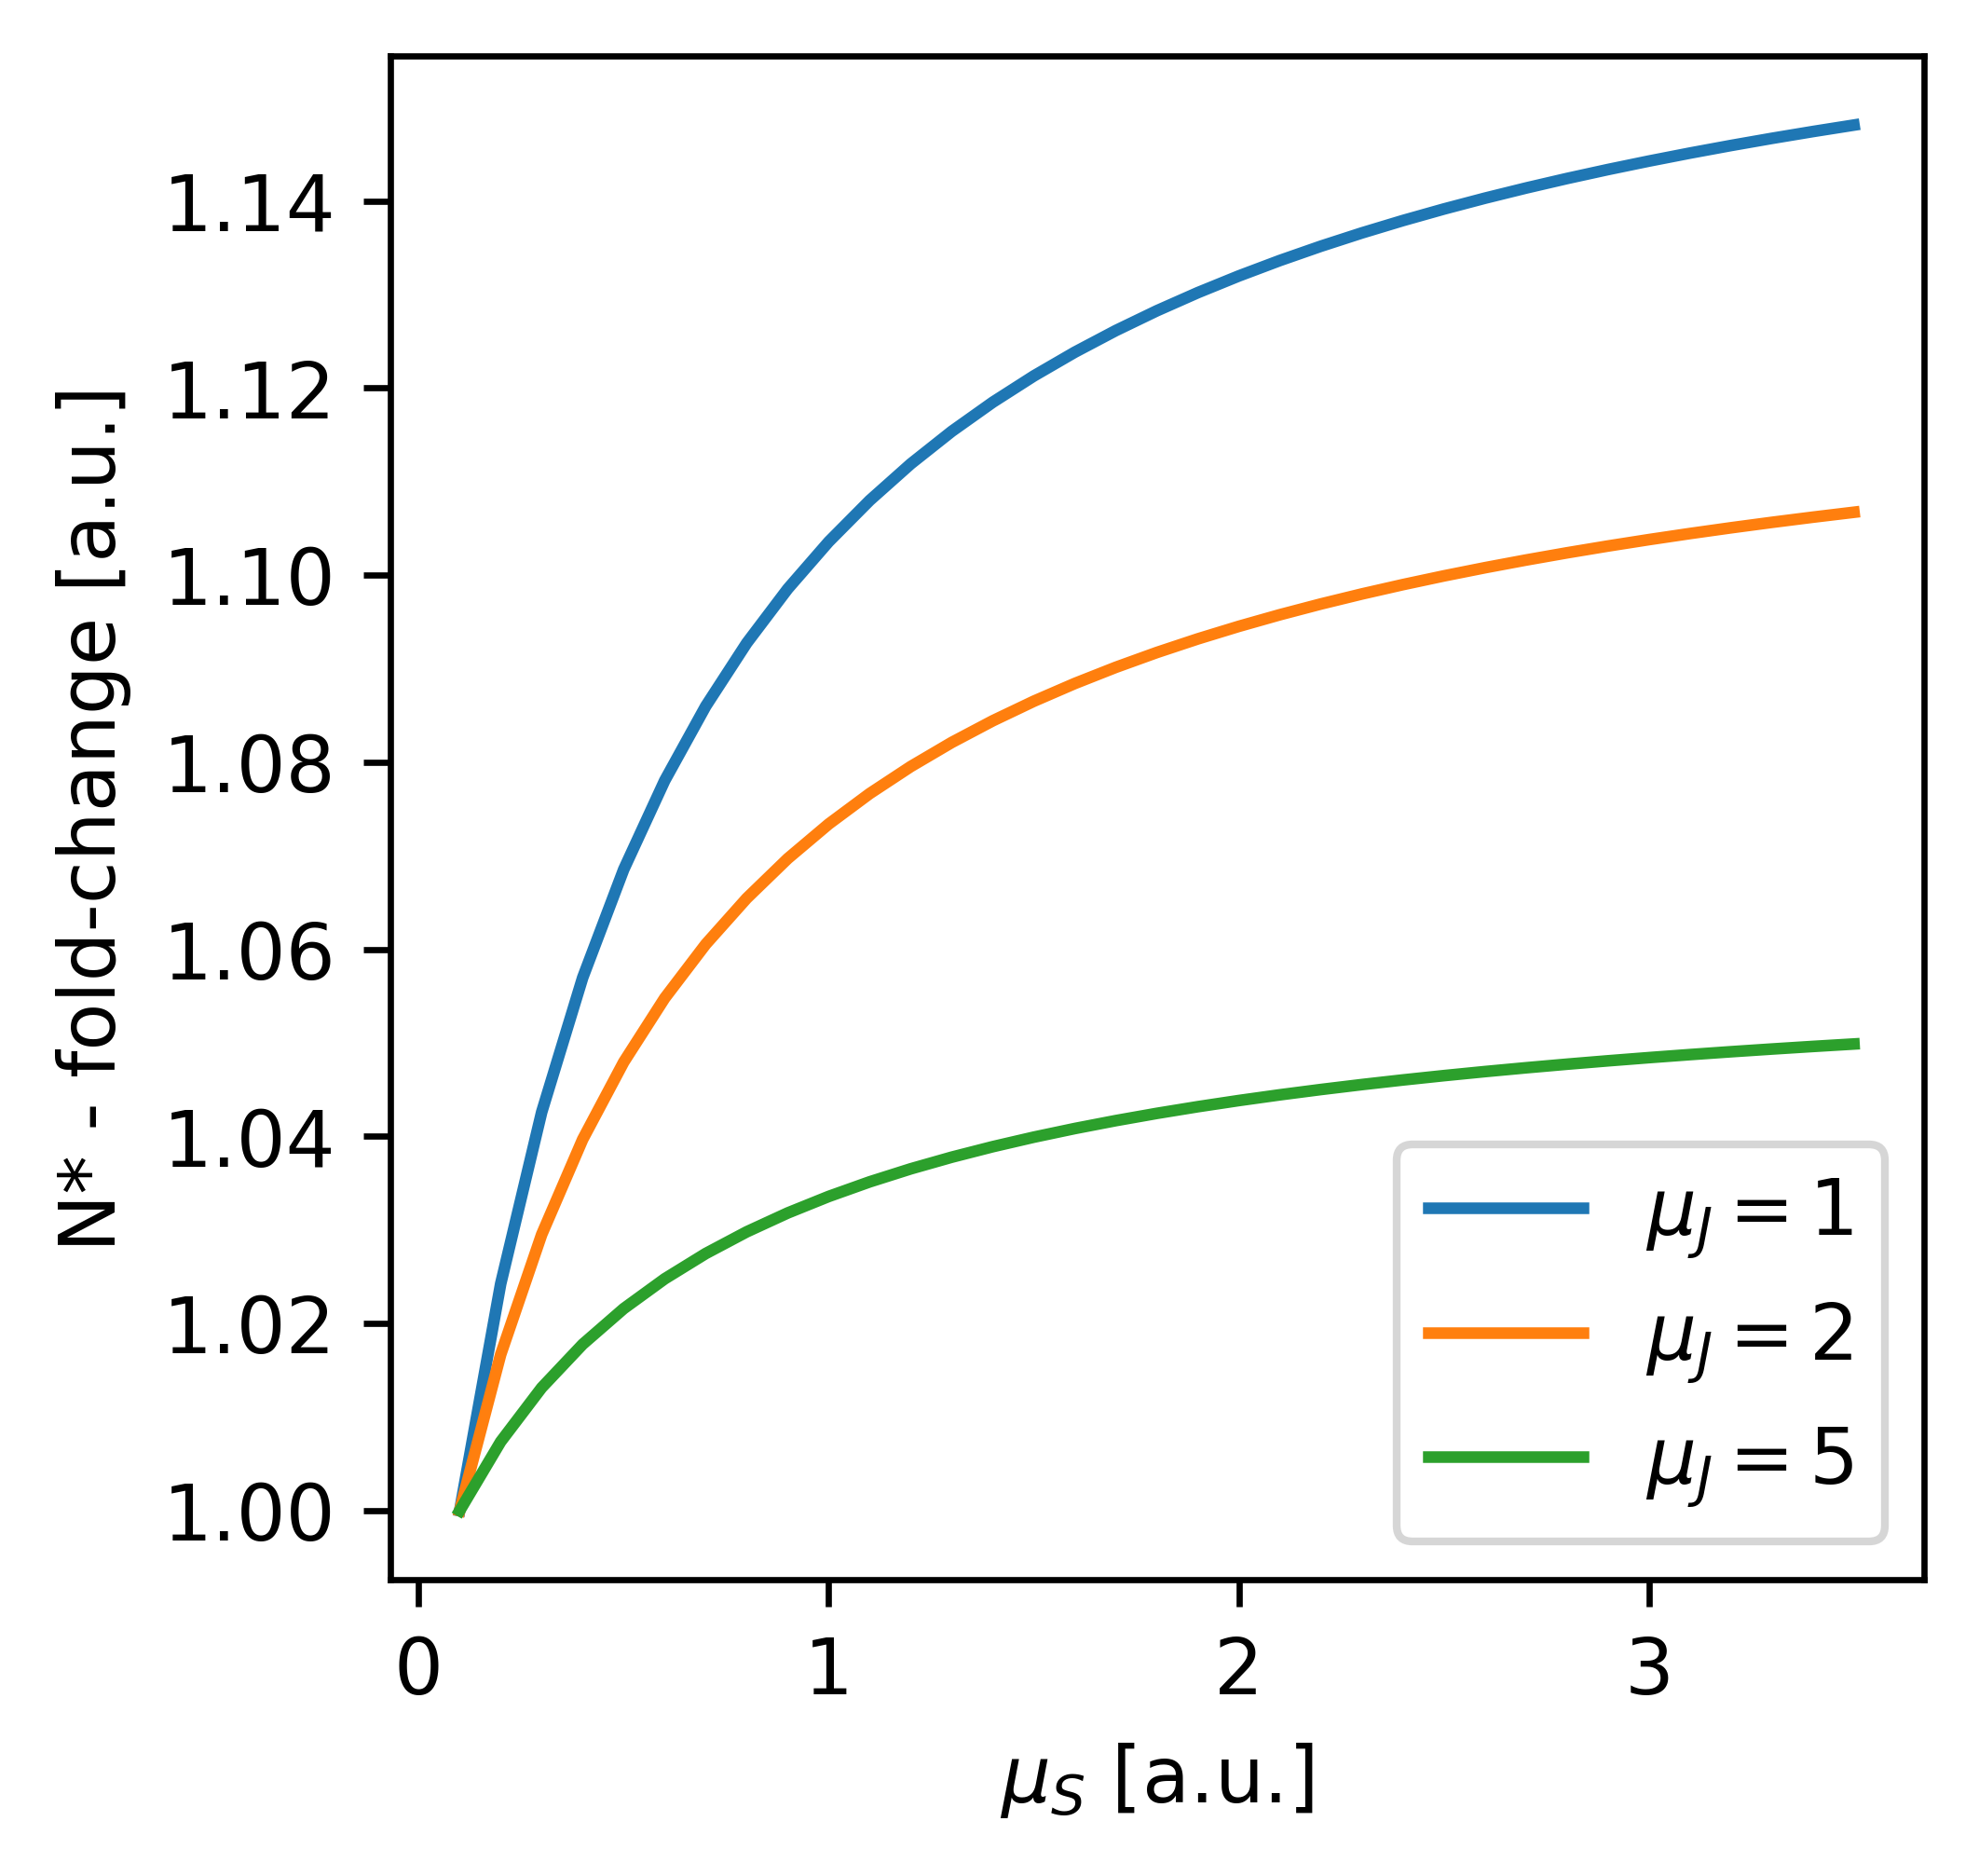

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$μ_{J} = 1$')
dores.plot(mu_range, R_series, label='$μ_{J} = 2$')
dores.plot(mu_range, G_series, label='$μ_{J} = 5$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

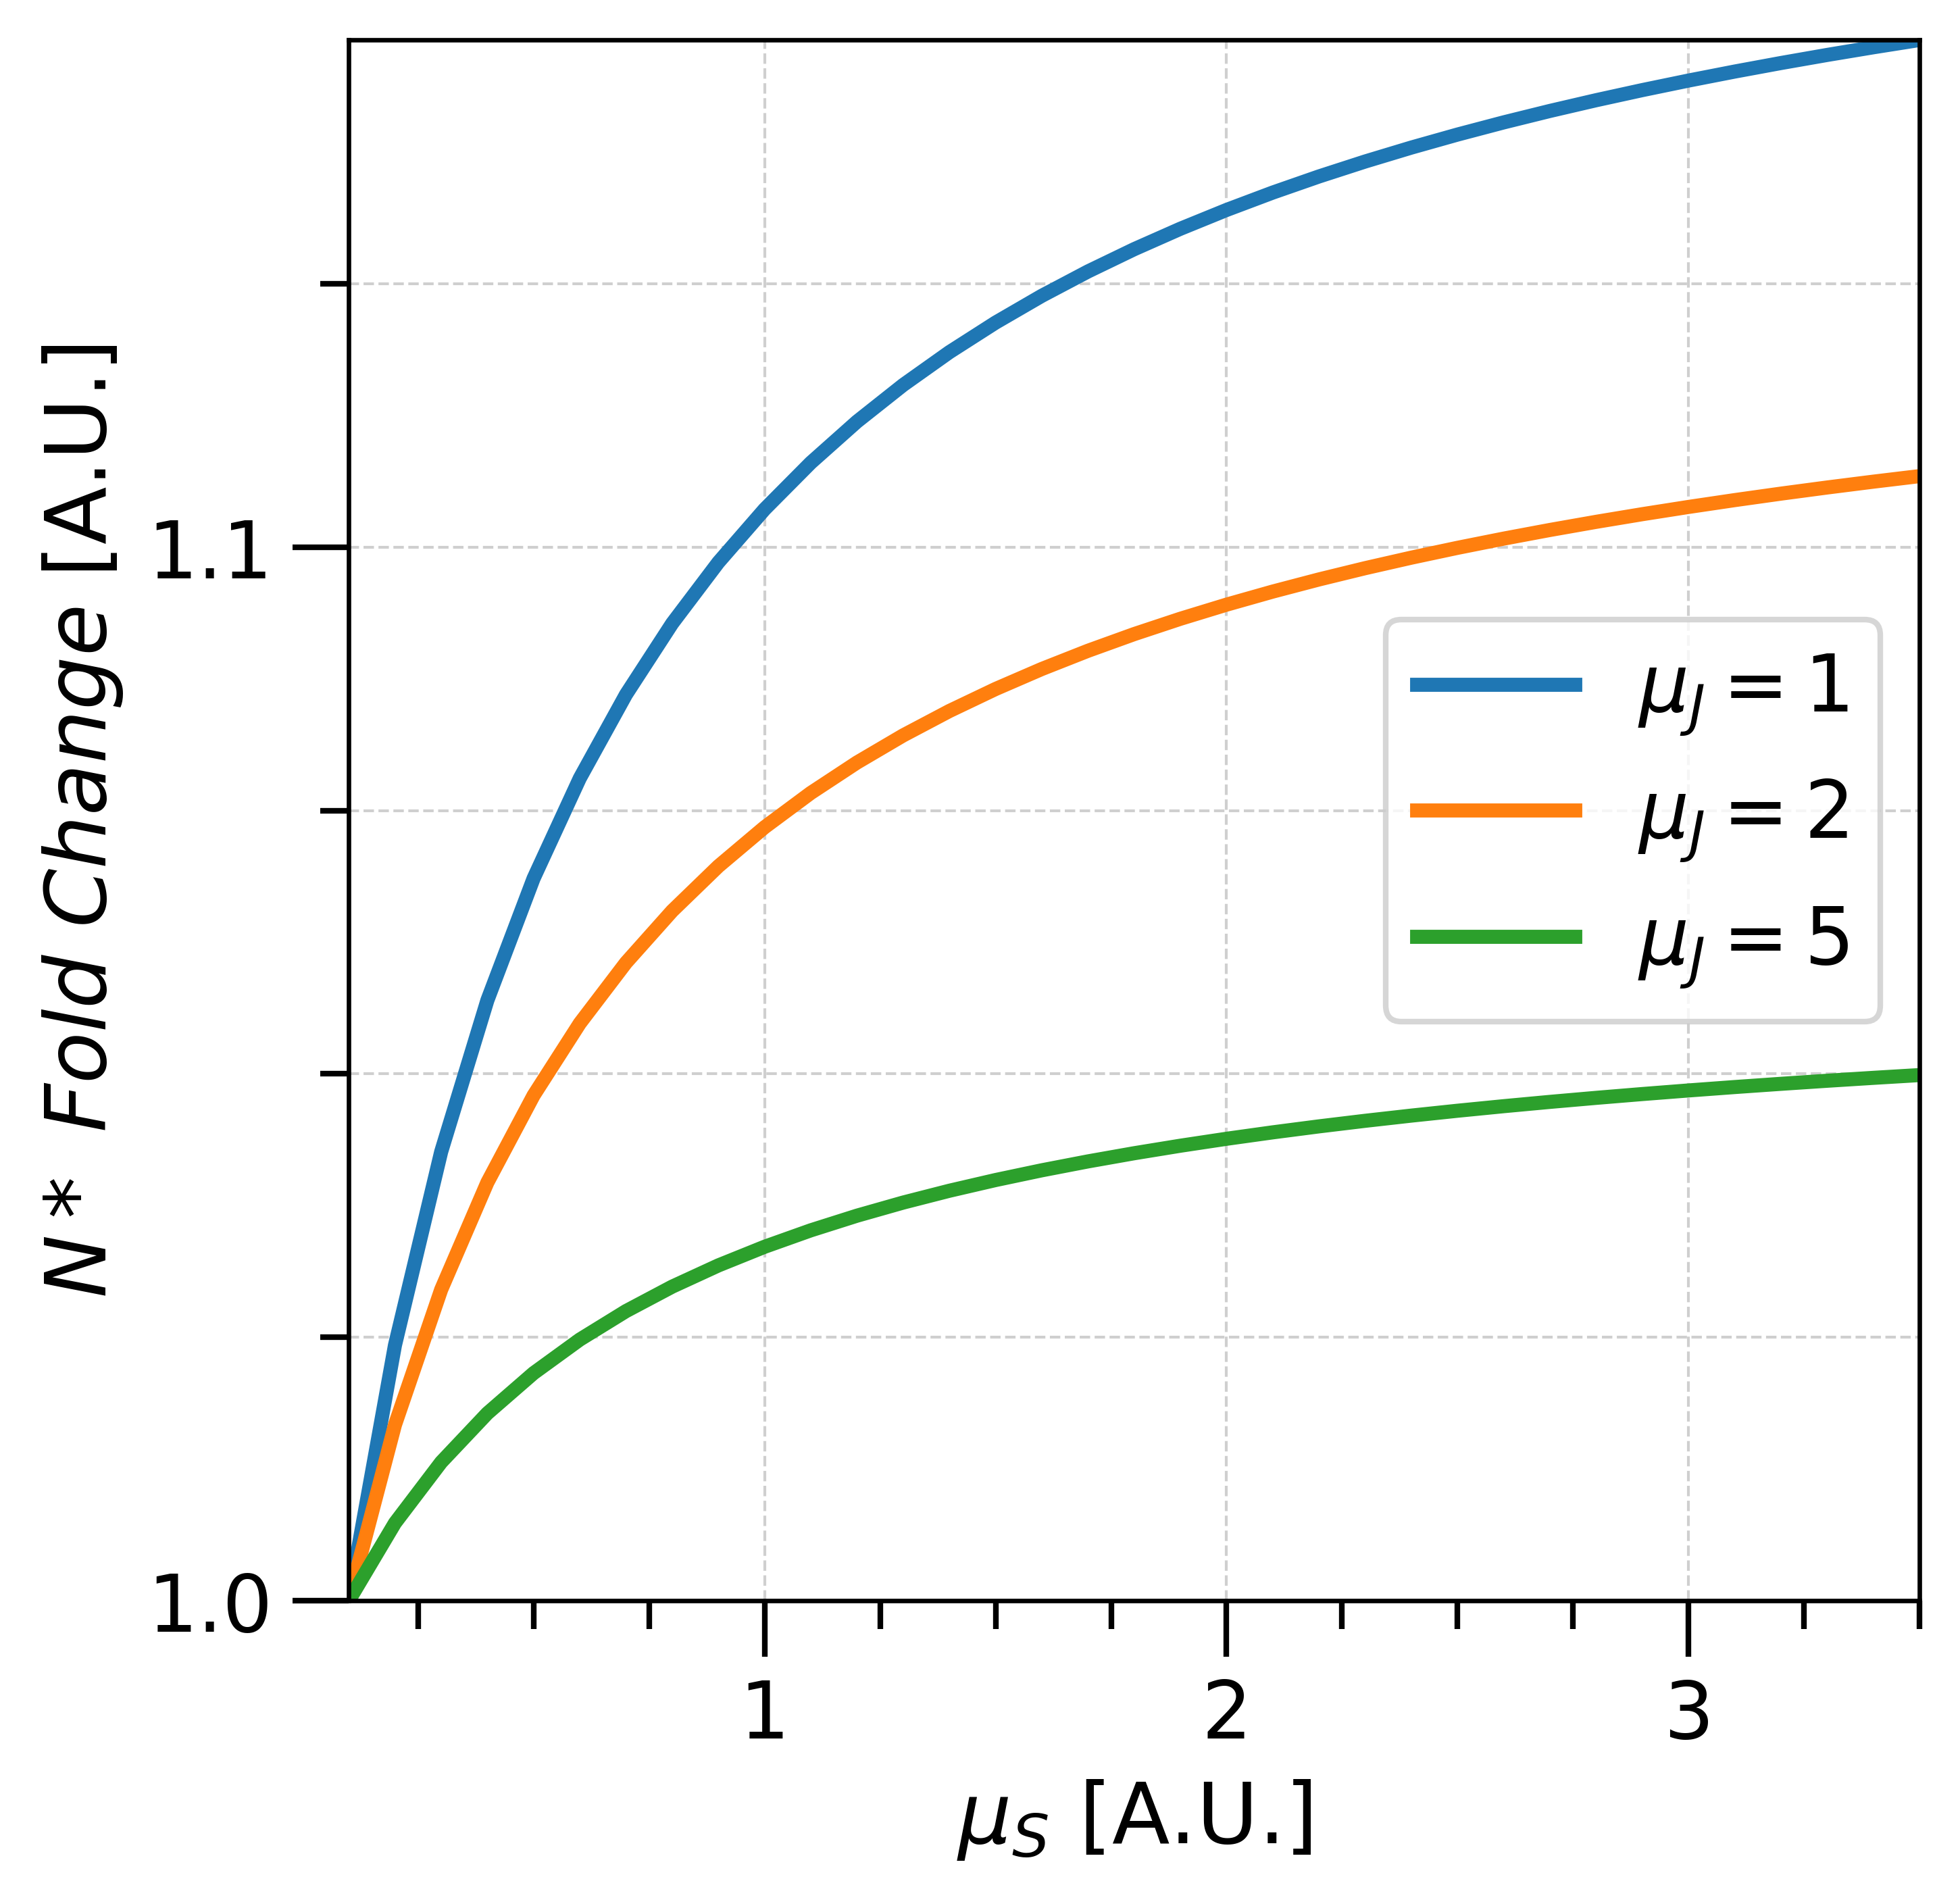

In [ ]:
#Second version of figure

figE8a = plt.figure(figsize=(5,5), dpi=600)

ax1 = figE8a.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(G_series), max(B_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.1))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$μ_{J} = 1$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$μ_{J} = 2$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$μ_{J} = 5$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. S8B

High Maturation Efficiency ($𝛾_A$) rates diminish or abrogate the hydra effect evaluated as a paradoxical increase in total population at equilibrium ($N^*$) with increasing values of CMR (higher $μ_S$).


In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 2.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 1.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 1.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 1.0, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 0.1
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$γ_{A1}$'] = 1.0
param['$γ_{A2}$'] = 1.0
mu_range, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$γ_{A1}$'] = 2.0
param['$γ_{A2}$'] = 2.0
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$γ_{A1}$'] = 5.0
param['$γ_{A2}$'] = 5.0
_, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

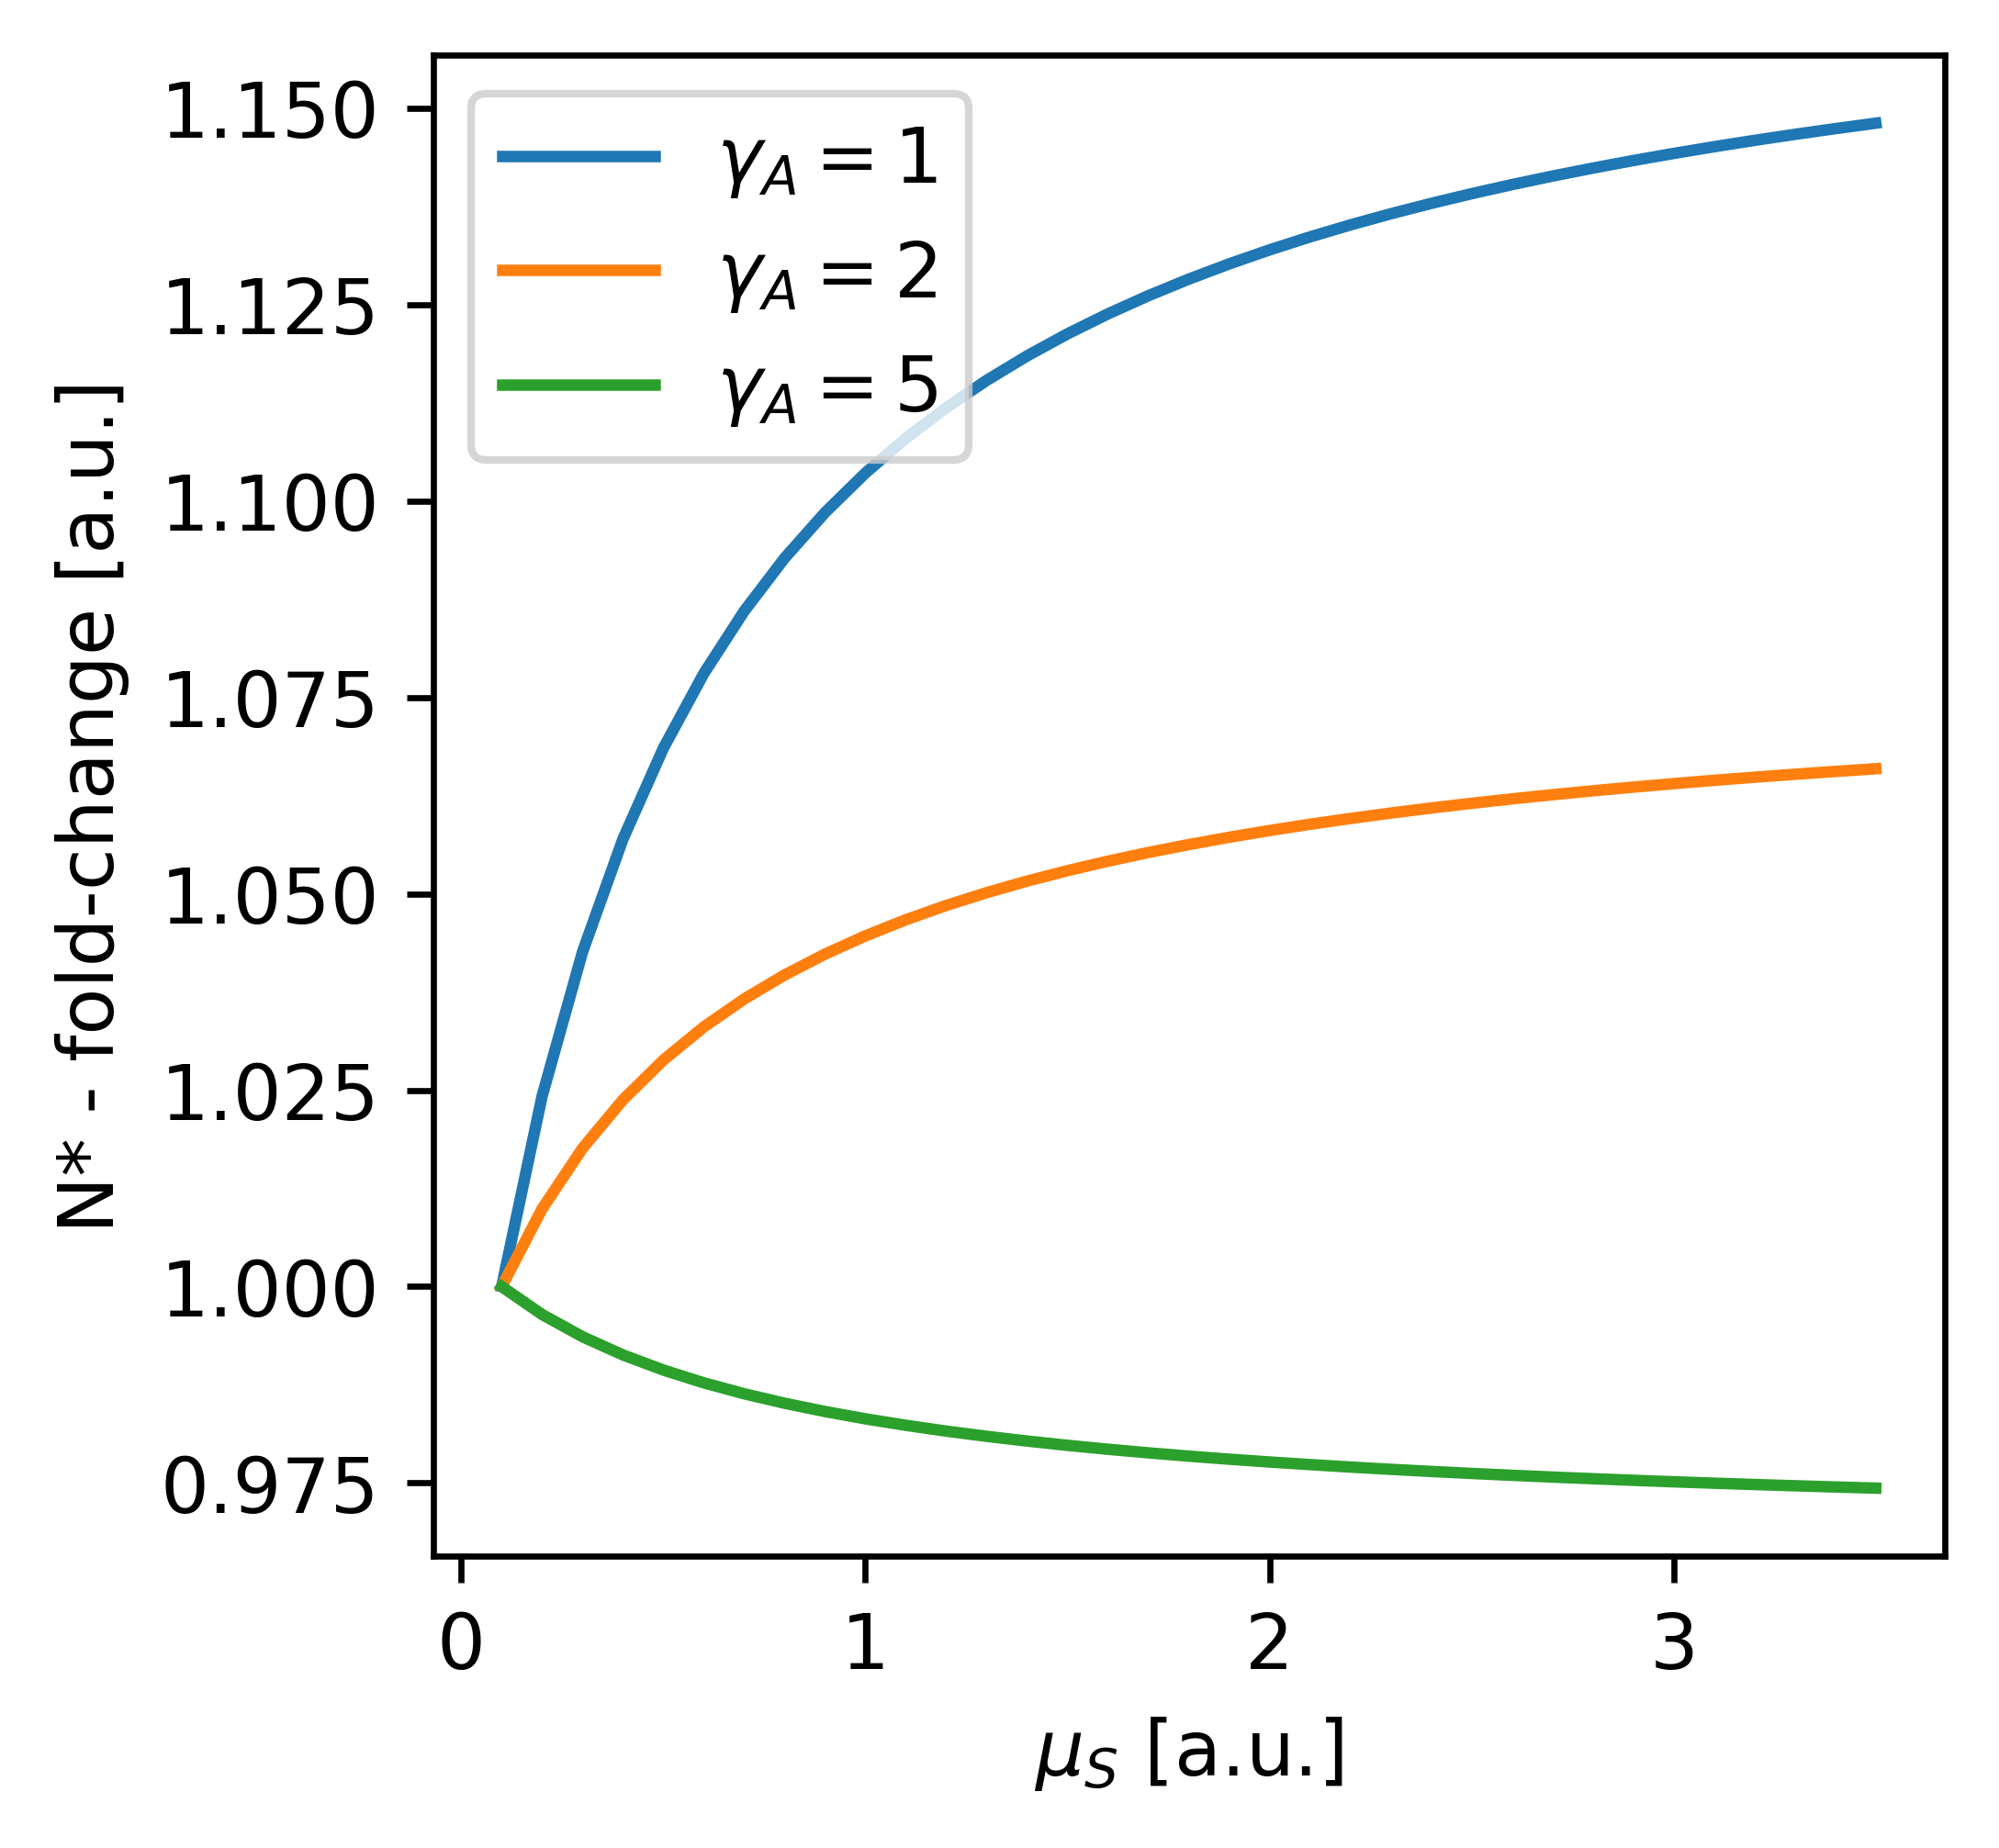

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$γ_{A} = 1$')
dores.plot(mu_range, R_series, label='$γ_{A} = 2$')
dores.plot(mu_range, G_series, label='$γ_{A} = 5$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

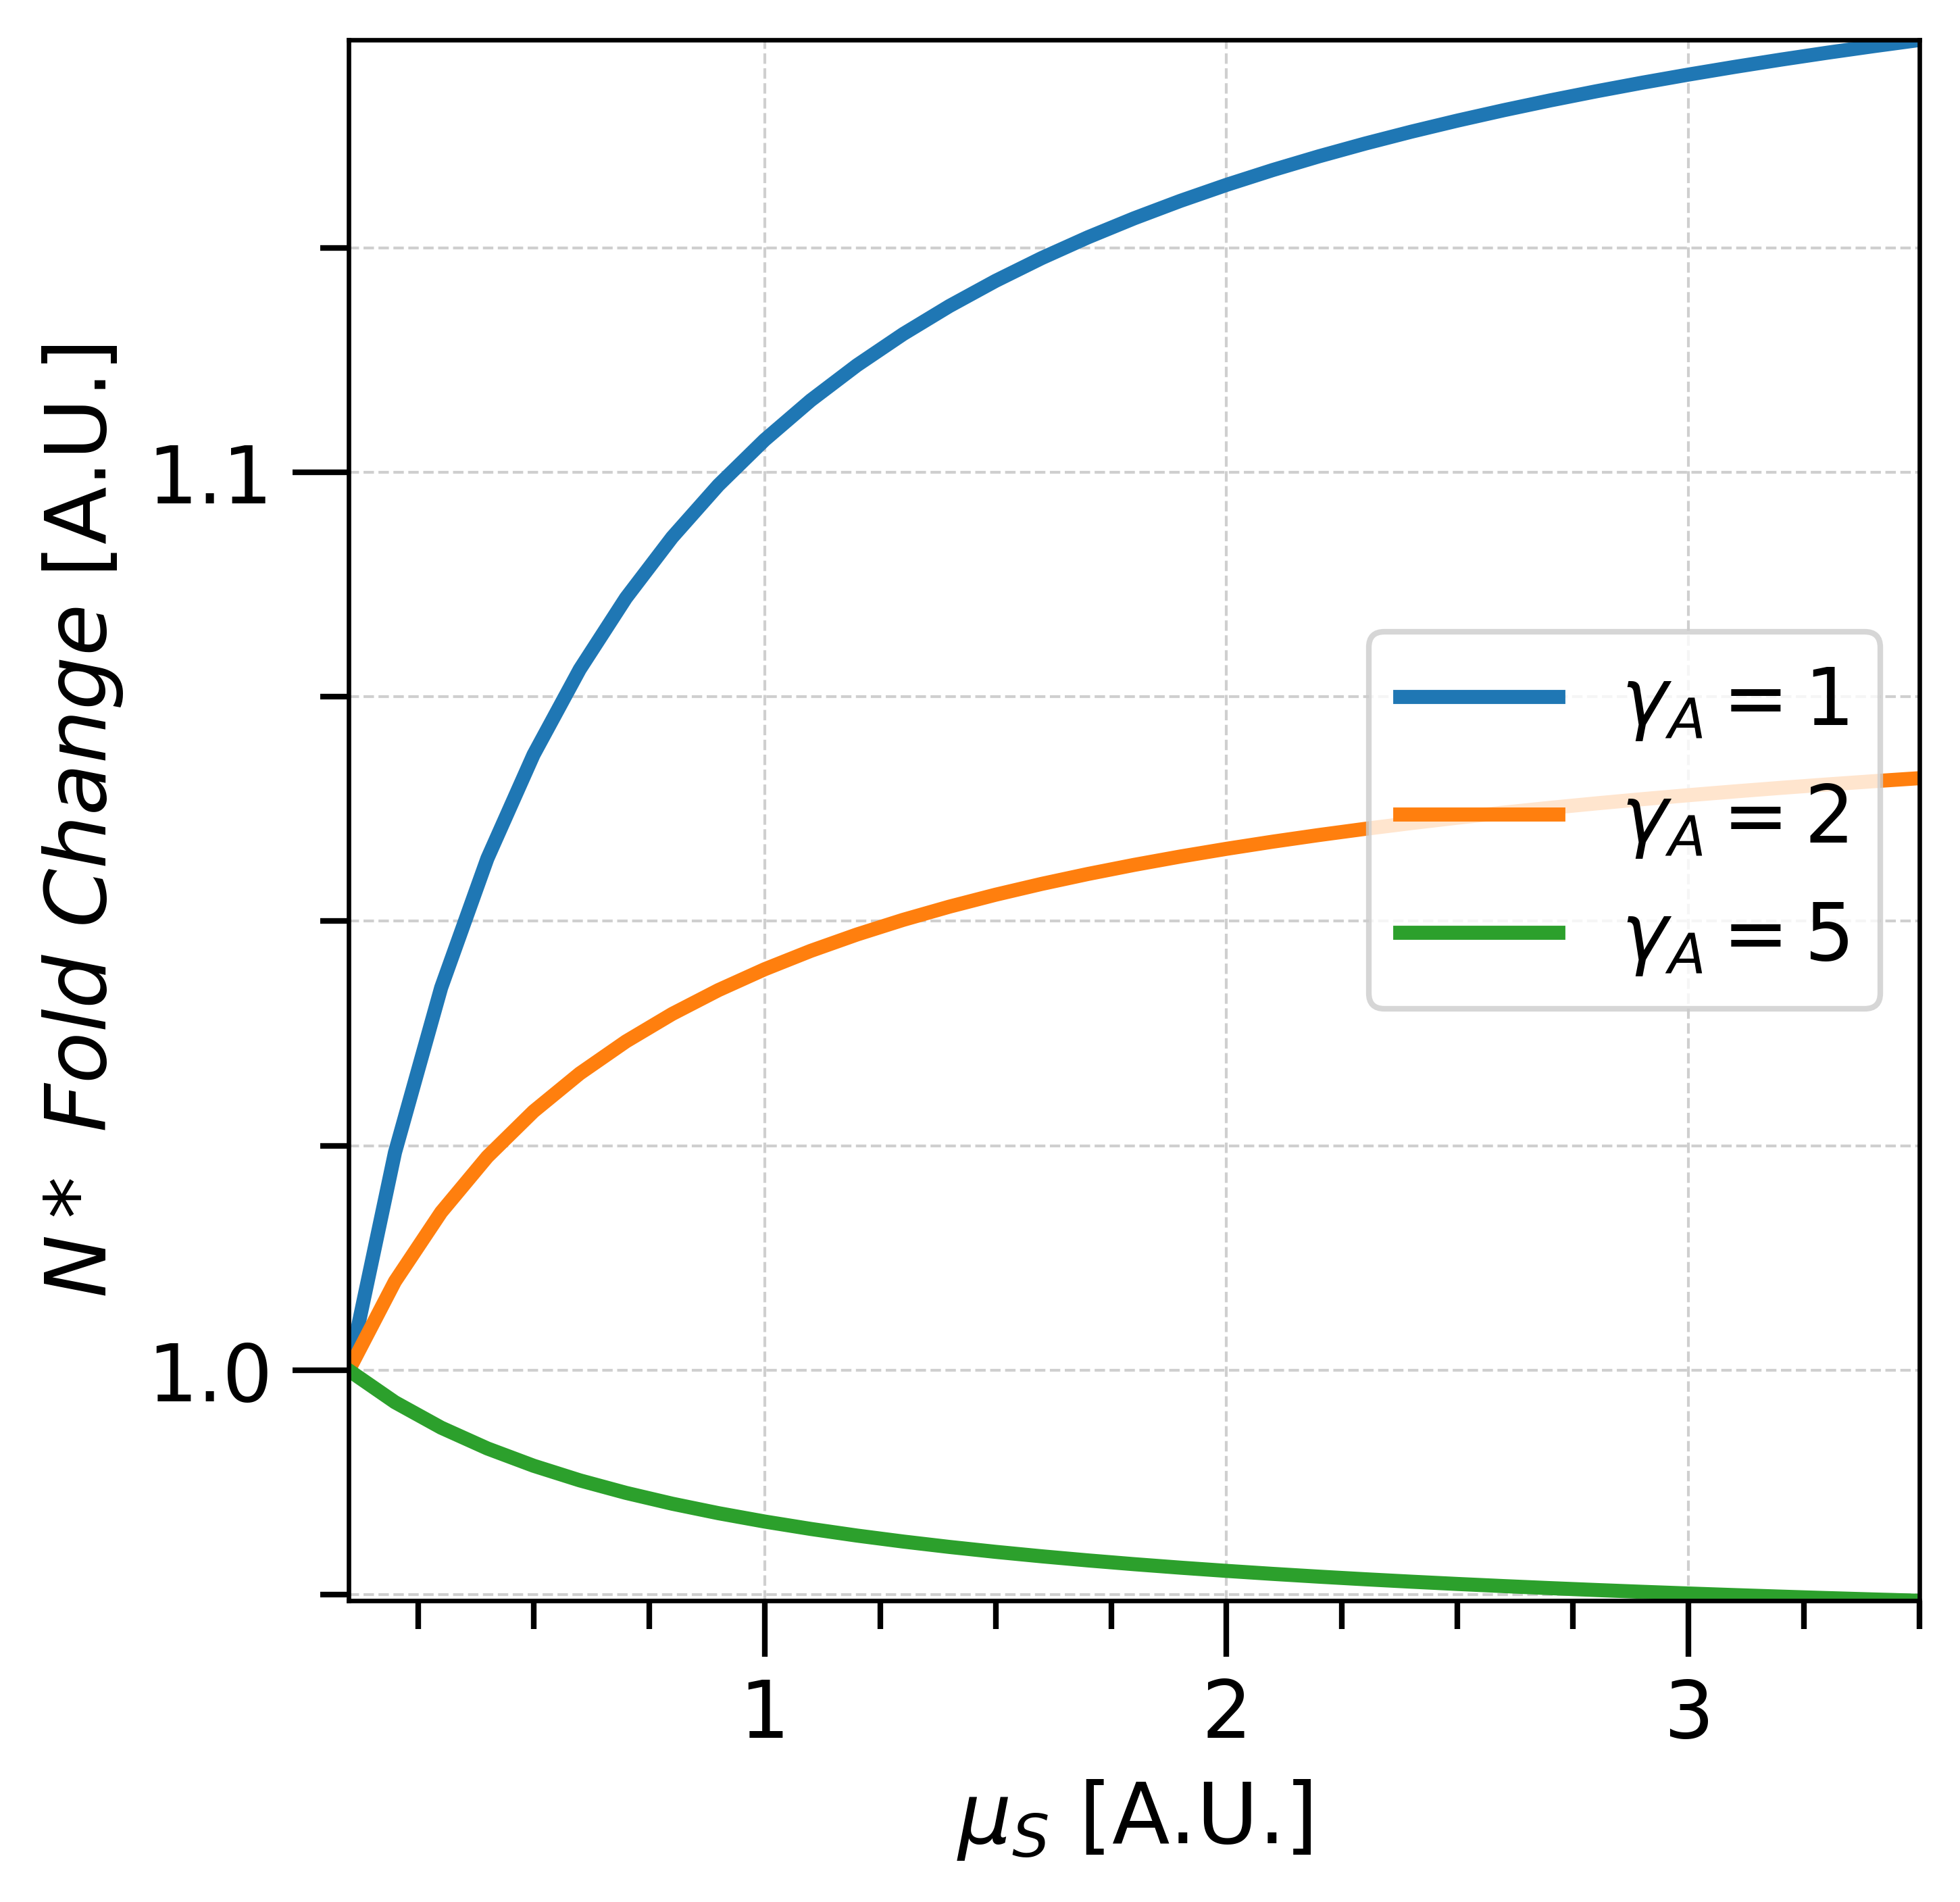

In [ ]:
#Second version of figure

figE8b = plt.figure(figsize=(5,5), dpi=600)

ax1  = figE8b.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(G_series), max(B_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.1))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$γ_{A} = 1$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$γ_{A} = 2$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$γ_{A} = 5$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. S8C

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 2.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 5.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 1.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 1.0, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 0.6 # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 0.1
end_mu = 3.6
step_mu = 0.1


In [ ]:
# param['$β_{A1}$'] = 0.1
# param['$β_{A2}$'] = 0.1
mu_range, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{A1}$', control2='$μ_{A2}$', full = True)
param['$μ_{A1}$'] = 0.5
param['$μ_{A2}$'] = 0.5
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$μ_{S1}$'] = 0.6
param['$μ_{S2}$'] = 0.6
_, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{JA1}$', control2='$μ_{JA2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

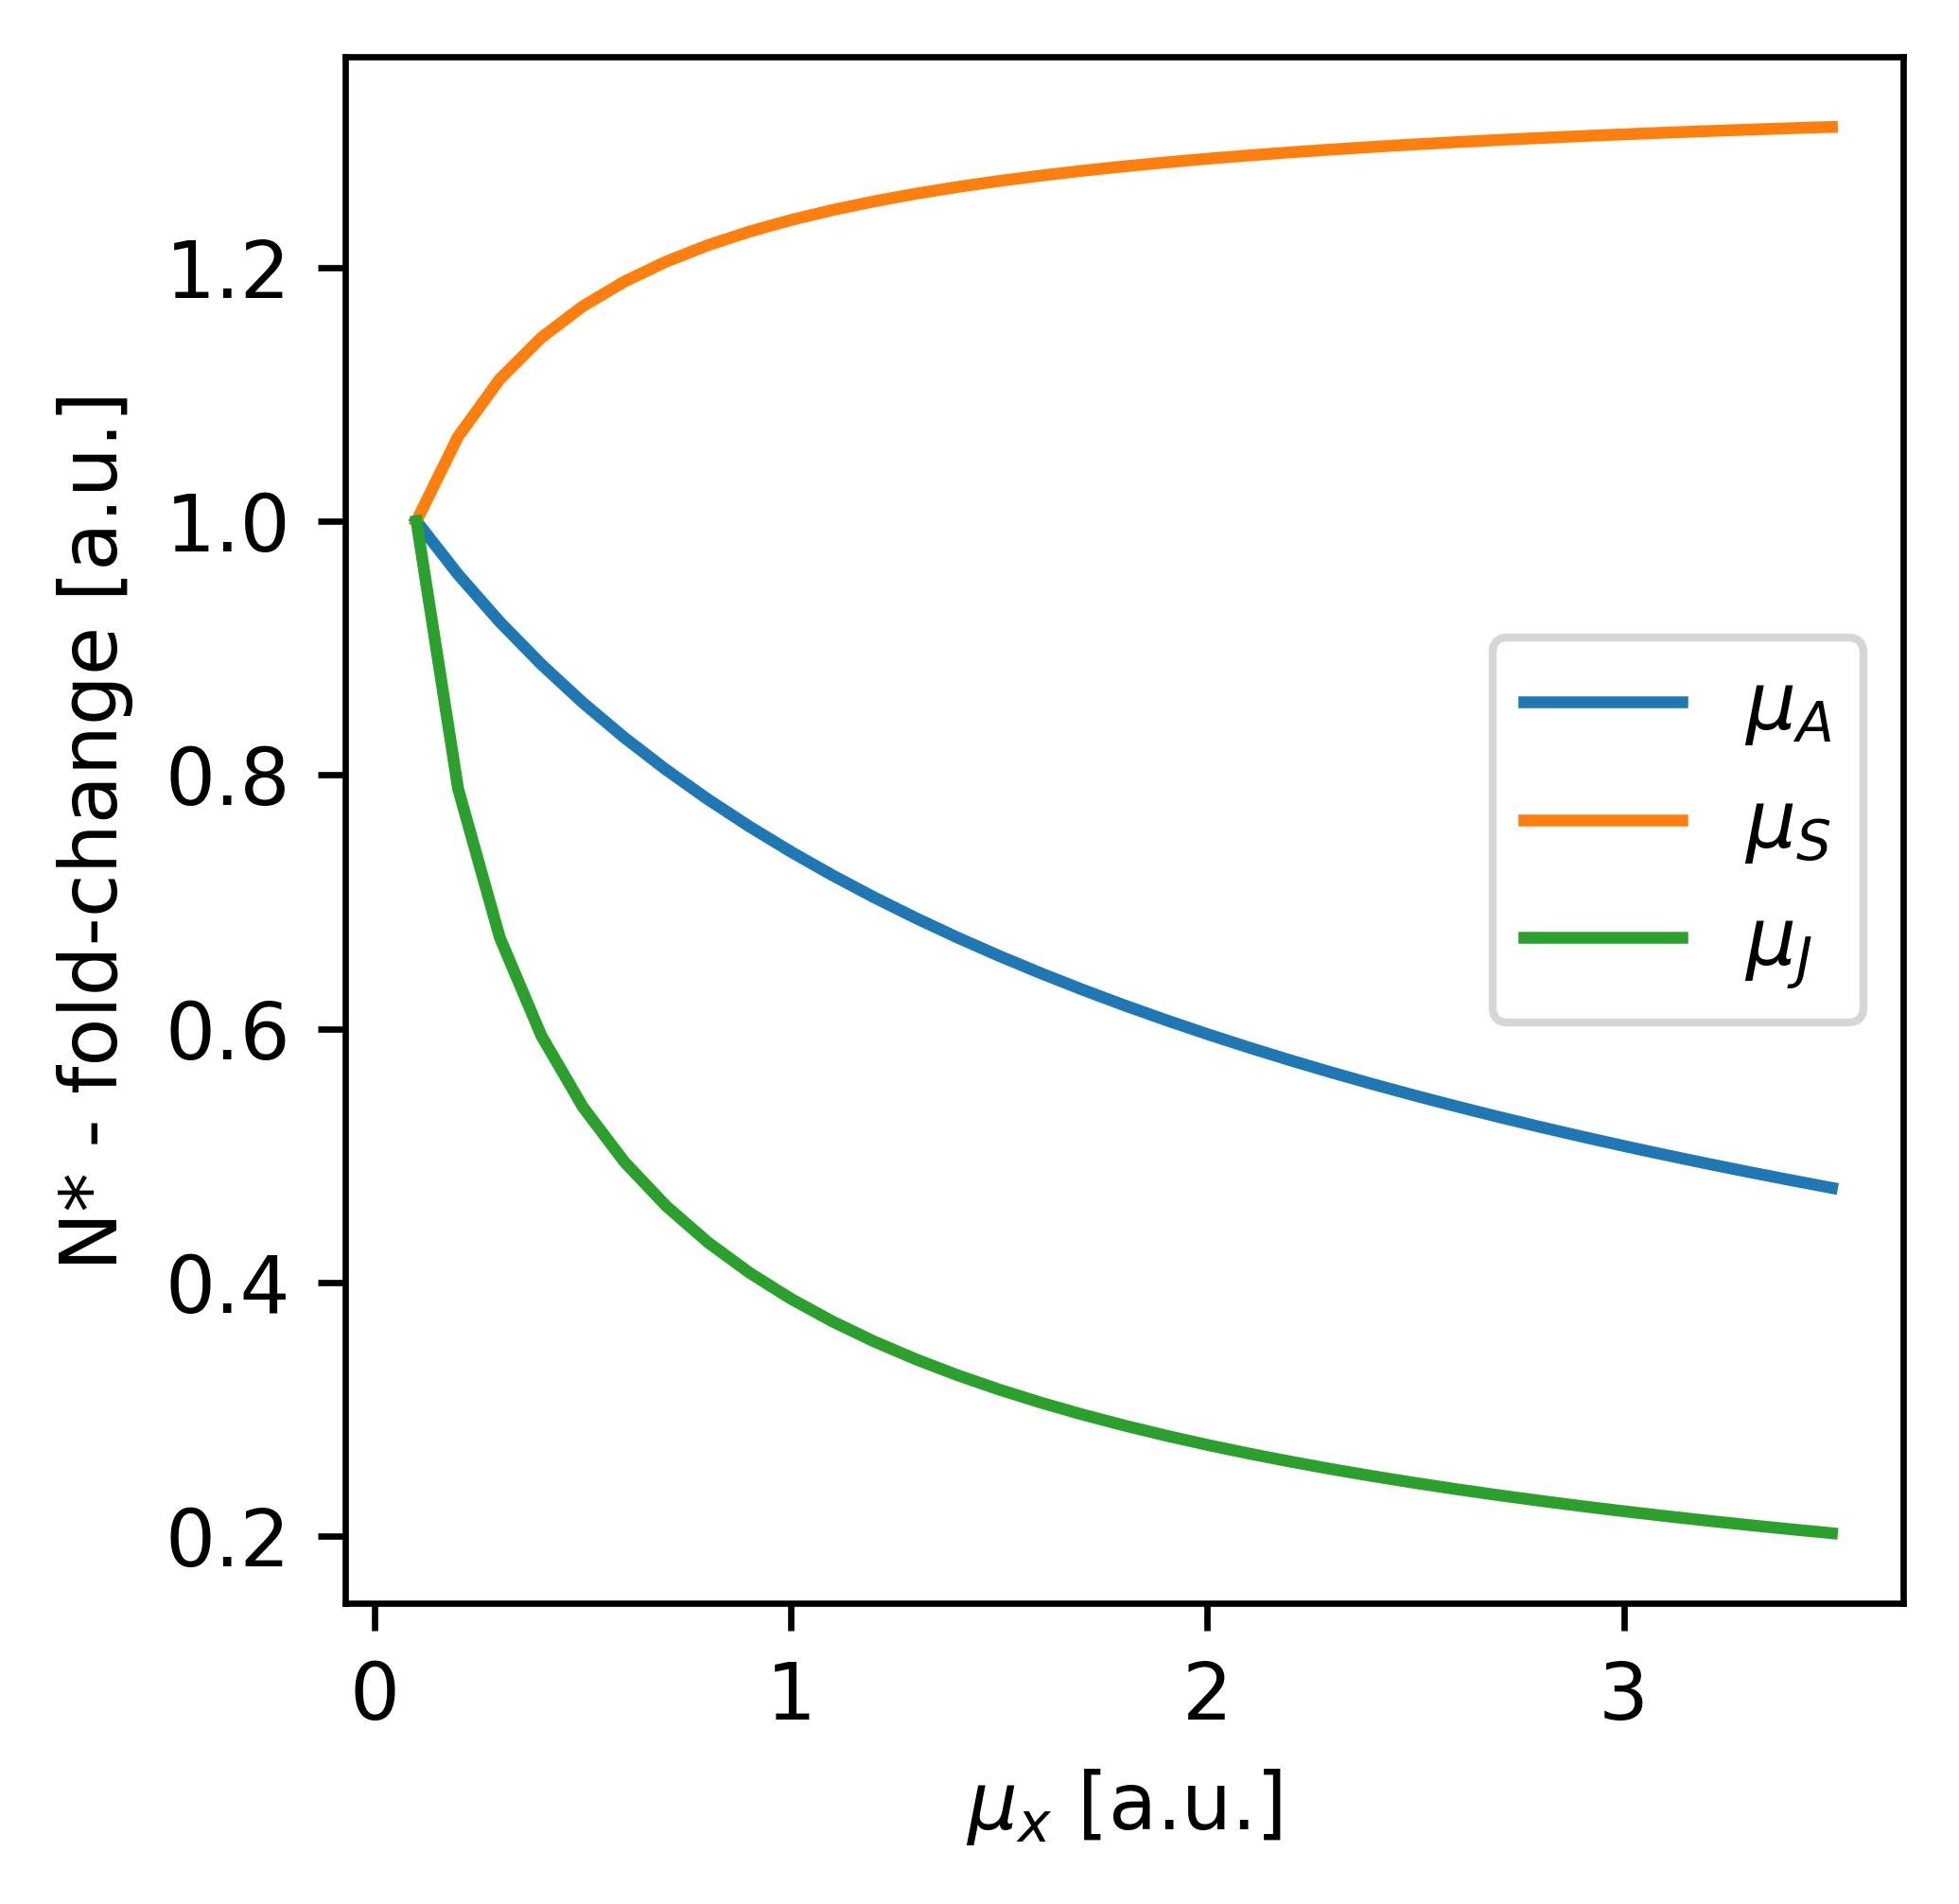

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$μ_{A}$')
dores.plot(mu_range, R_series, label='$μ_{S}$')
dores.plot(mu_range, G_series, label='$μ_{J}$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{x}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

## Fig. S9B

Forraging -  Cooperation benefiting juvenile consumption (α > 0, ω = 0, ρ = 0)

Cooperativiity increases juvenile (J) access to resources.

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 3.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 3.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 1.0
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$α_1$'] = 0
param['$α_2$'] = 0
mu_range, sim_B = function(system = MetaPopB, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$α_1$'] = 5
param['$α_2$'] = 5
_, sim_R = function(system = MetaPopB, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$α_1$'] = 10
param['$α_2$'] = 10
_, sim_G = function(system = MetaPopB, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

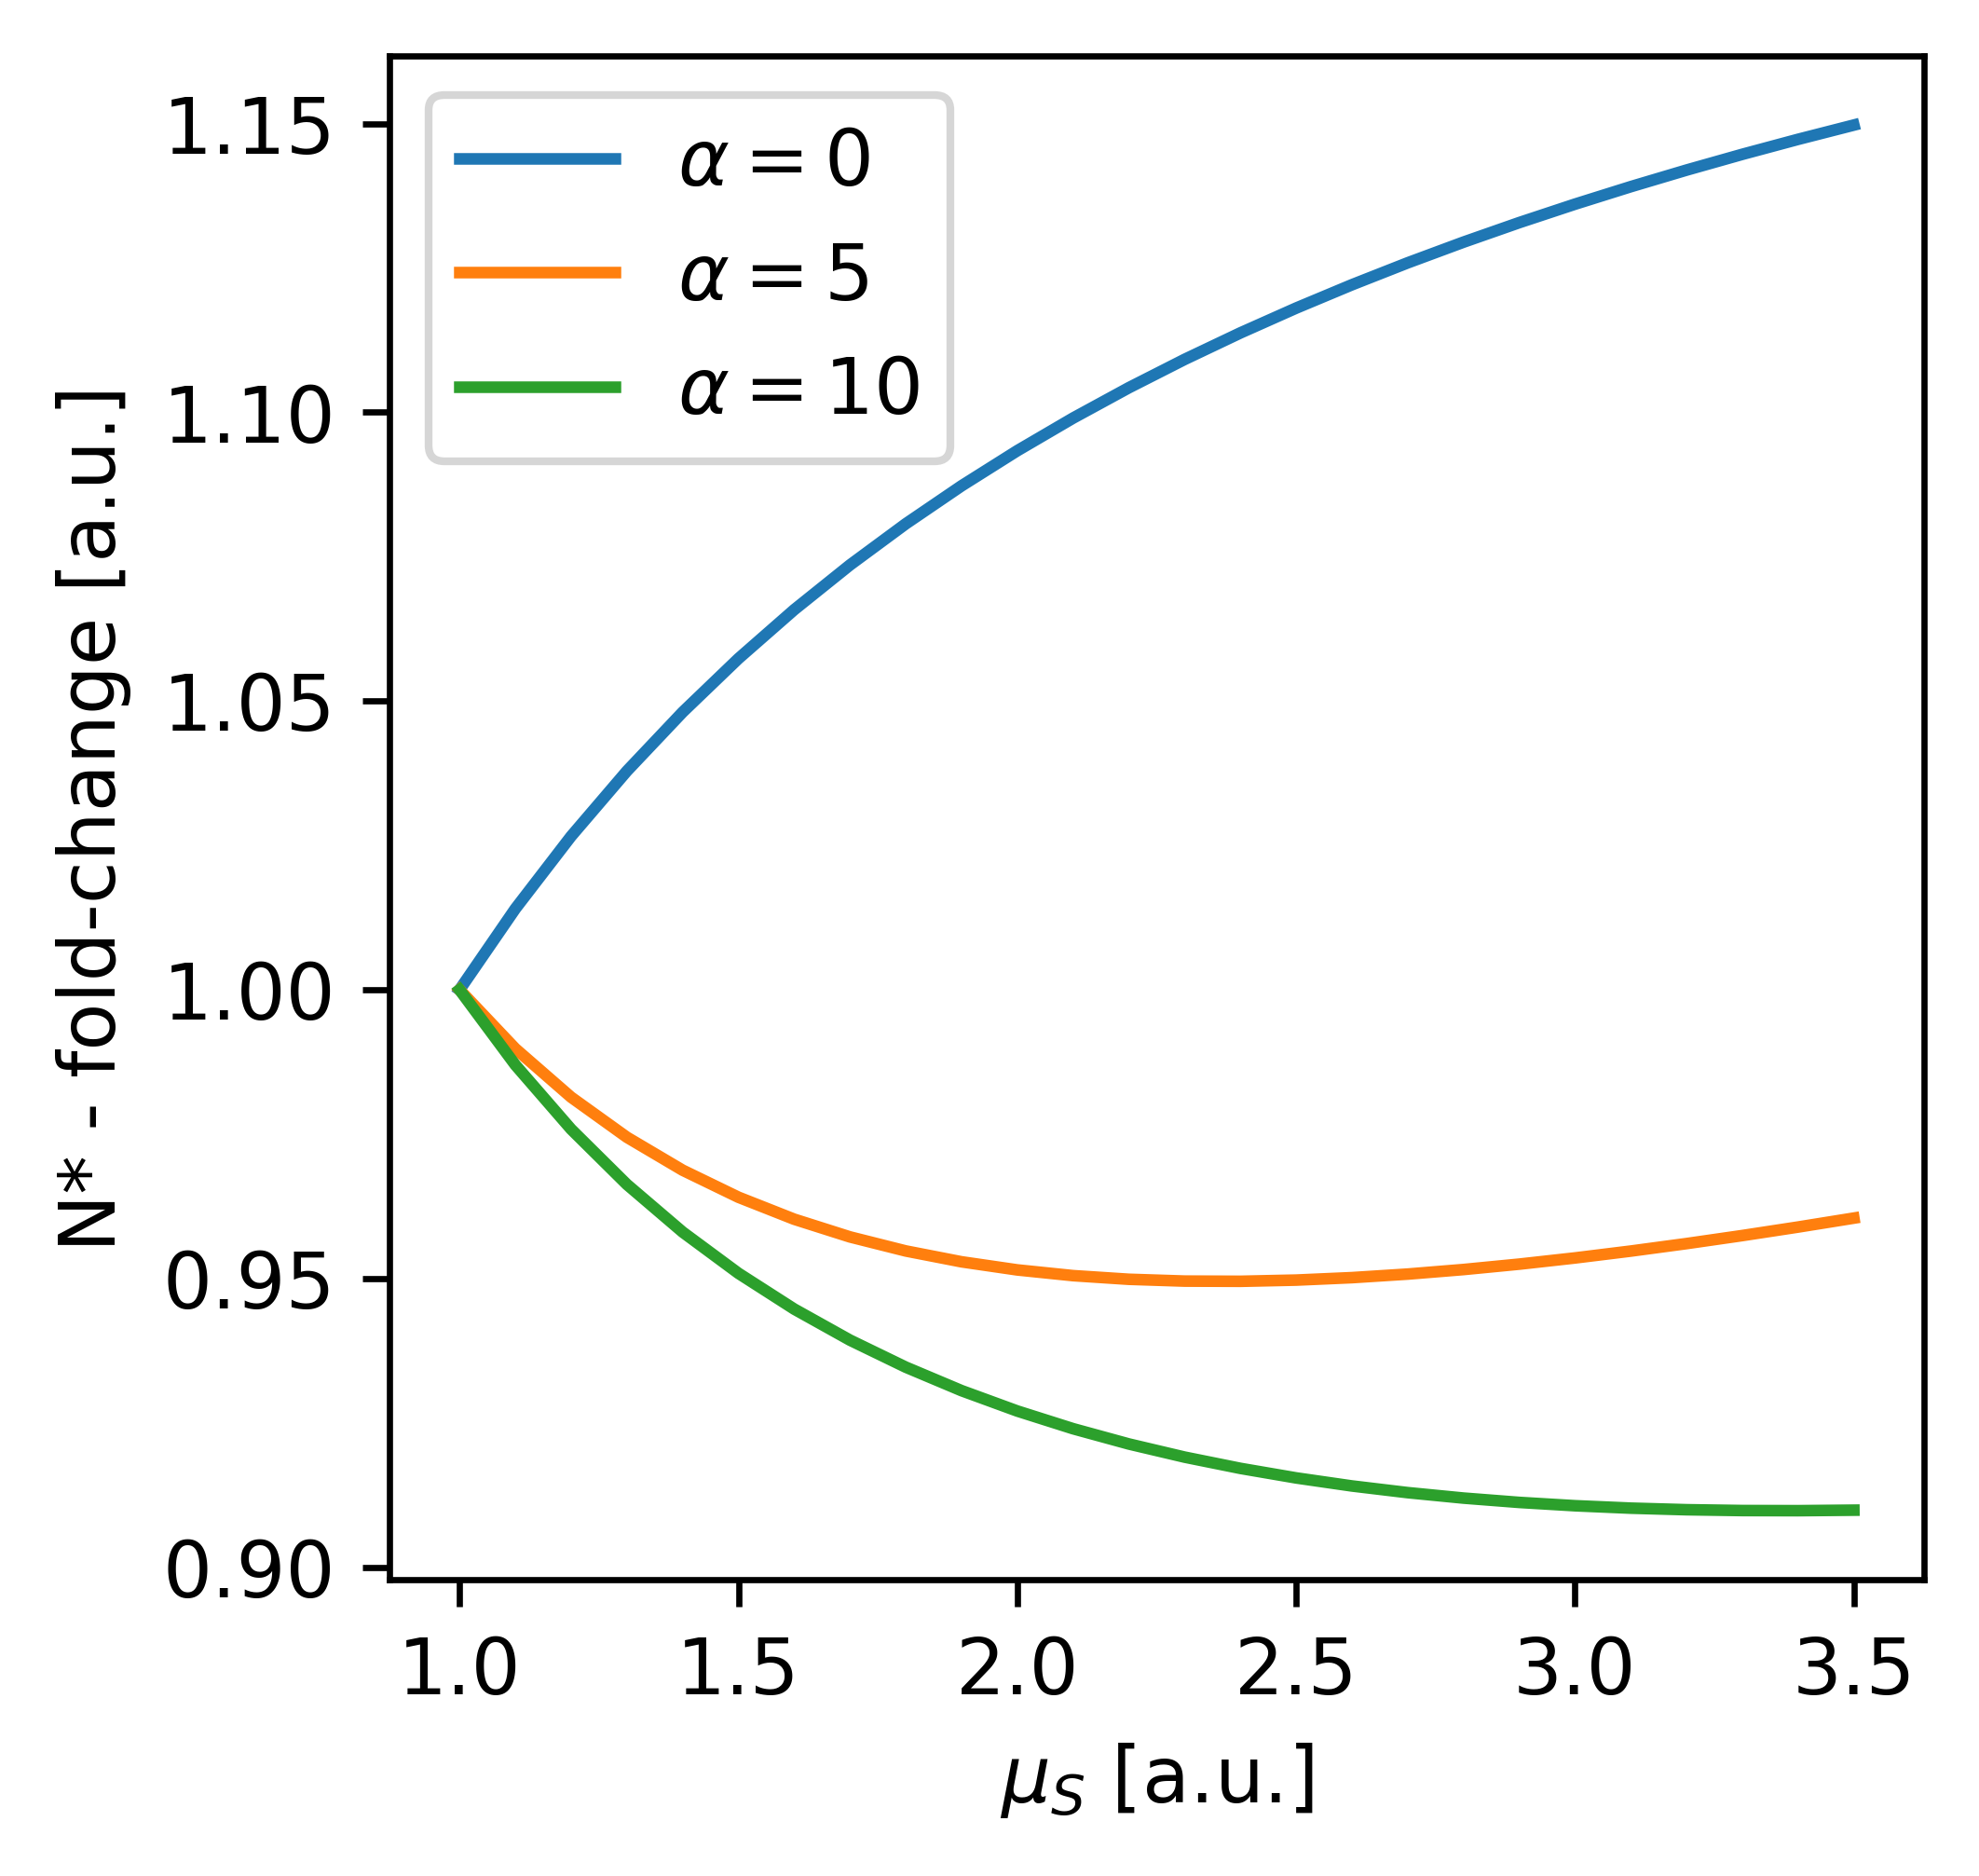

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$α = 0$')
dores.plot(mu_range, R_series, label='$α = 5$')
dores.plot(mu_range, G_series, label='$α = 10$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

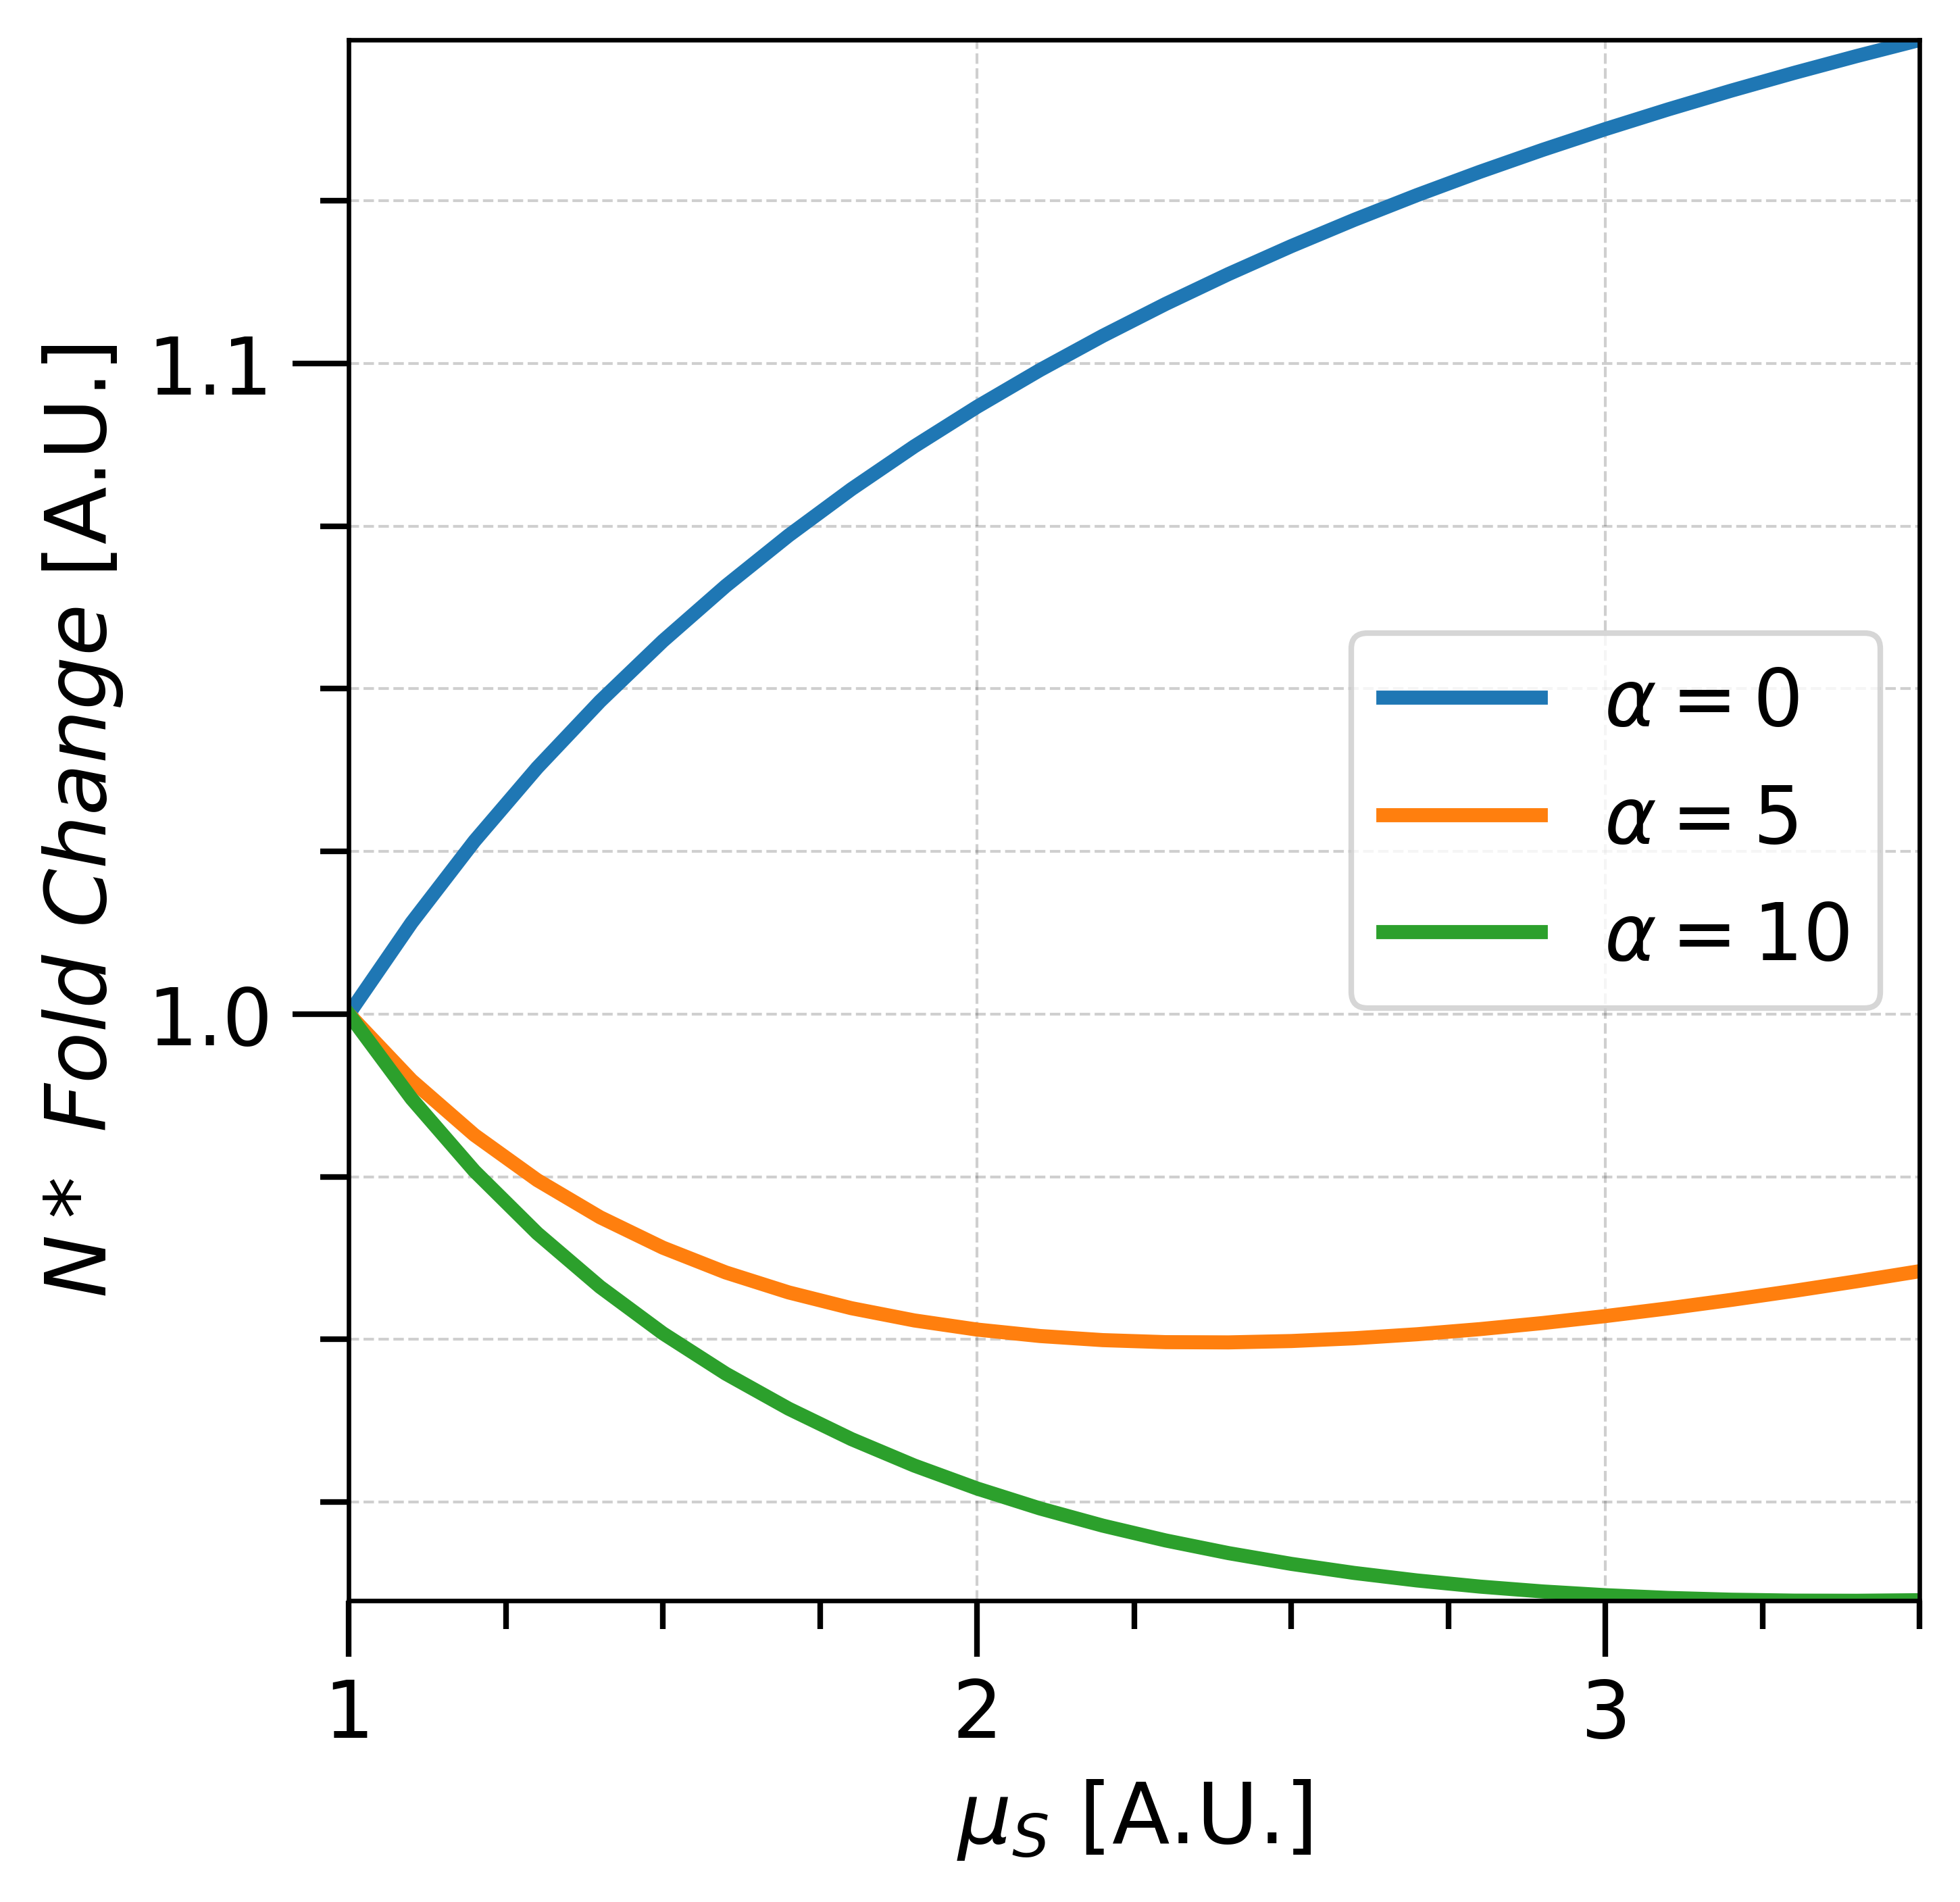

In [ ]:
#Second version of figure

figE9b = plt.figure(figsize=(5,5), dpi=600)

ax1  = figE9b.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(G_series), max(B_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.1))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$α = 0$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$α = 5$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$α = 10$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. S9C

Weaning - Cooperation benefiting adult fertility (α > 0, ω = 0, ρ = 0)

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 3.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 3.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 50.0
dt = t_fin/1000

#for control parameter range
start_mu = 1.0
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$α_1$'] = 0
param['$α_2$'] = 0
mu_range, sim_B = function(system = MetaPopD, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$α_1$'] = 1
param['$α_2$'] = 1
_, sim_R = function(system = MetaPopD, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$α_1$'] = 2
param['$α_2$'] = 2
_, sim_G = function(system = MetaPopD, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

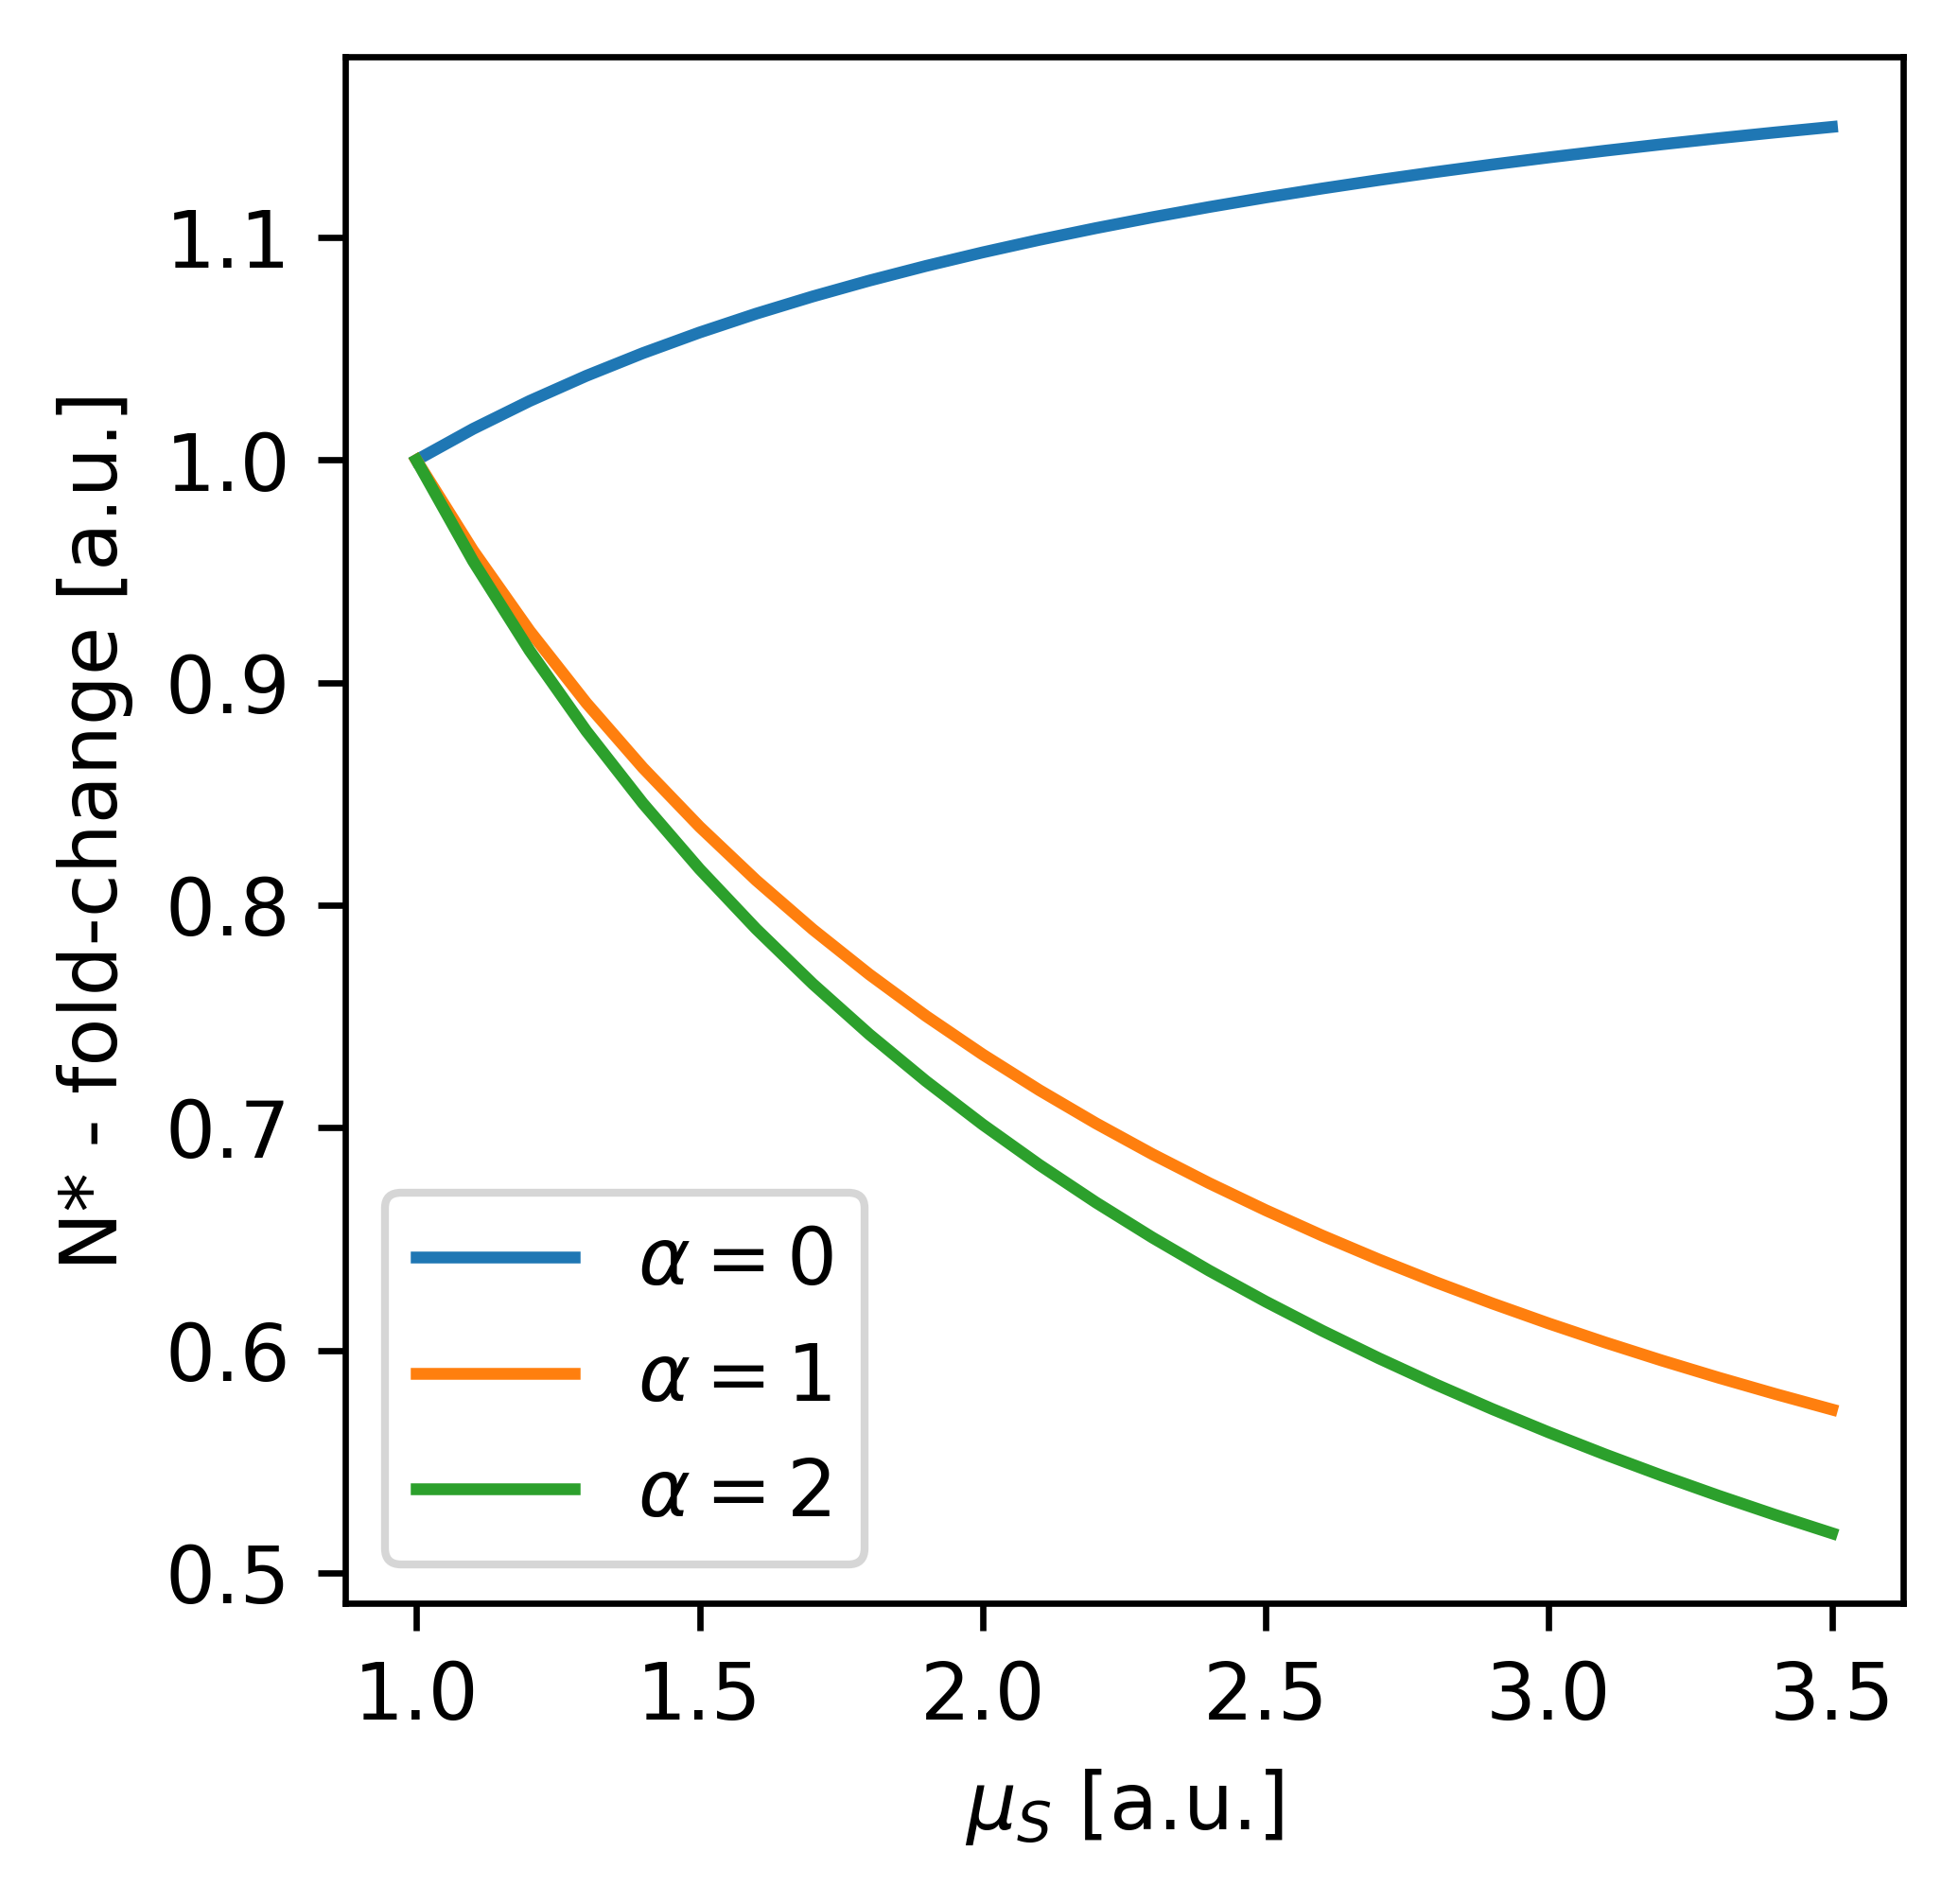

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$α = 0$')
dores.plot(mu_range, R_series, label='$α = 1$')
dores.plot(mu_range, G_series, label='$α = 2$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

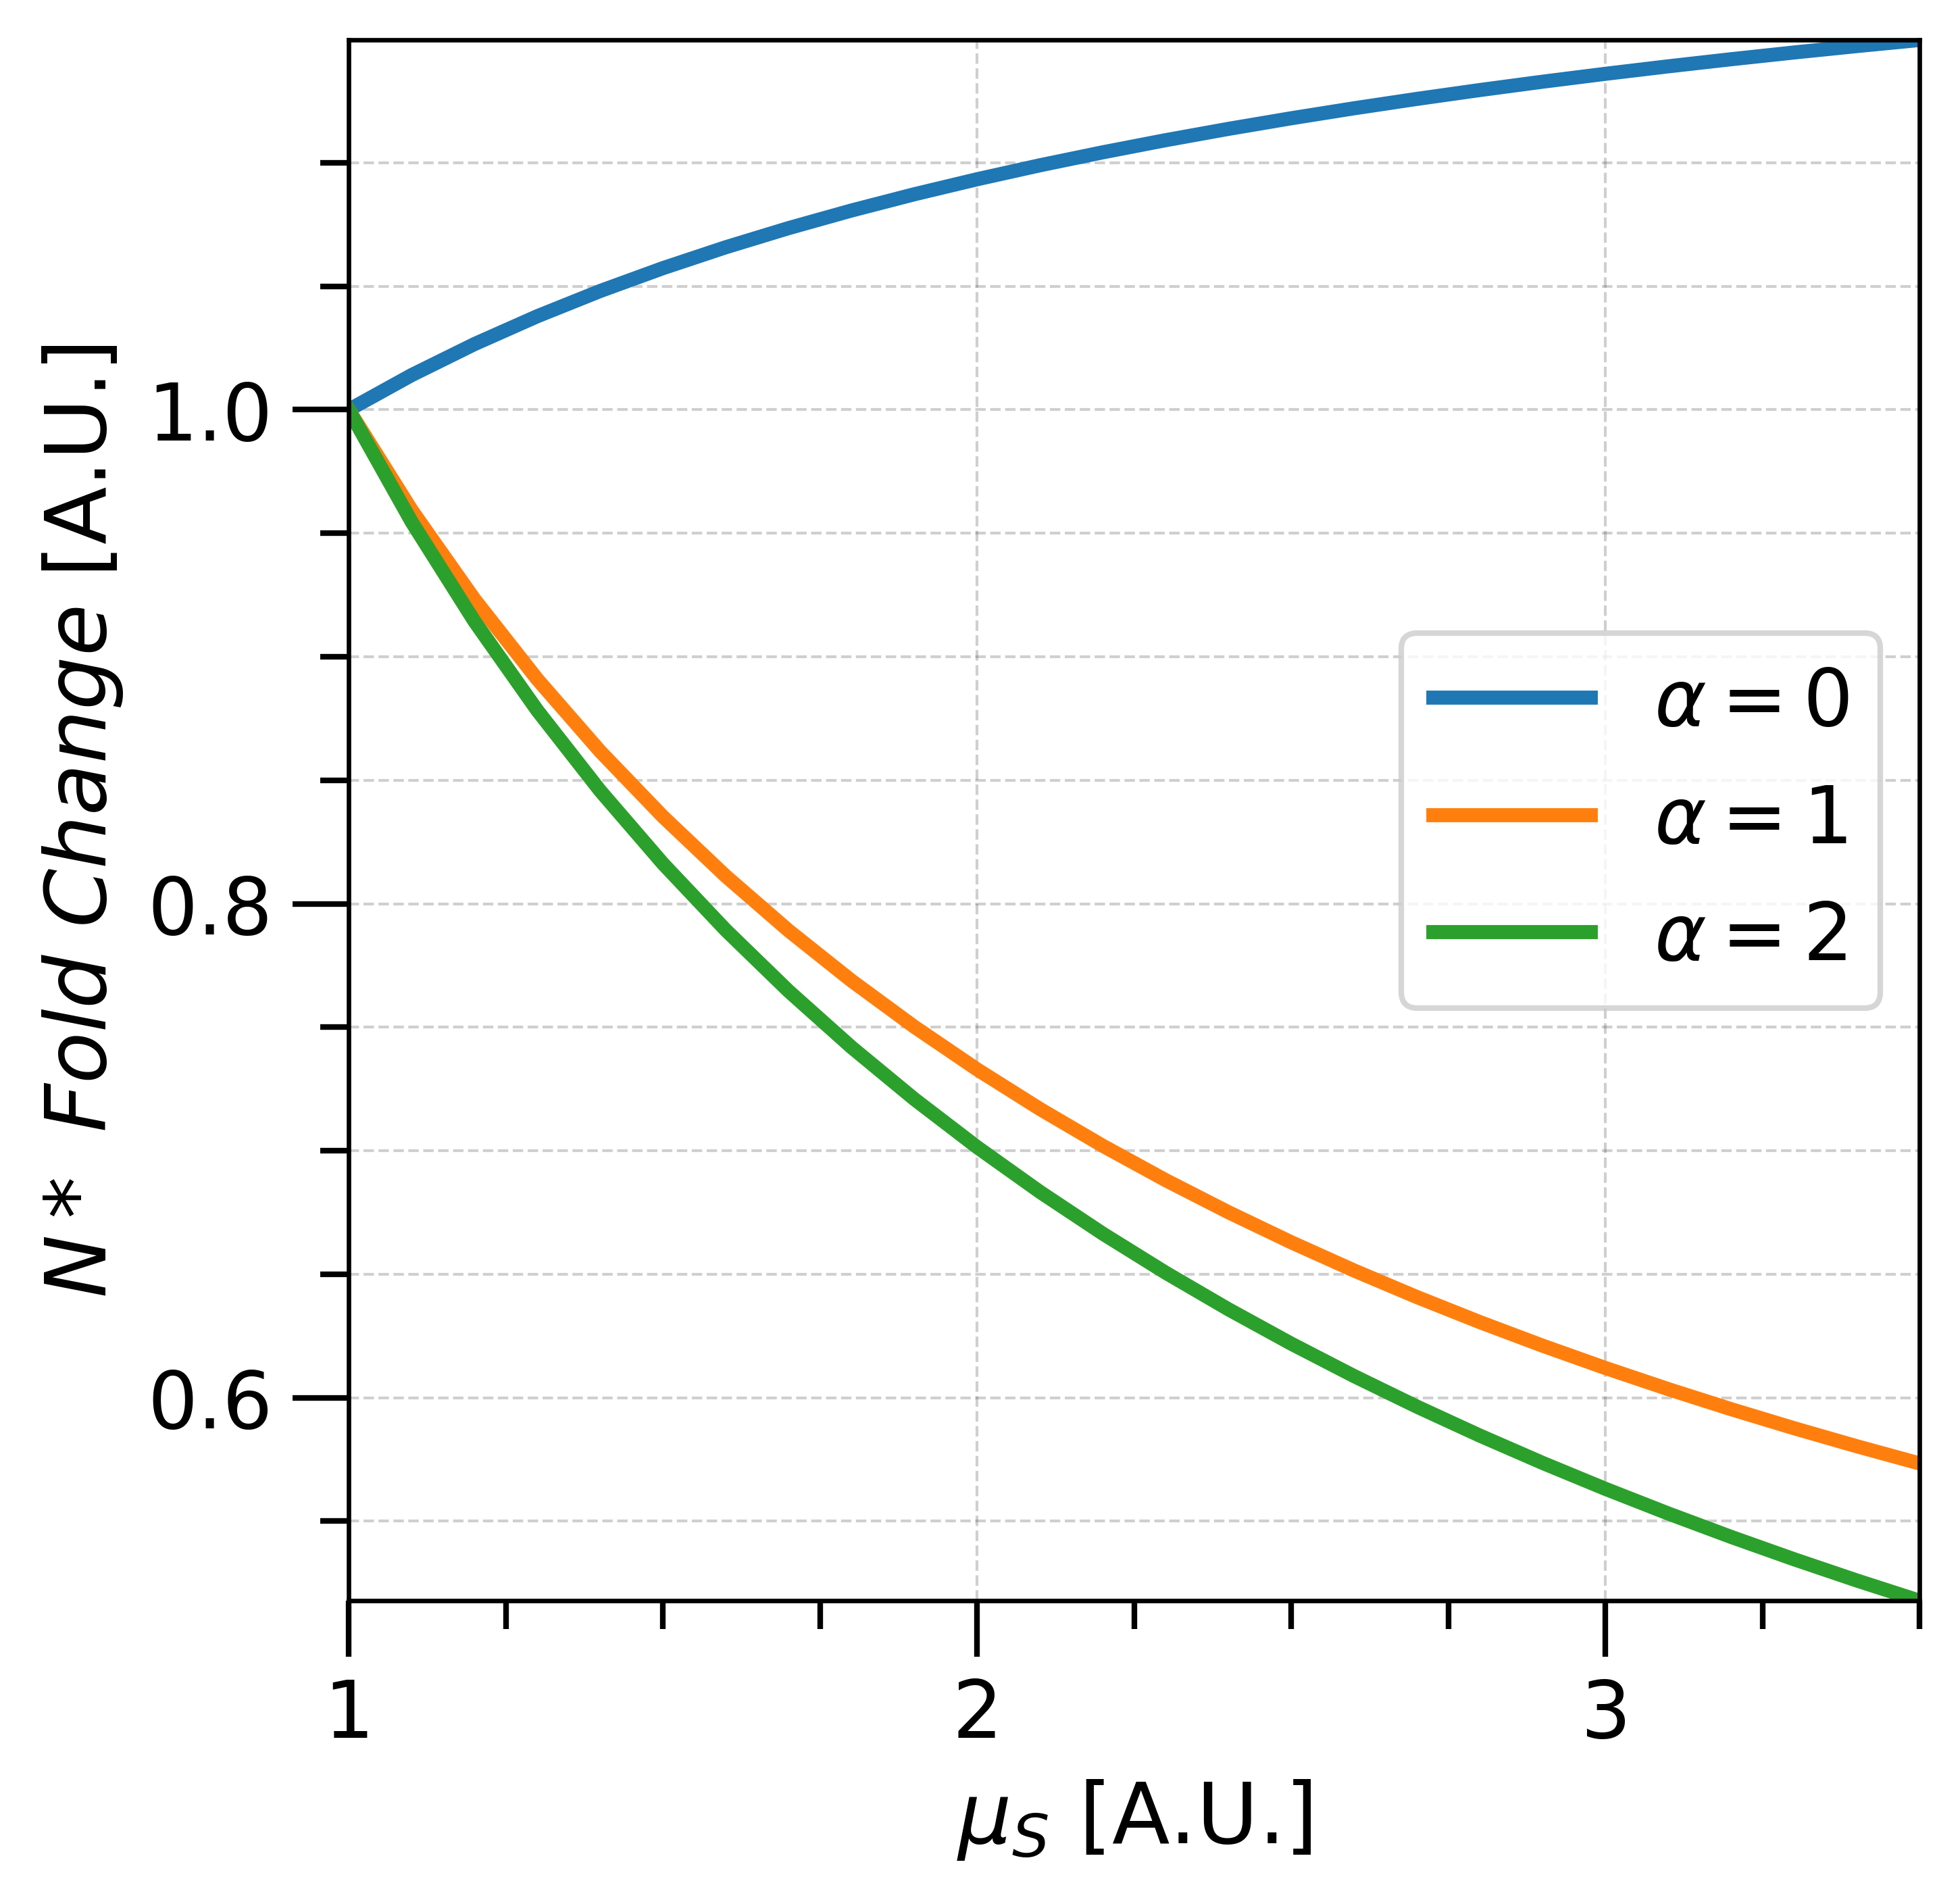

In [ ]:
#Second version of figure

figE9c = plt.figure(figsize=(5,5), dpi=600)

ax1  = figE9c.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(G_series), max(B_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.2))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$α = 0$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$α = 1$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$α = 2$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. S9D

Rearing - Cooperation benefiting juvenile maturation (α > 0, ω = 0, ρ = 0)

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 1.5, 1.5 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 10, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 1.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 2, 0.0 # mortality rates for both types of juveniles
ma1 = 2 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 50.0
dt = t_fin/1000

#for control parameter range
start_mu = 0.5
end_mu =10.6
step_mu = 0.1


In [ ]:
param['$α_1$'] = 0.0
param['$α_2$'] = 0.0
mu_range, sim_B = function(system = MetaPopC, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$α_1$'] = 0.5
param['$α_2$'] = 0.5
_, sim_R = function(system = MetaPopC, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$α_1$'] = 1.0
param['$α_2$'] = 1.0
_, sim_G = function(system = MetaPopC, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

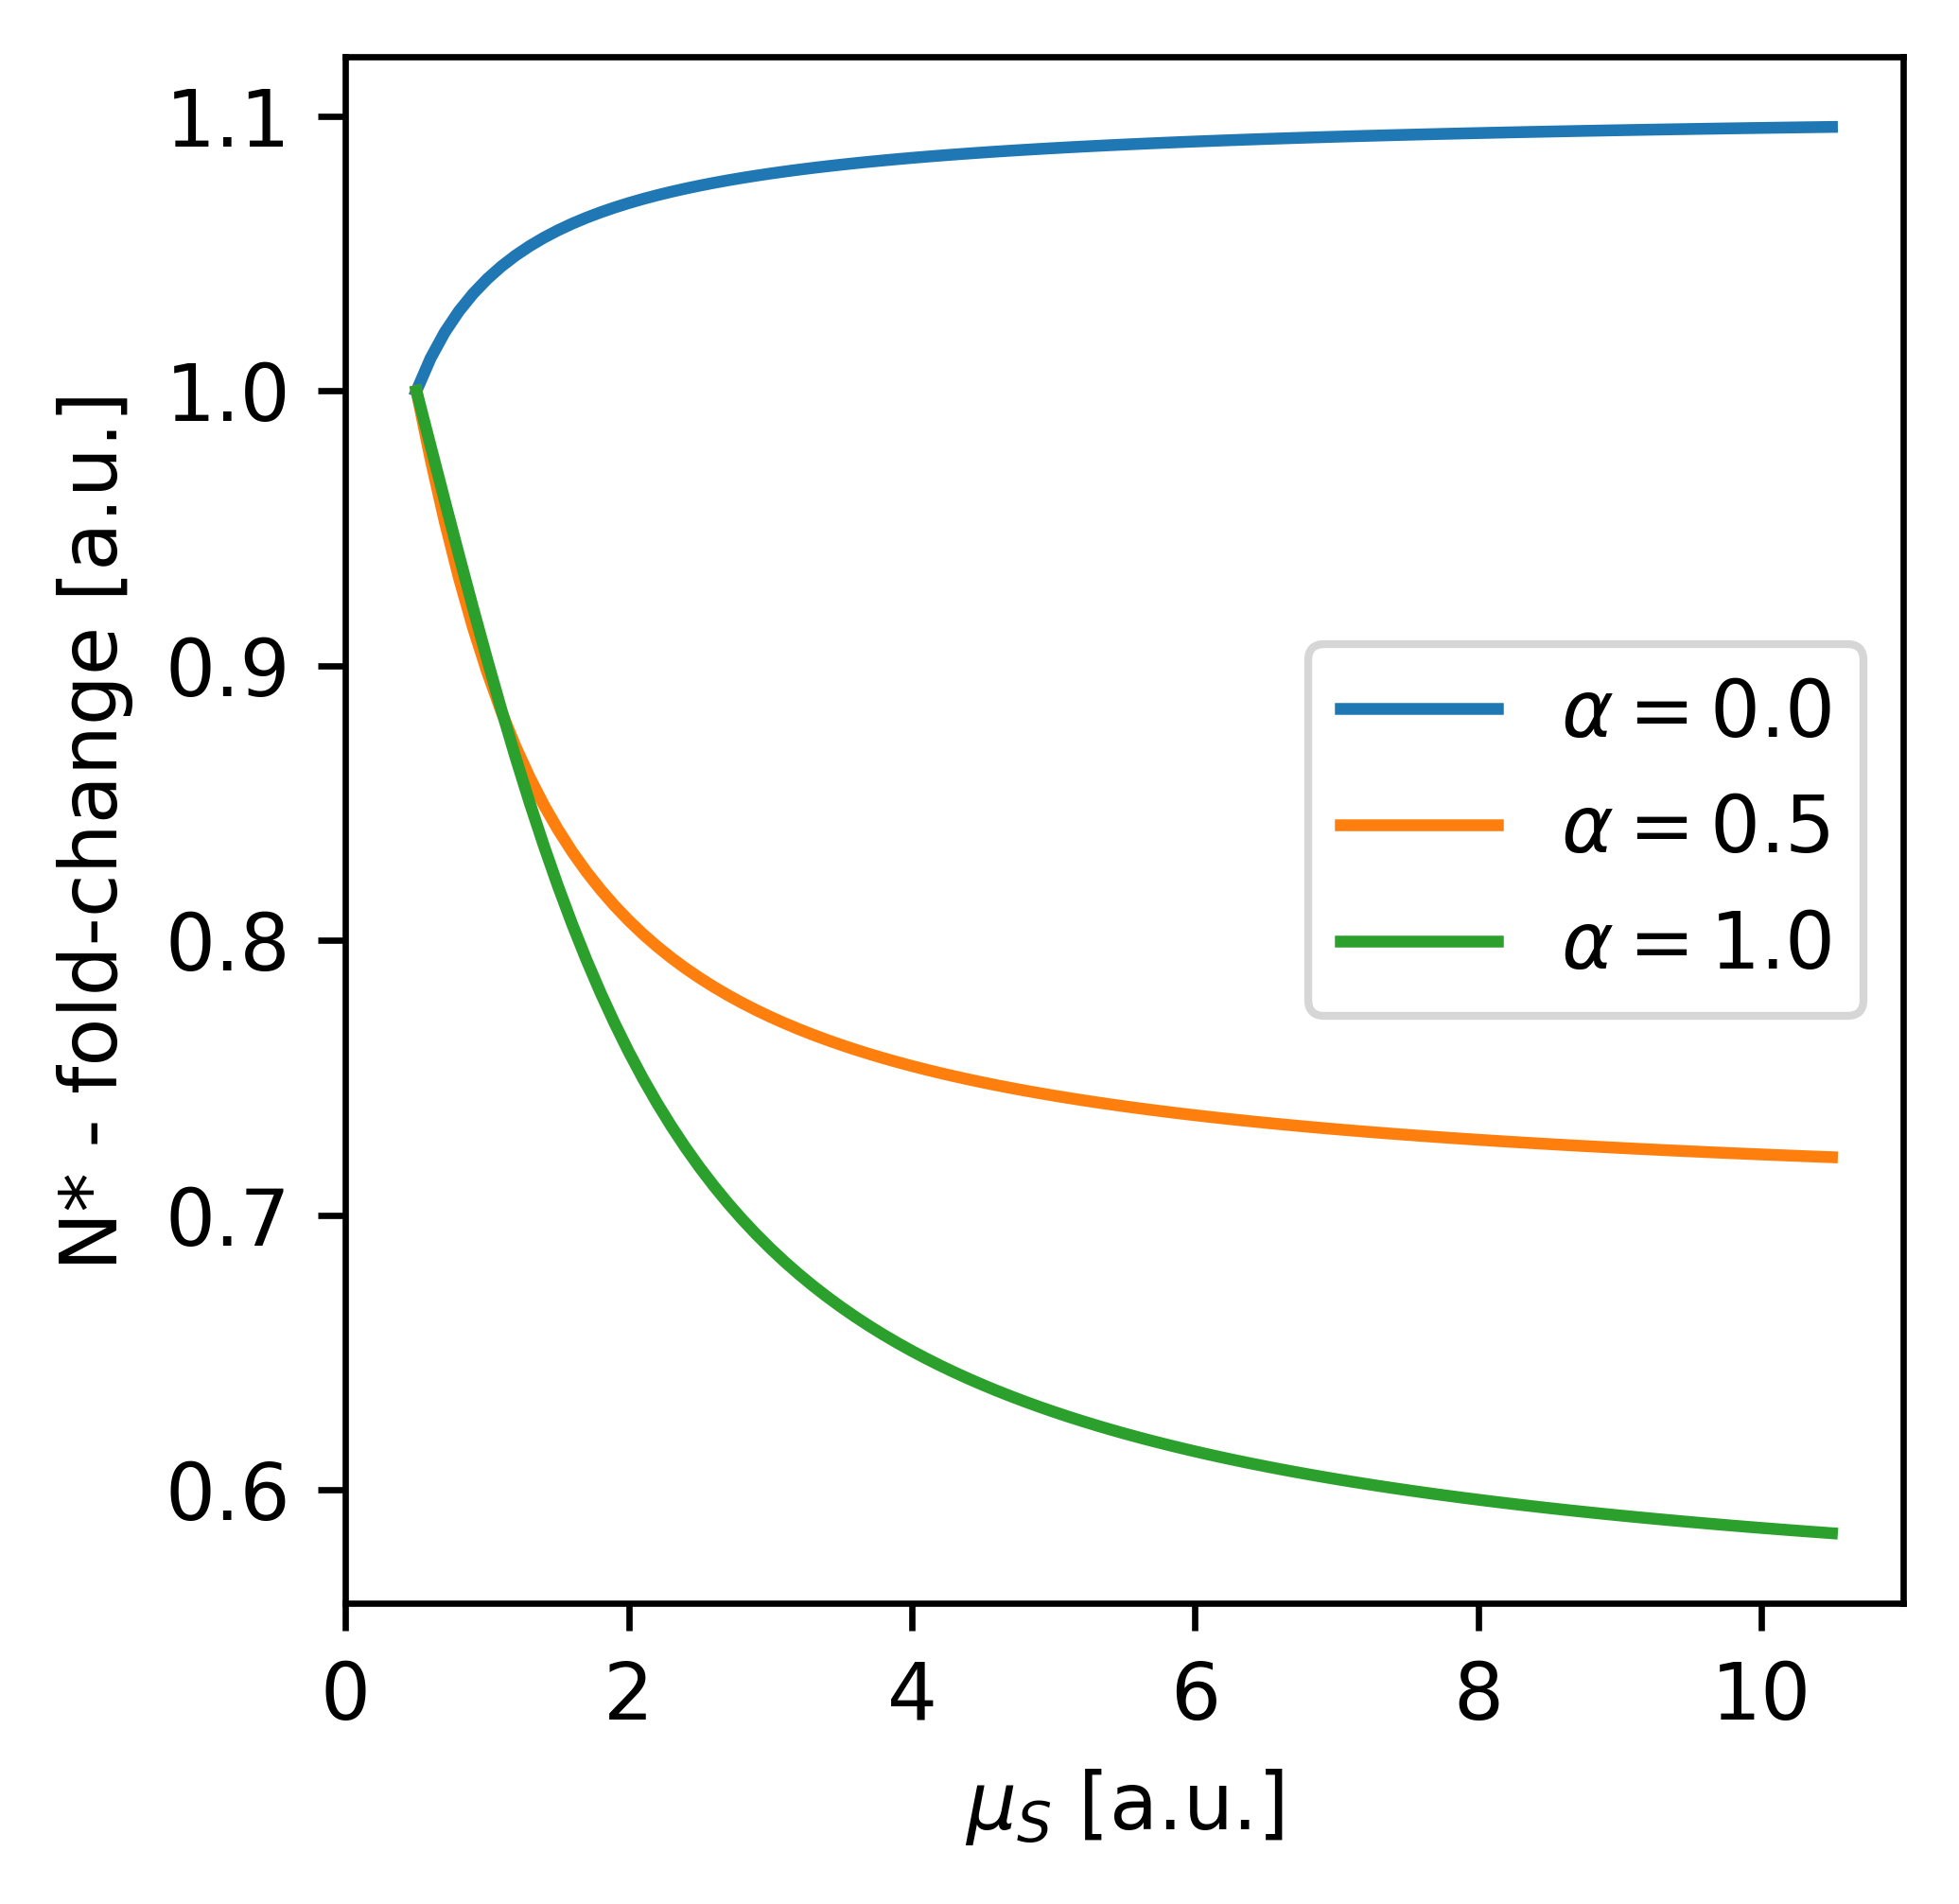

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$α = 0.0$')
dores.plot(mu_range, R_series, label='$α = 0.5$')
dores.plot(mu_range, G_series, label='$α = 1.0$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

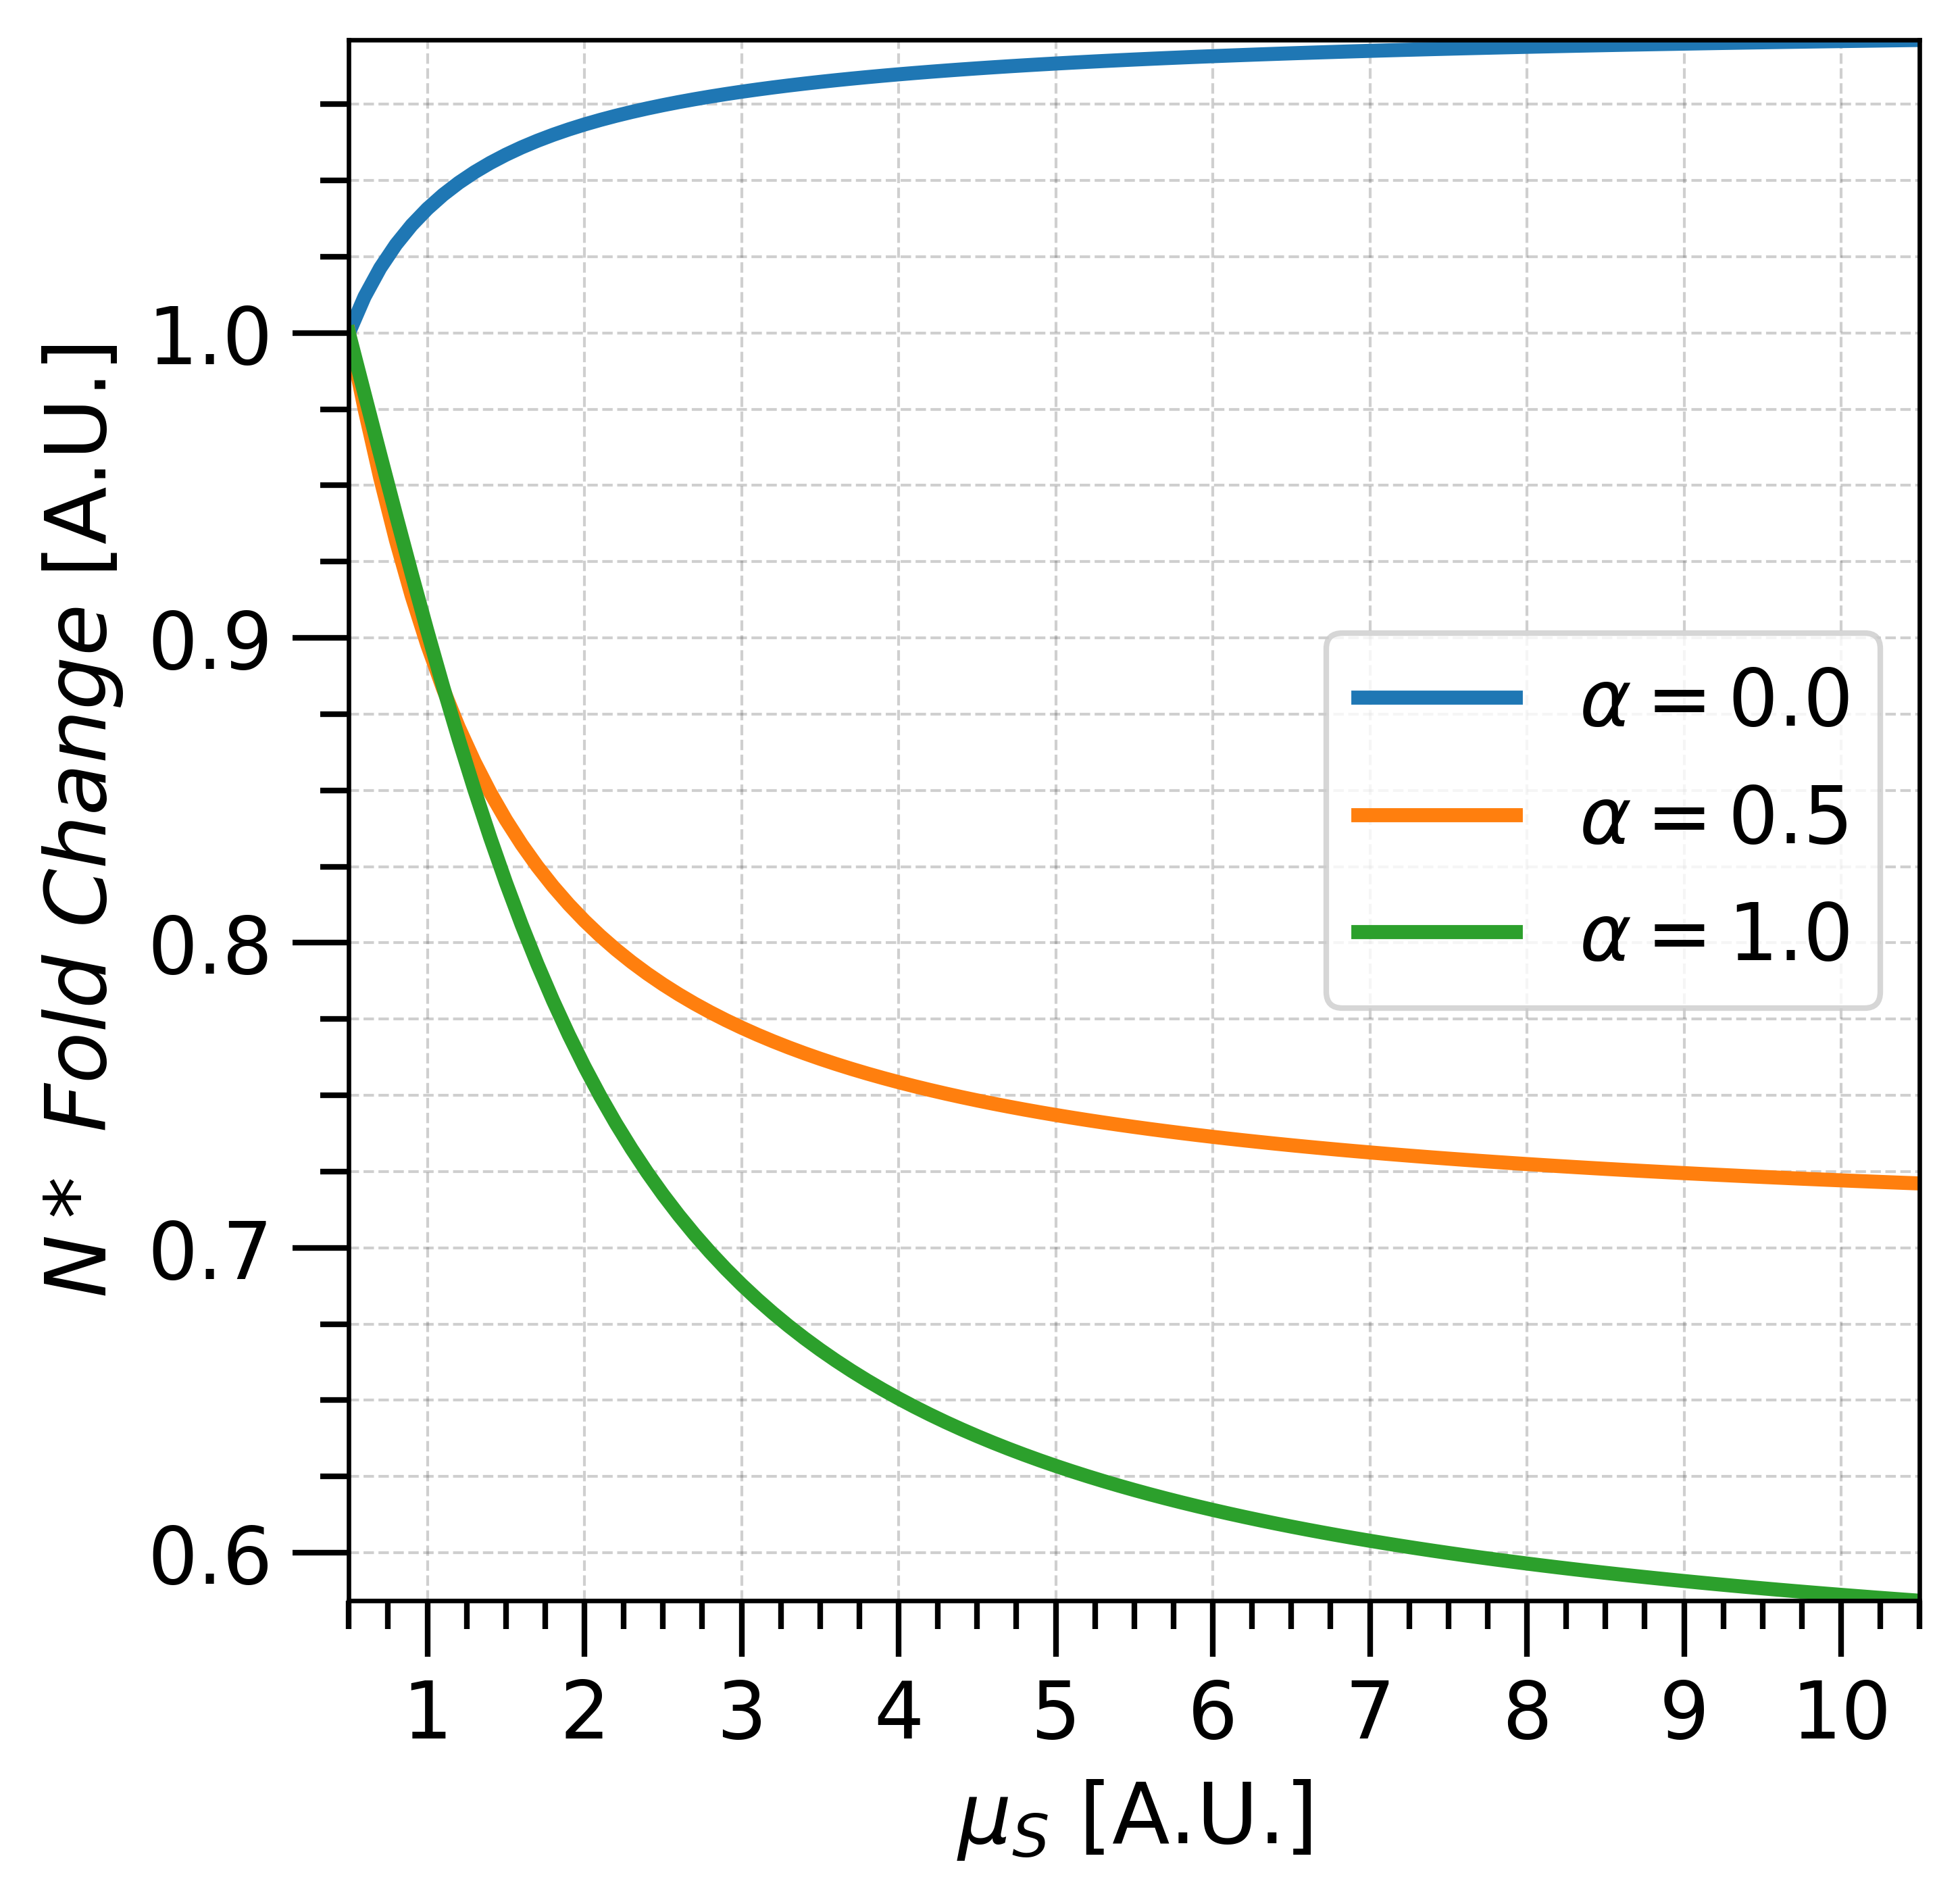

In [ ]:
#Second version of figure

figE9d = plt.figure(figsize=(5,5), dpi=600)

ax1  = figE9d.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(G_series), max(B_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.1))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$α = 0.0$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$α = 0.5$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$α = 1.0$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. S10A

 The parameter ω is the ability of senior individuals (S) to impair adult (A) reproductive efficiency

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 1.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 3.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 1.0
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$ω_1$'] = 0.0
param['$ω_2$'] = 0.0
mu_range, sim_B = function(system = MetaPopD, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$ω_1$'] = 1.0
param['$ω_2$'] = 1.0
_, sim_R = function(system = MetaPopD, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$ω_1$'] = 2.0
param['$ω_2$'] = 2.0
_, sim_G = function(system = MetaPopD, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

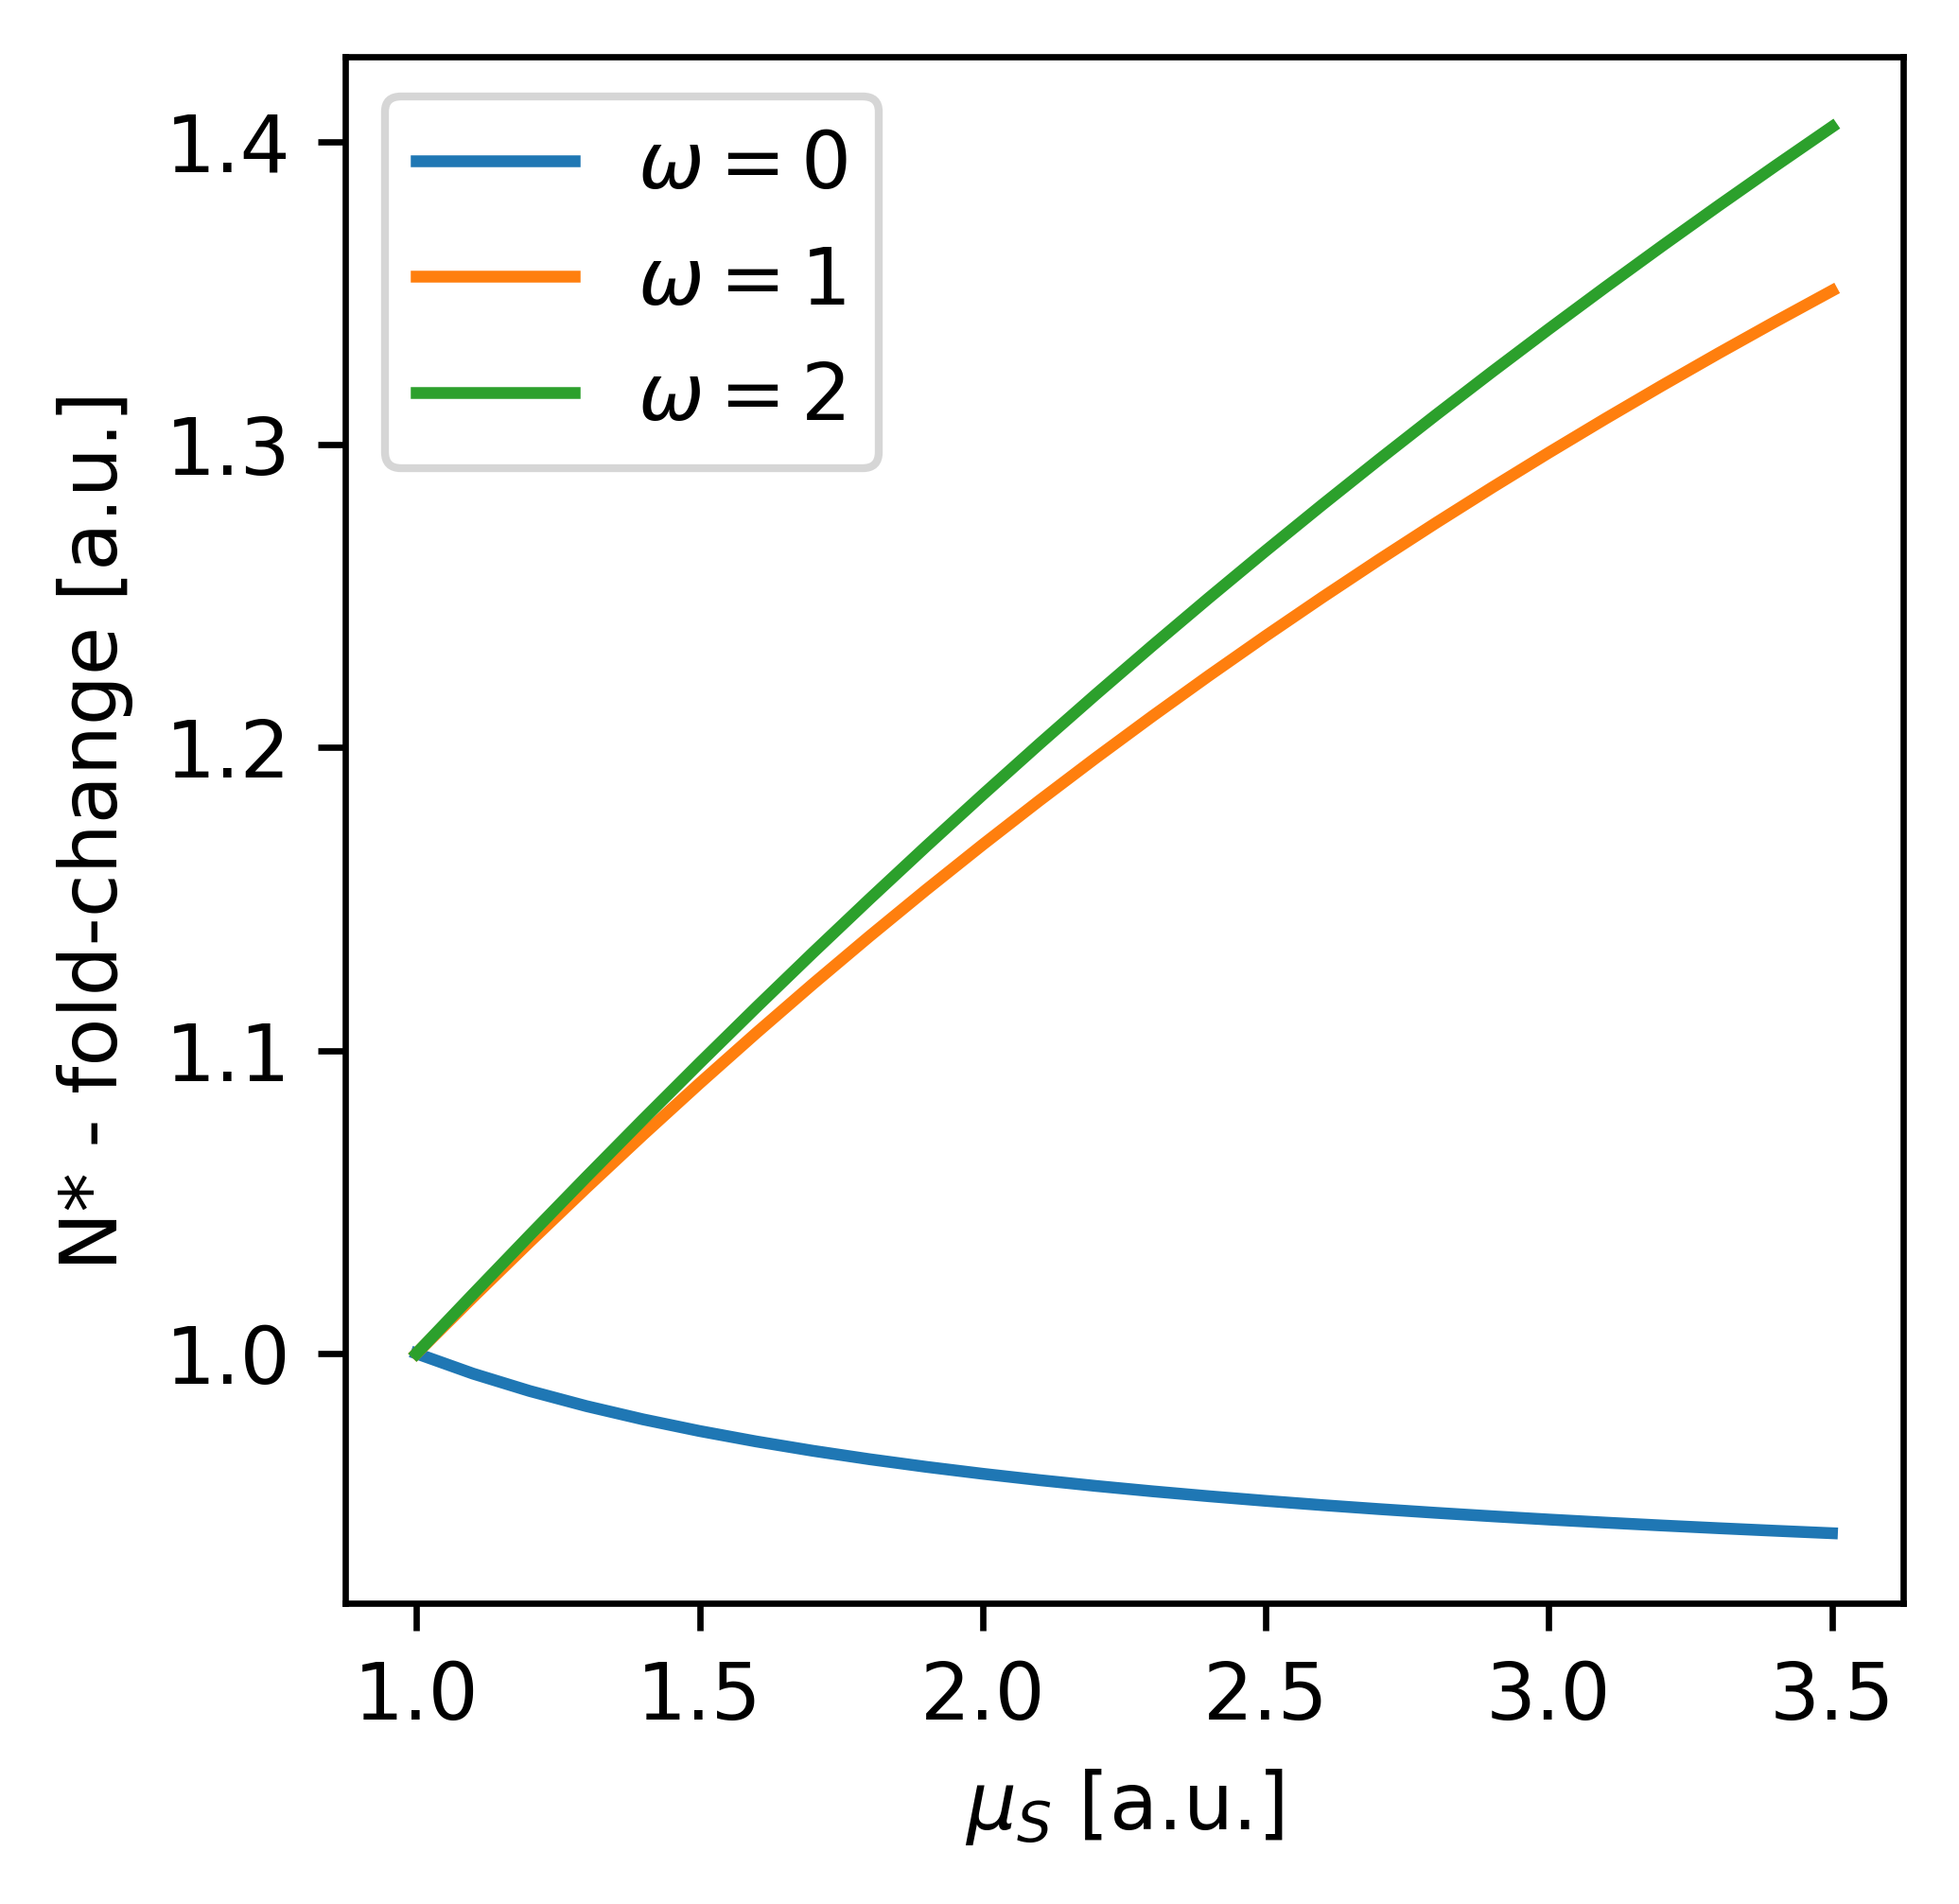

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$ω = 0$')
dores.plot(mu_range, R_series, label='$ω = 1$')
dores.plot(mu_range, G_series, label='$ω = 2$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

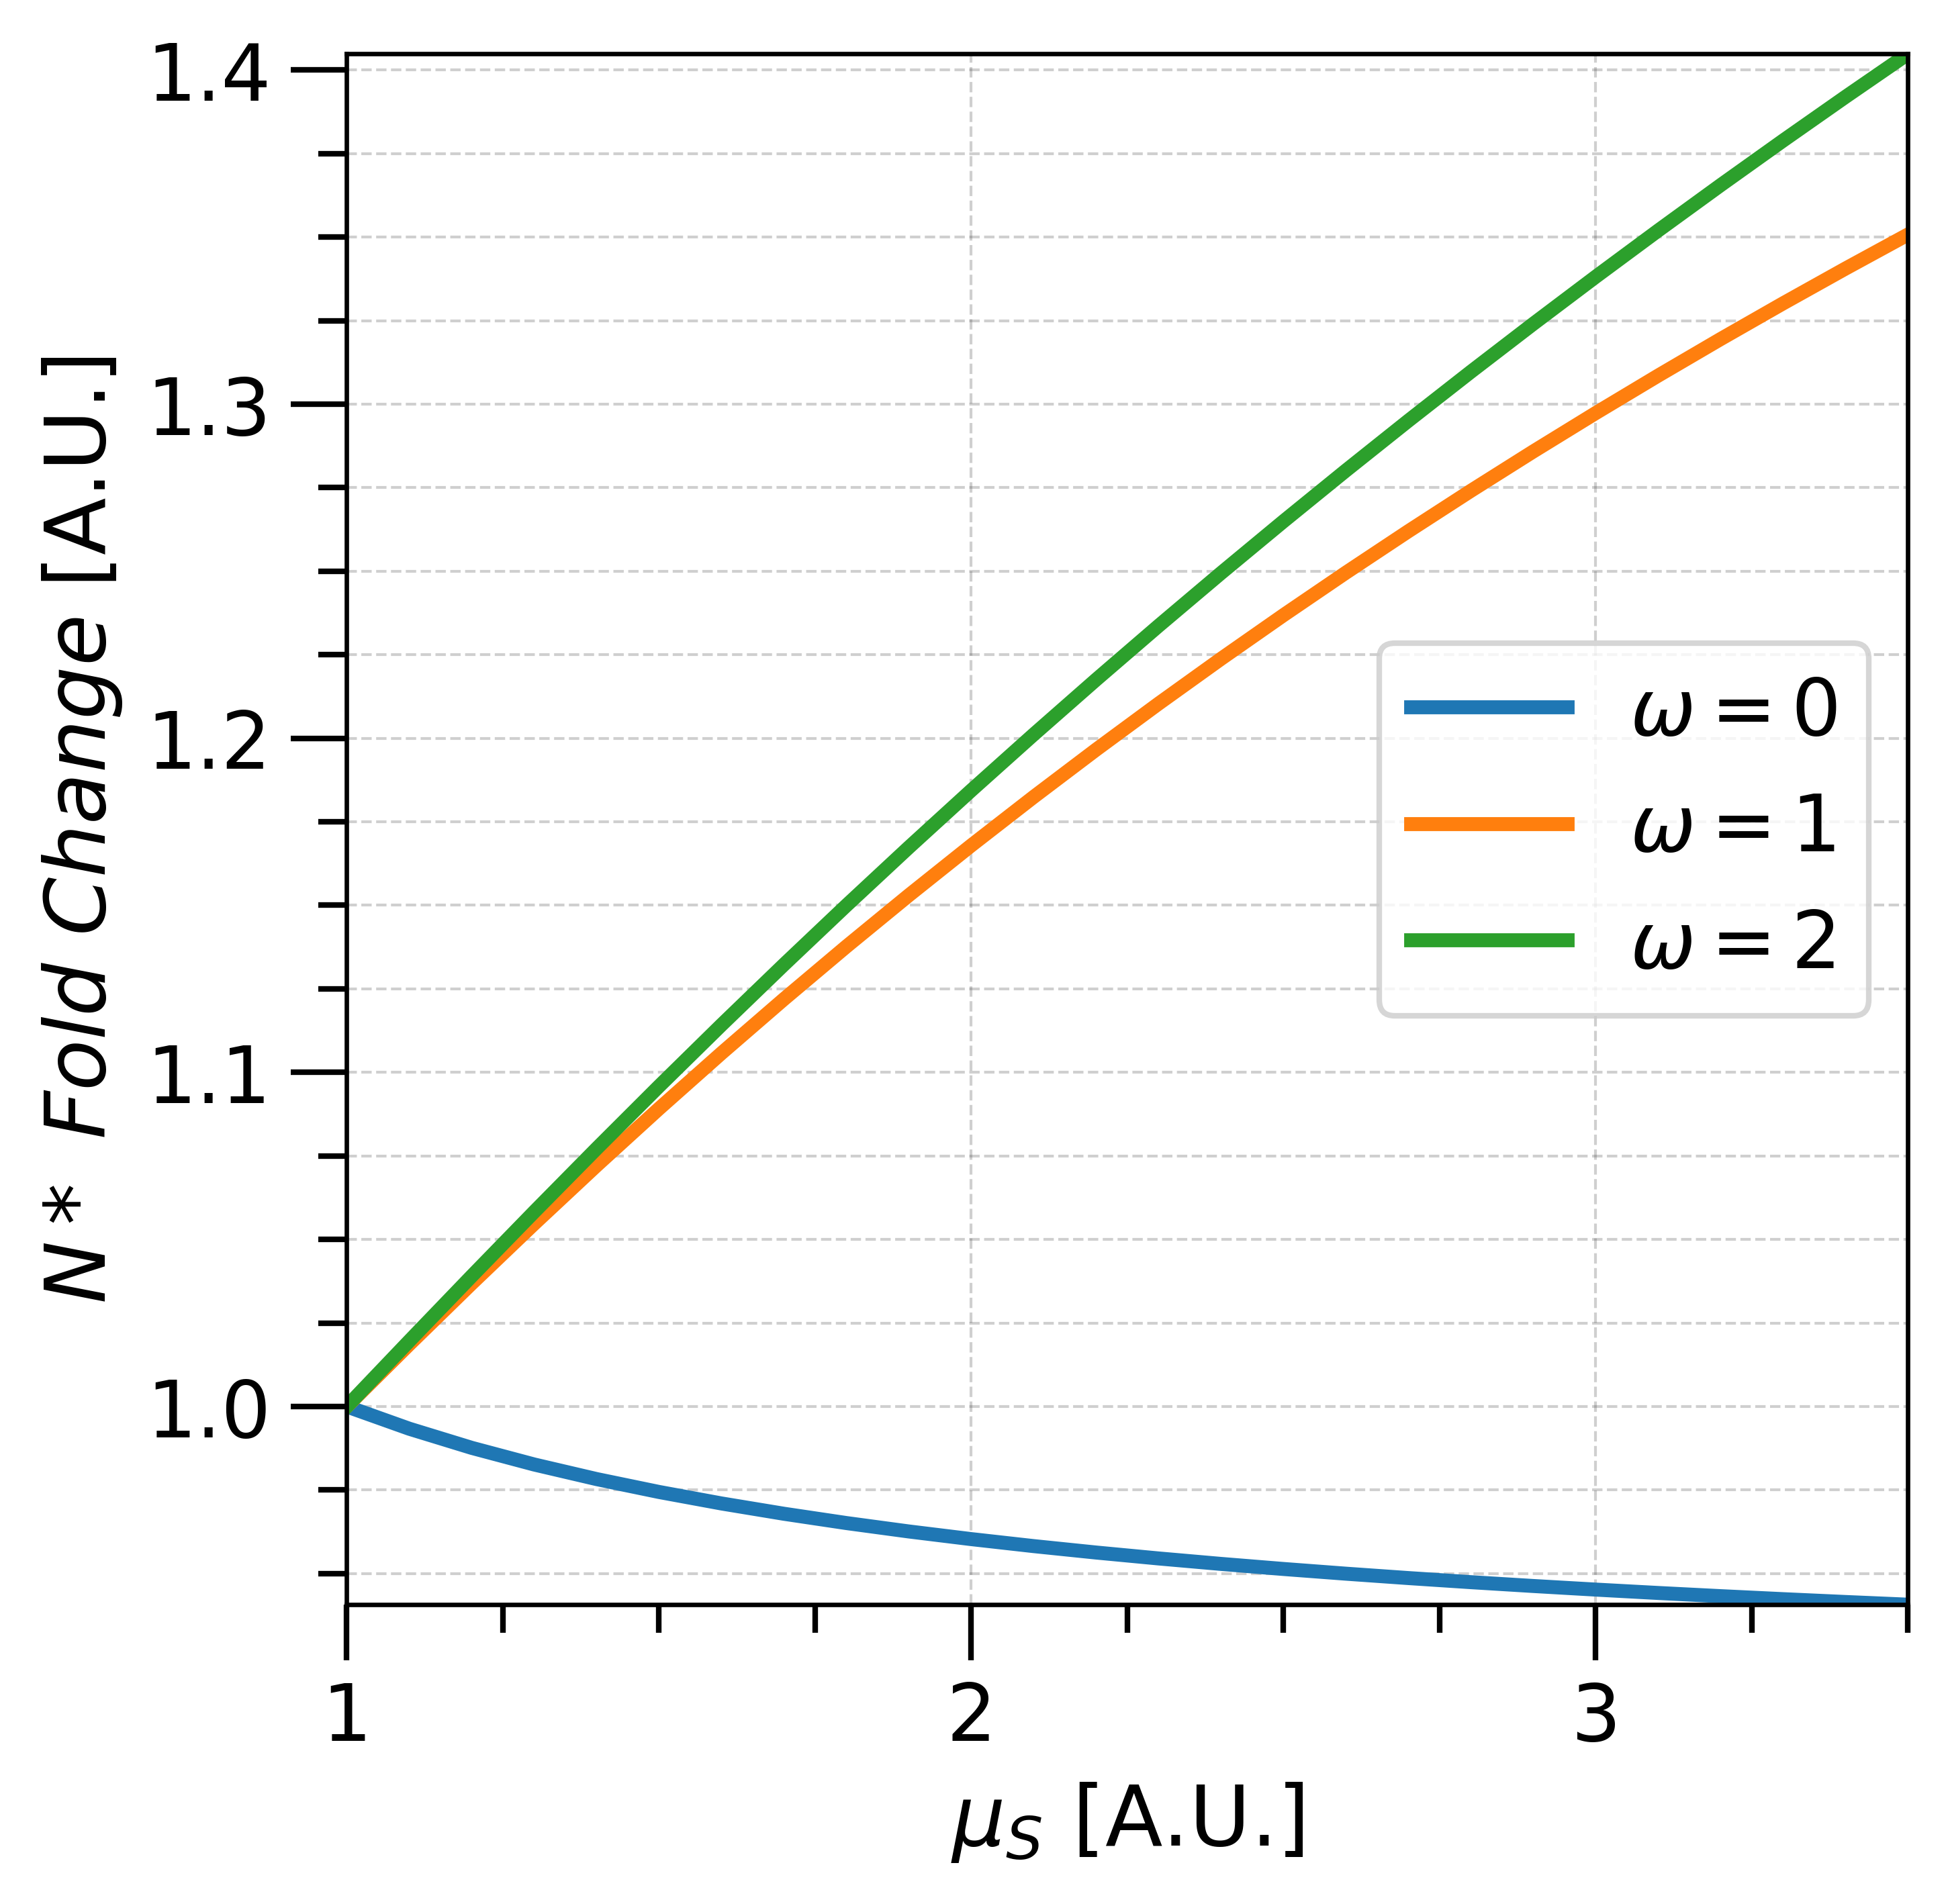

In [ ]:
#Second version of figure

figE10a = plt.figure(figsize=(5,5), dpi=600)

ax1  = figE10a.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(B_series), max(G_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.1))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$ω = 0$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$ω = 1$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$ω = 2$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. S10B

 The parameter ω is the ability of senior individuals (S) to impair juvenile (J) maturation into adults

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 1.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 3.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 1.0
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$ω_1$'] = 0.0
param['$ω_2$'] = 0.0
mu_range, sim_B = function(system = MetaPopC, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$ω_1$'] = 1.0
param['$ω_2$'] = 1.0
_, sim_R = function(system = MetaPopC, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$ω_1$'] = 2.0
param['$ω_2$'] = 2.0
_, sim_G = function(system = MetaPopC, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

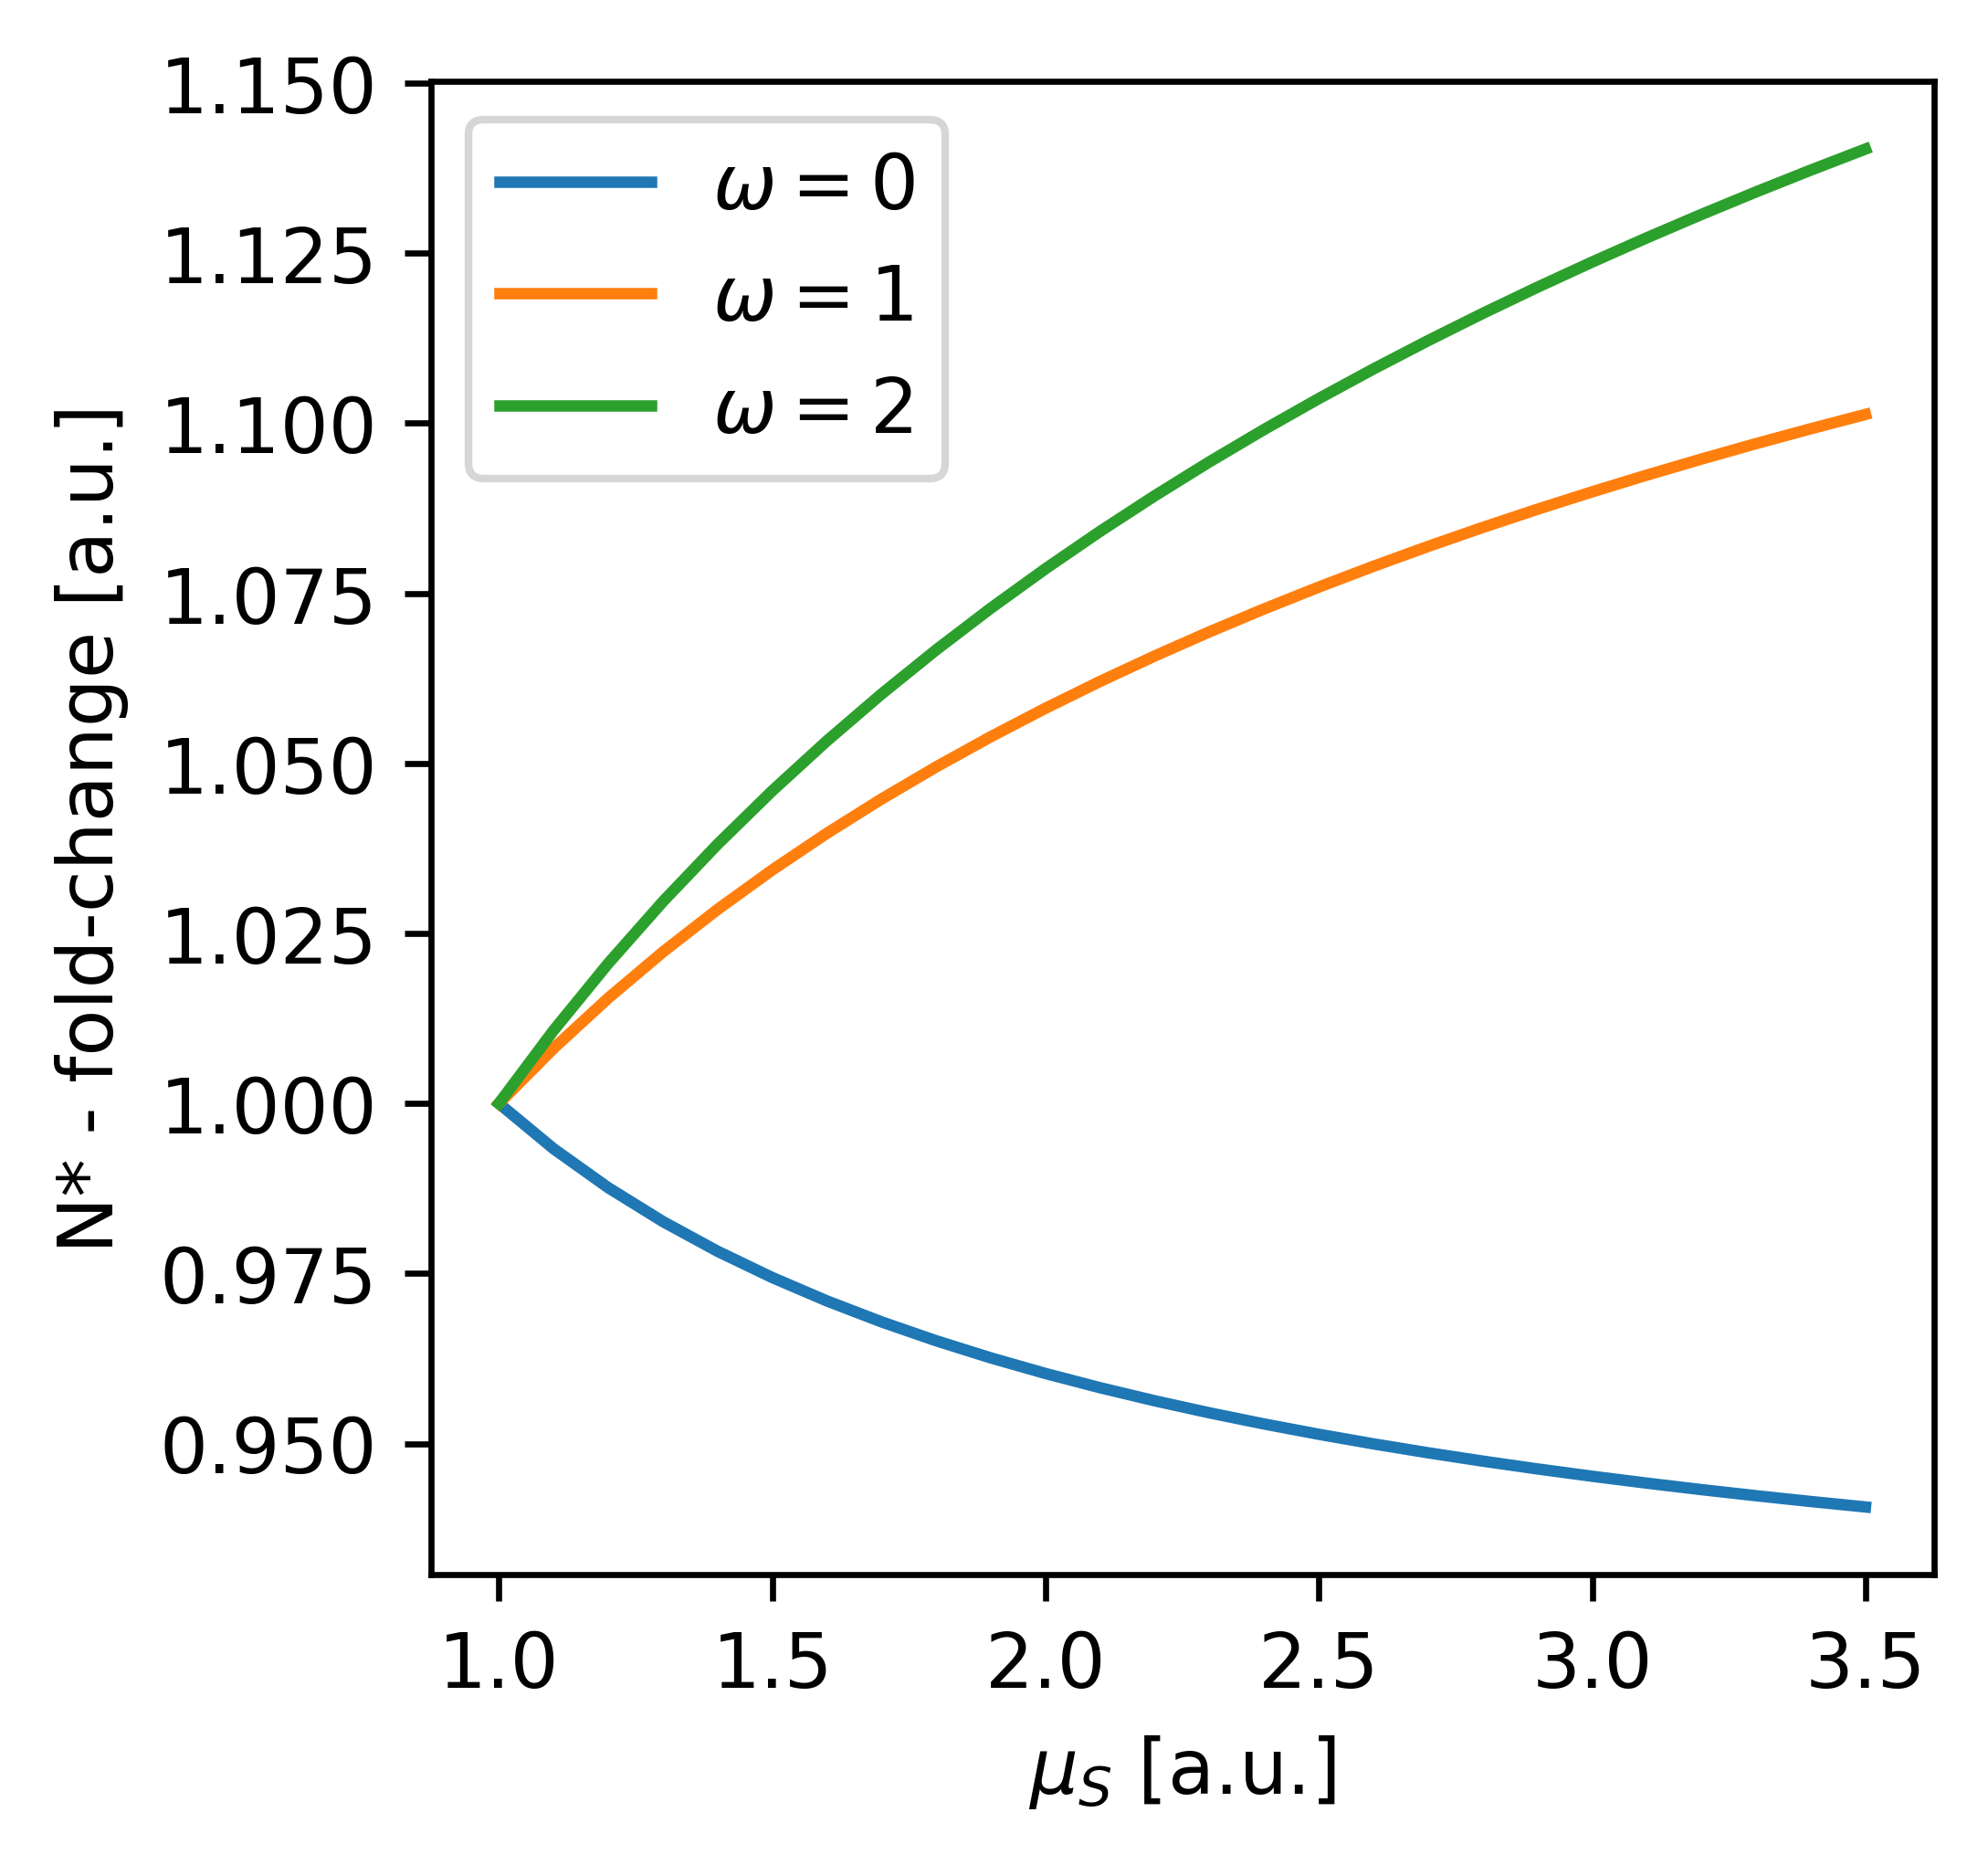

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$ω = 0$')
dores.plot(mu_range, R_series, label='$ω = 1$')
dores.plot(mu_range, G_series, label='$ω = 2$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

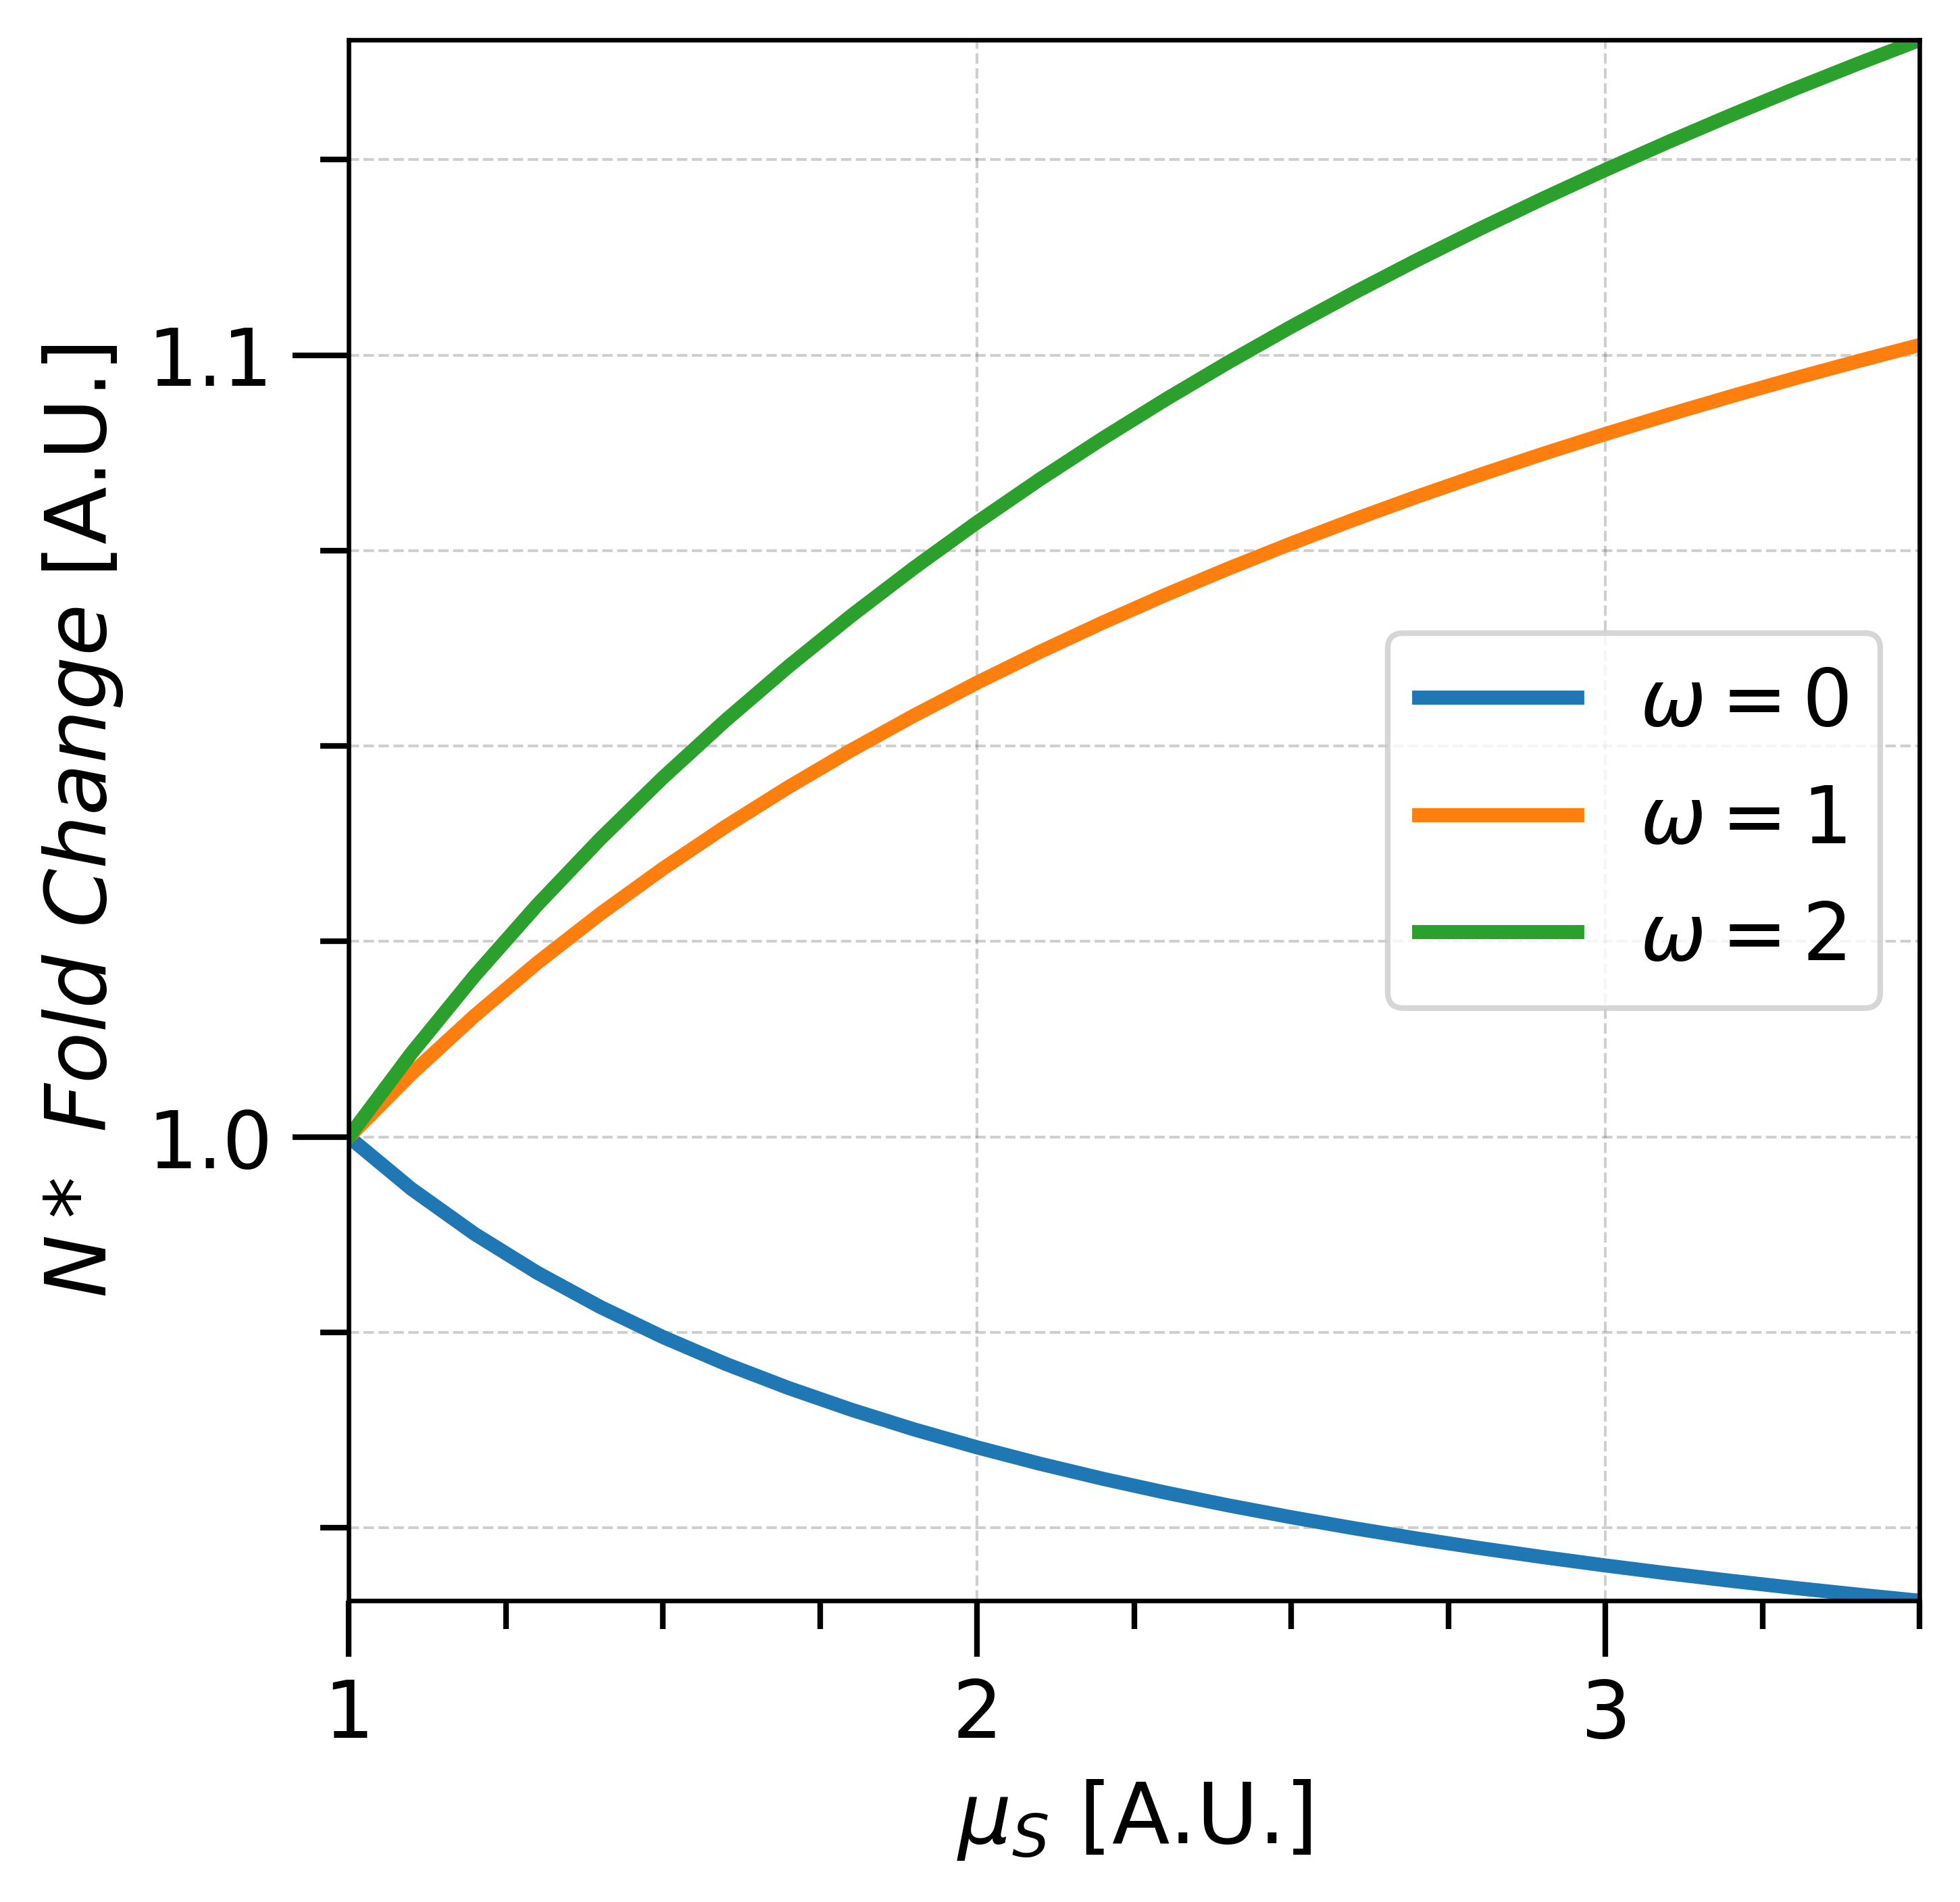

In [ ]:
#Second version of figure

figE10b = plt.figure(figsize=(5,5), dpi=600)

ax1  = figE10b.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(B_series), max(G_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.1))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$ω = 0$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$ω = 1$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$ω = 2$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. S10C

Here, competition strength depends on resources availability. In this case, a higher CMR triggers a more drastic increase in the population size (hydra effect) when resources are limited (α = 0, ω > 0, rho in series)

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 1.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 3.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 0.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0.0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0.1 # Detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0.0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 1.0
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$ρ$'] = 0.0
mu_range, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$ρ$'] = 1.0
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$ρ$'] = 10
_, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

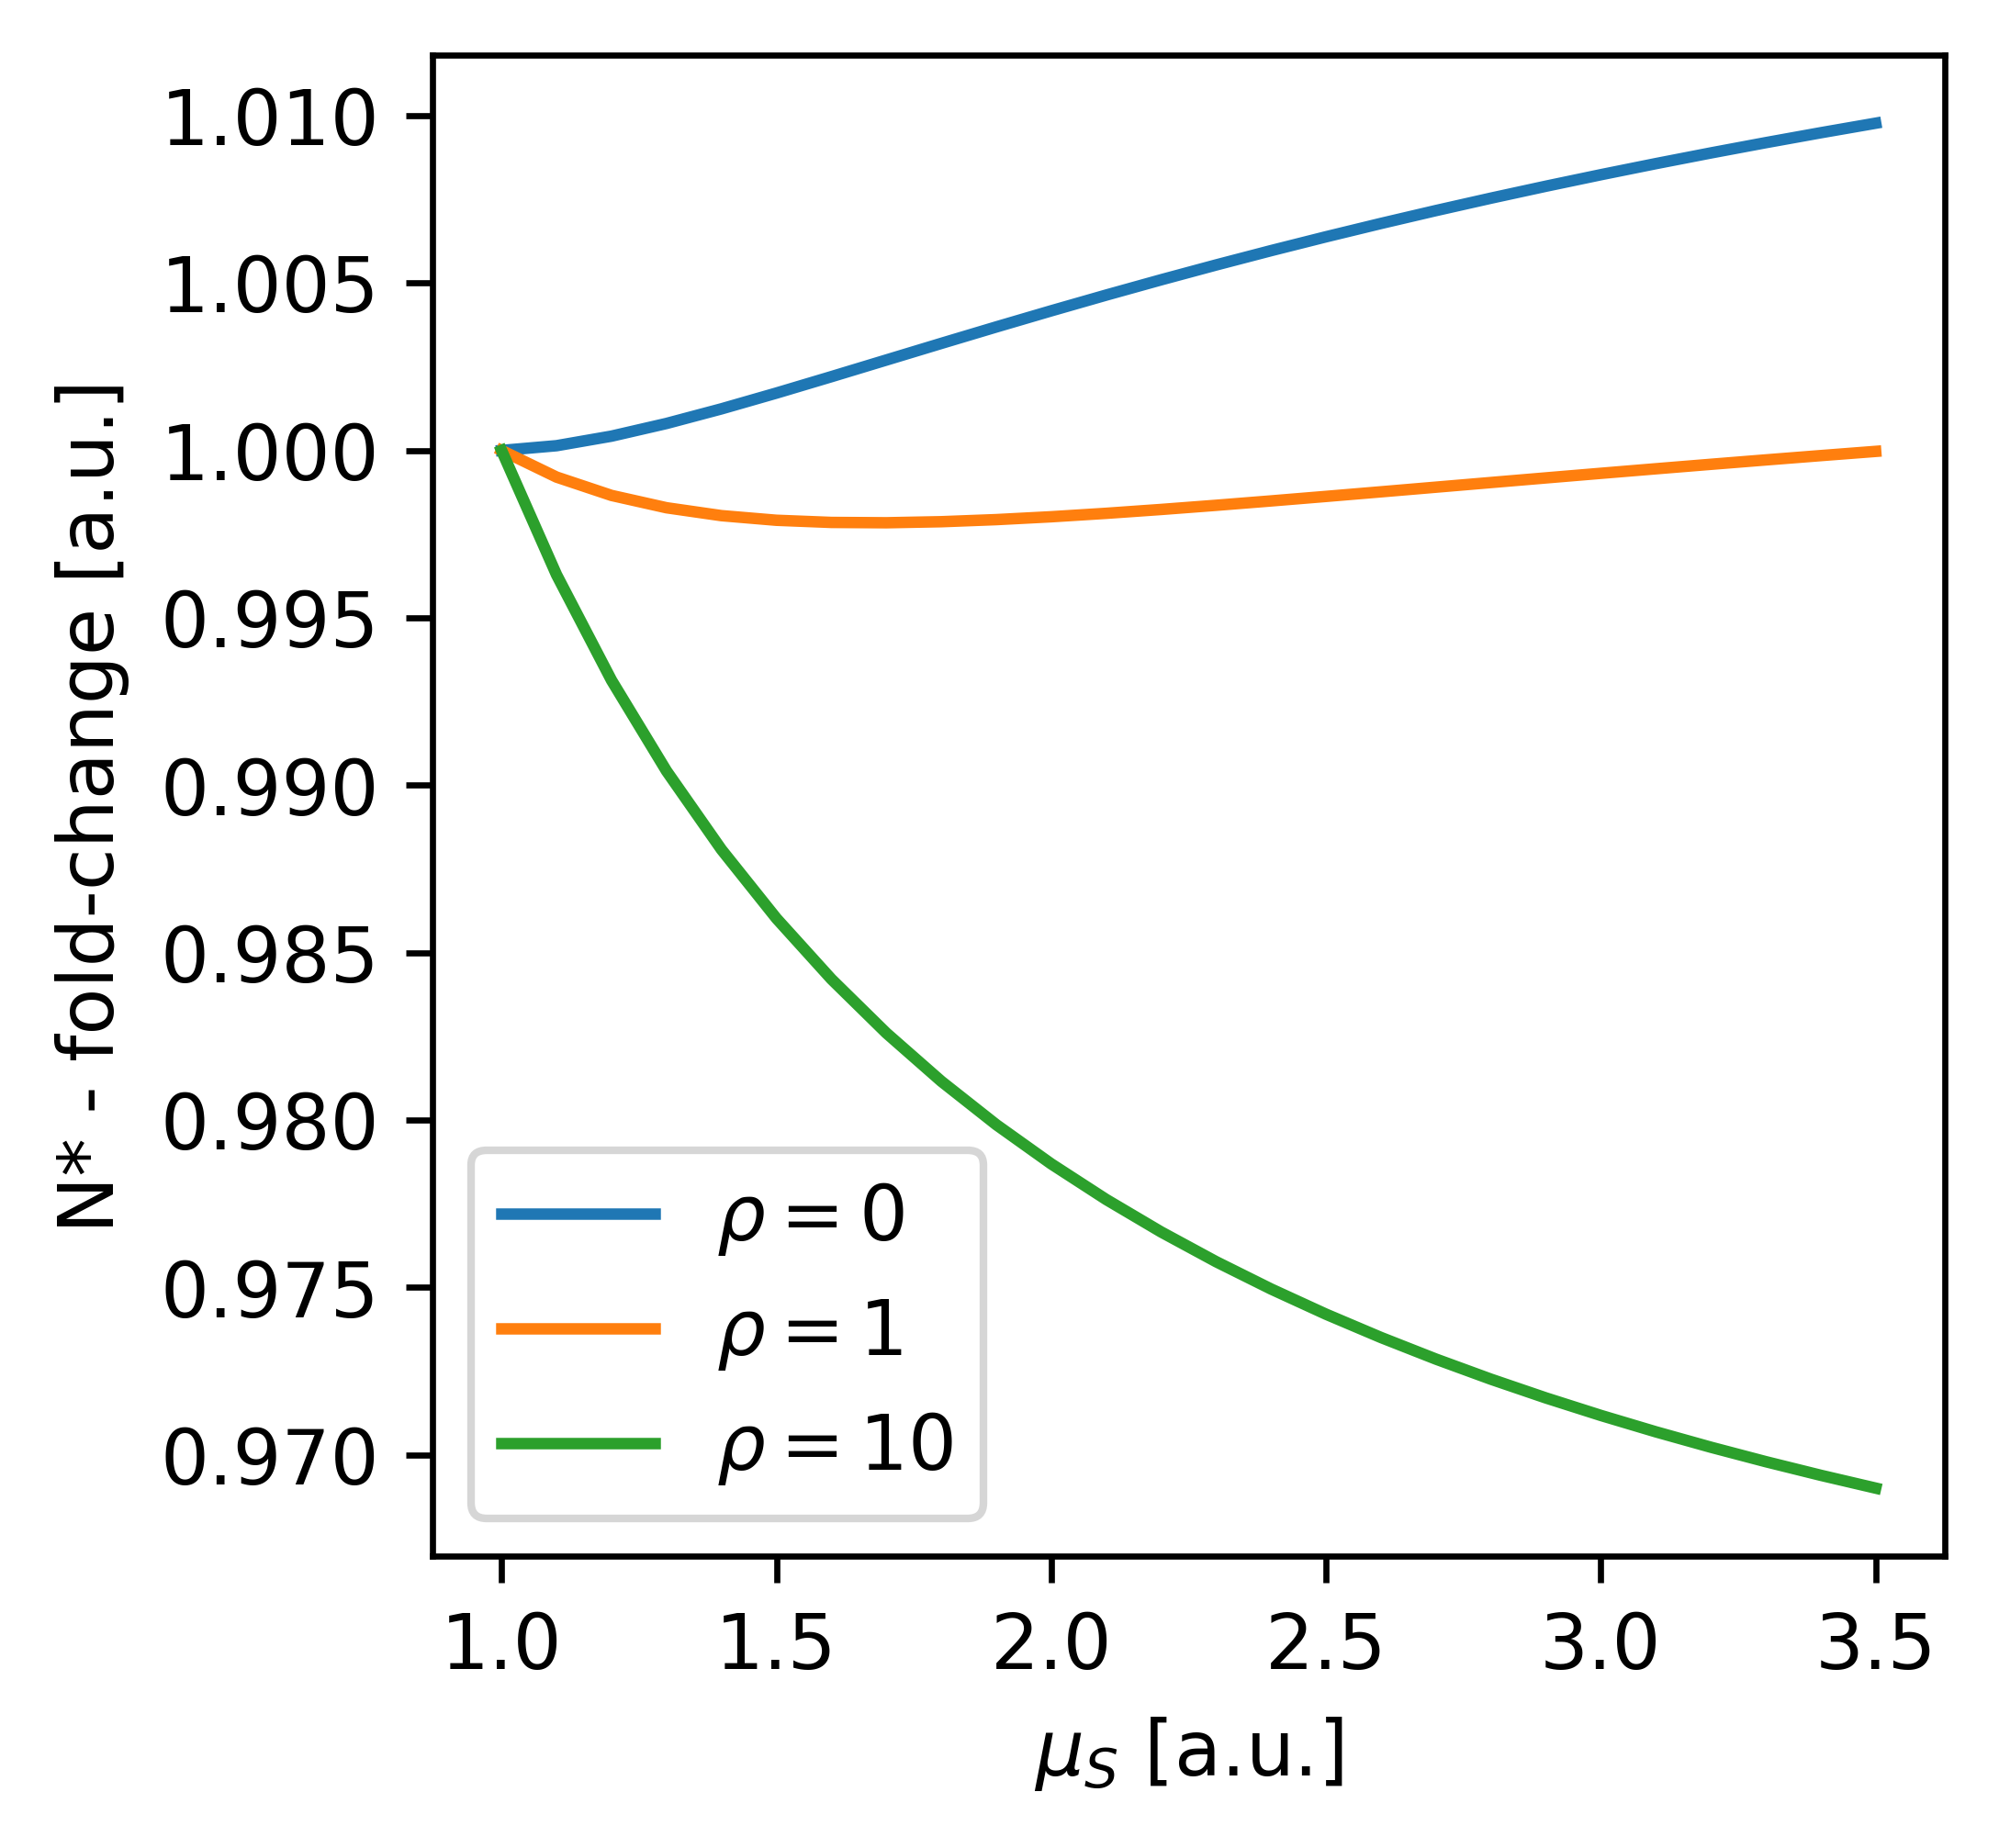

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$ρ = 0$')
dores.plot(mu_range, R_series, label='$ρ = 1$')
dores.plot(mu_range, G_series, label='$ρ = 10$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

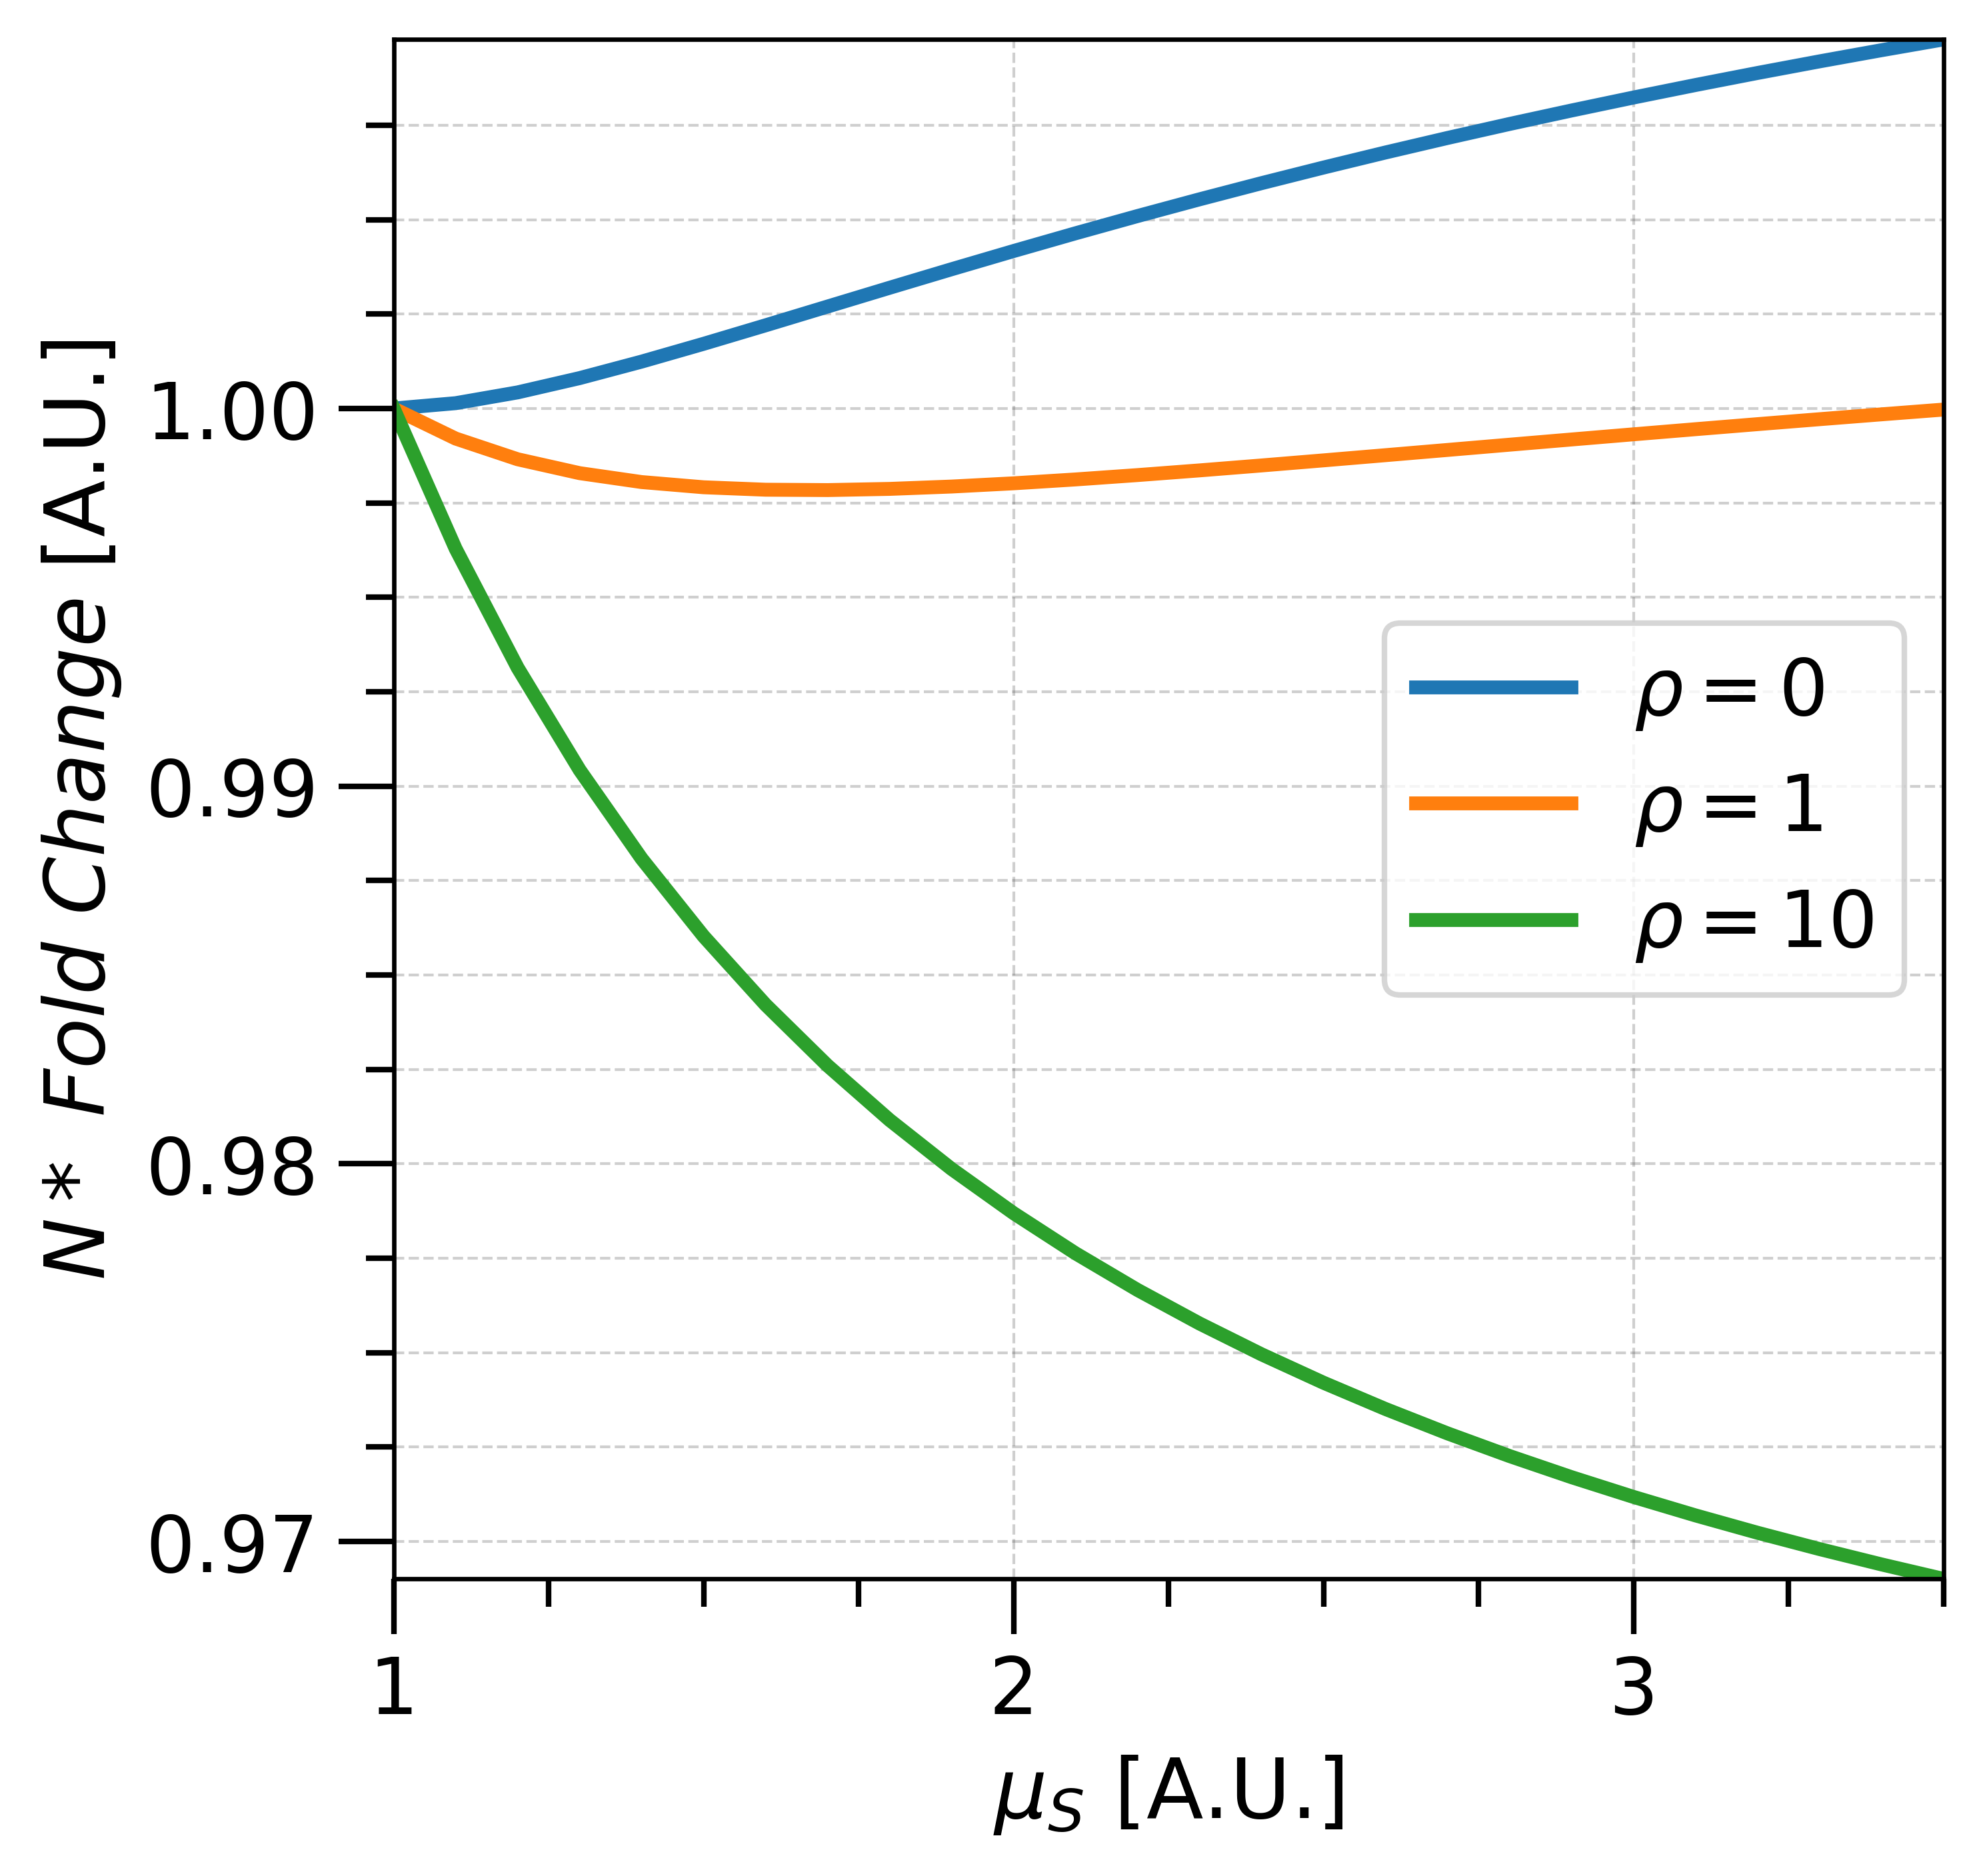

In [ ]:
#Second version of figure

figE10c = plt.figure(figsize=(5,5), dpi=600)

ax1  = figE10c.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(min(mu_range), max(mu_range))
ax1.set_ylim(min(G_series), max(B_series))

ax1.xaxis.set_major_locator(MultipleLocator(1))
# dentro del rango cada cuanto mete un tick, el rango por default sobre el que trabaja es 0-1.
# Se reacomoda a los datos (si el range del axis no se aclara manualmente, se usa el de los datos).

ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
# este (por el "auto...locator" supongo) pone el número de intervalos entre ls major ticks

ax1.yaxis.set_major_locator(MultipleLocator(.01))

ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)
ax1.grid(axis='y', which='minor', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(x,y0, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.plot(mu_range, B_series, label='$ρ = 0$', linewidth = 2.5)
ax1.plot(mu_range, R_series, label='$ρ = 1$', linewidth = 2.5)
ax1.plot(mu_range, G_series, label='$ρ = 10$', linewidth = 2.5)

ax1.set_xlabel('$μ_{S} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N* \ Fold \ Change $ [A.U.]', fontsize = 15)
ax1.legend(loc=7, fontsize=14)

plt.show()

## Fig. S11

 In this version of the model (Extended Data Eqs. 4), senior individuals (S) are less reproductive than adults (A) instead of post- or non-reproductive.

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 1.00, 2.5, 3.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 5.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 2.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.8 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 1.0
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$β_{S1}$'] = 0.0*ba1
param['$β_{S2}$'] = 0.0*ba2
mu_range, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$β_{S1}$'] = 0.1*ba1
param['$β_{S2}$'] = 0.1*ba2
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$β_{S1}$'] = 0.2*ba1
param['$β_{S2}$'] = 0.2*ba2
_, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

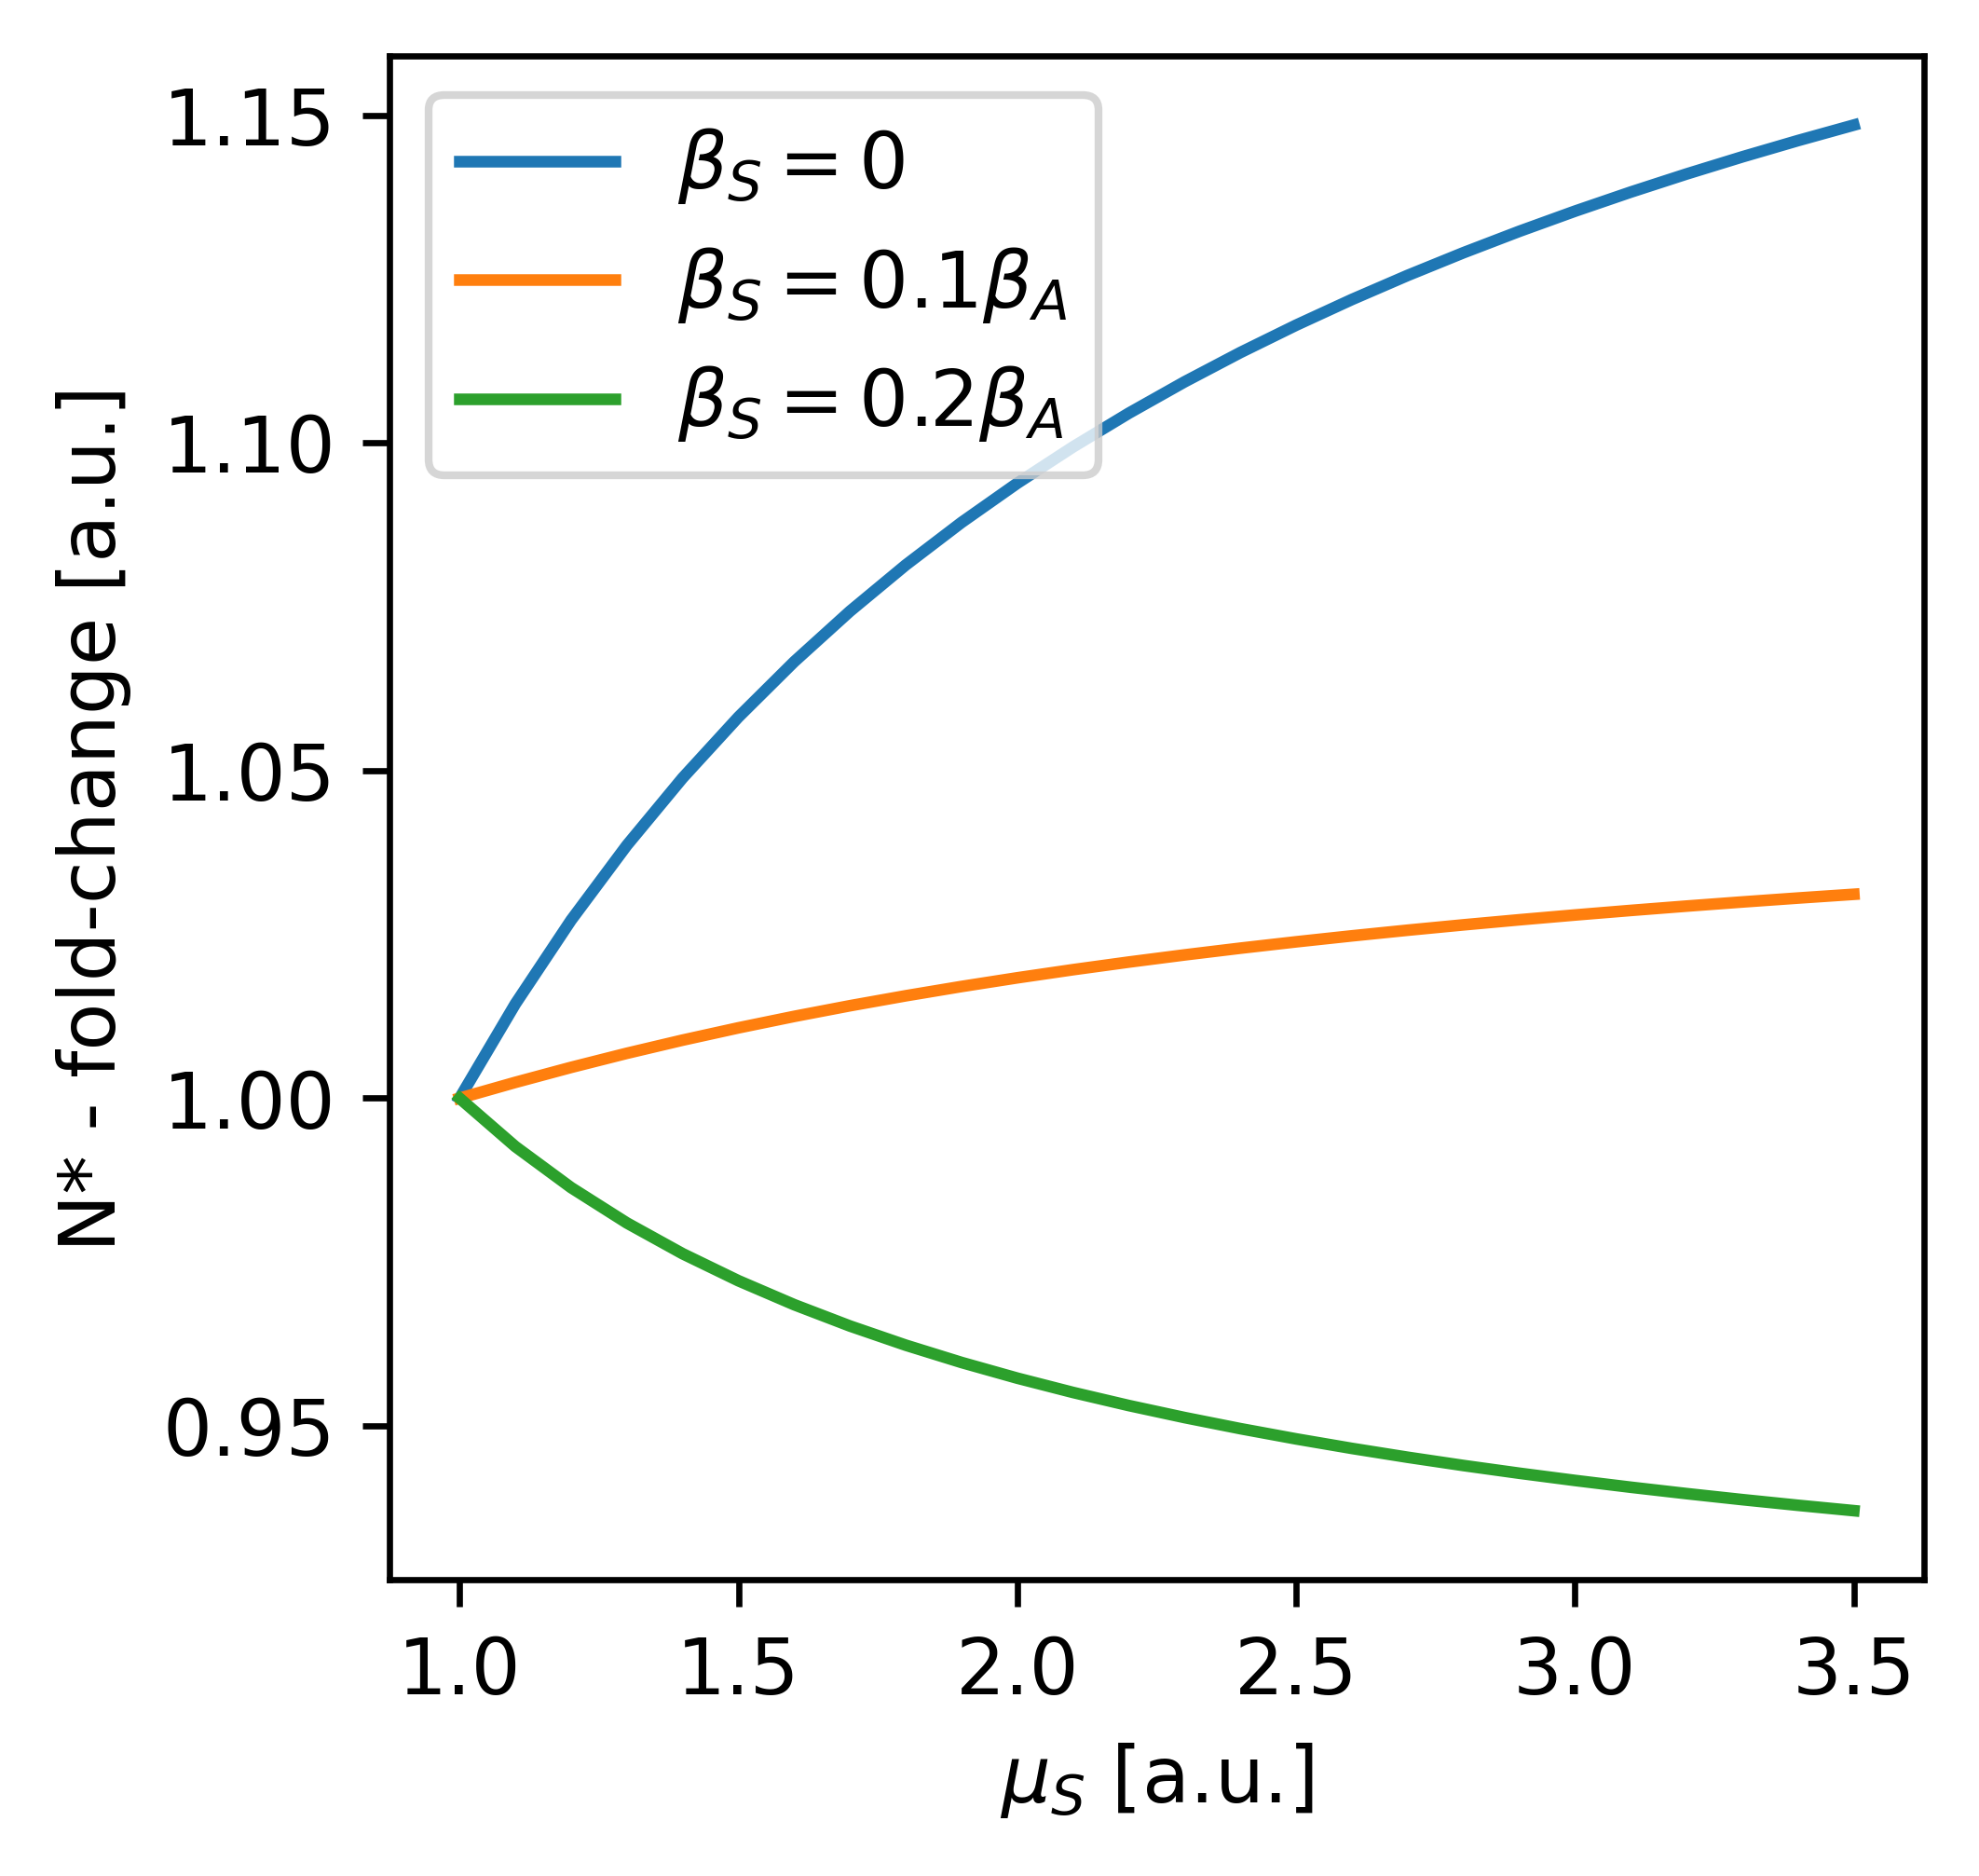

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$β_{S} = 0$')
dores.plot(mu_range, R_series, label='$β_{S} = 0.1β_{A}$')
dores.plot(mu_range, G_series, label='$β_{S} = 0.2β_{A}$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

## Fig. S12

Same model as the preceding one (Extended Data Eqs. 4) in which senior individuals have progeny, but we consider the case of higher mortality in senior born juveniles ($μ_{JS}$) than younger adults born ones ($μ_{JA}$).


In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 1.198562, 0, 0.406321, 0.203161 # Initial conditions
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # no difference between subpops

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 1.00, 2.5, 3.0 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 5.0, 1.0 # fertility rates for both types of juveniles
ga1, gs1 = 2.0, 2.0 # maturity rates for both types of juveniles
s1 = 1.0 # senescence of adults into seniors
mja1, mjs1 = 0.8, 0.8 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 'x' # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 8.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500.0
dt = t_fin/1000

#for control parameter range
start_mu = 1.0
end_mu = 3.6
step_mu = 0.1


In [ ]:
param['$μ_{JS1}$'] = mja1
param['$μ_{JS2}$'] = mja2
mu_range, sim_G = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$μ_{JS1}$'] = mja1*2.0
param['$μ_{JS2}$'] = mja2*2.0
_, sim_R = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)
param['$μ_{JS1}$'] = mja1*3.0
param['$μ_{JS2}$'] = mja2*3.0
_, sim_B = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S1}$', control2='$μ_{S2}$', full = True)

B_series =[]
R_series =[]
G_series =[]
for i in range(len(mu_range)) :
  B_series.append(sim_B[i].get('last_value')['N(t)']/sim_B[0].get('last_value')['N(t)'])
  R_series.append(sim_R[i].get('last_value')['N(t)']/sim_R[0].get('last_value')['N(t)'])
  G_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

### Plot

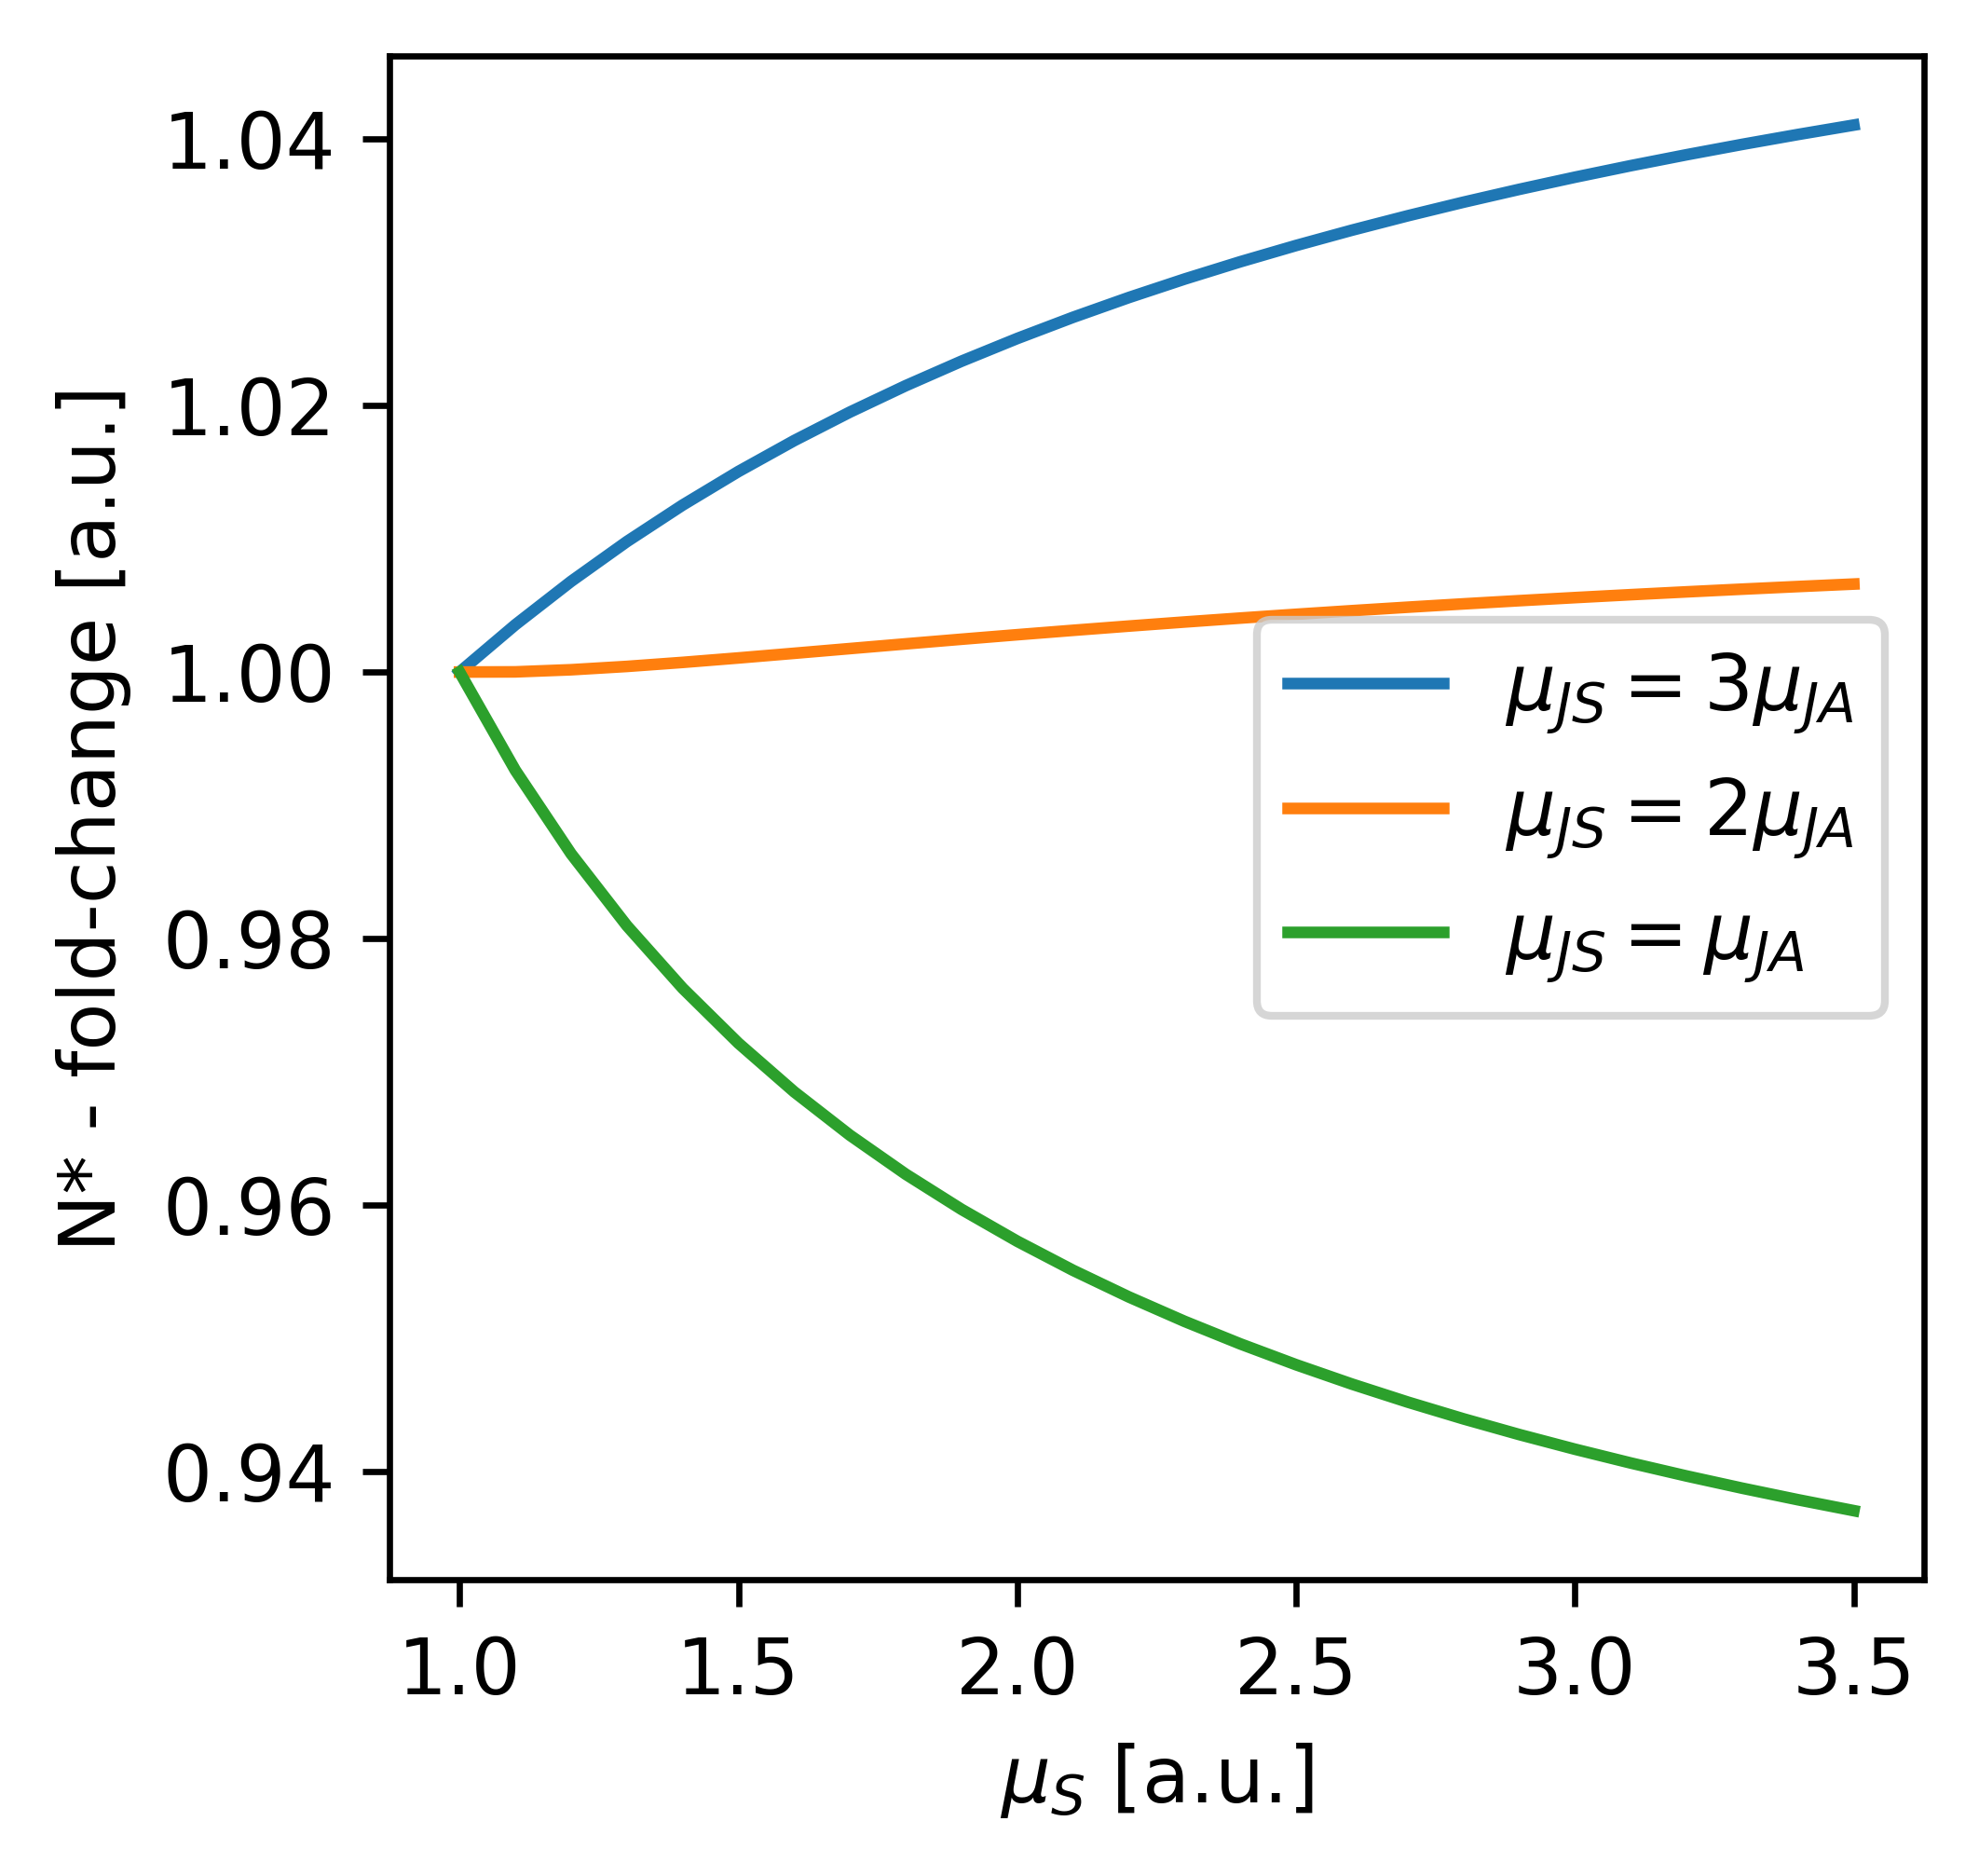

In [ ]:
#First version of figure (Dosage (senior mortality) - Response (population steady state) plot)

fig  = plt.figure(figsize=(3.54,3.54), dpi=600)
dores = fig.add_subplot()

dores.plot(mu_range, B_series, label='$μ_{JS} = 3μ_{JA}$')
dores.plot(mu_range, R_series, label='$μ_{JS} = 2μ_{JA}$')
dores.plot(mu_range, G_series, label='$μ_{JS} = μ_{JA}$')
# dores.set_ylabel(str(res_exp1A[0].get('params')), rotation=0, fontsize=8)
# dores.text(-0.3, 0.5, str(res_exp1A1_mus[0].get('params')), verticalalignment='center', transform=dores.transAxes, fontsize=5)
dores.set_xlabel(r'$\mu_{S}$ [a.u.]')
dores.set_ylabel(r'N* - fold-change [a.u.]')
dores.legend()
dores.legend()
# dores.grid()

## Fig. S13A

In heterogeneous populations, the presence of oncogenic variants that increase CMR (higher $μ_S$) in a subpopulation may result in the counterintuitive effect of increasing the overall population density ($N^*$) rather than decreasing it.

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 2.198562, 0.0, 1.406321, 1.203161 # Initial values for subpop 1
J_A2i, J_S2i, A2i, S2i = J_A1i, J_S1i, A1i, S1i # Subpop 2 with same initial values

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 1.00, 0.00, 2.5, 2.1 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 5.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 0.5, 0.0 # maturity rates for both types of juveniles
s1 = 5.0 # senescence of adults into seniors
mja1, mjs1 = 0.5, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 1.0 # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 10.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 500
dt = 0.5

#for control parameter range
start_mu = 0.5
end_mu = 3.6
step_mu = 0.01


In [ ]:
mu_range, sim = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S2}$', control2='$μ_{S2}$', full = True)
fulled_series = []
dotted_series = []
N1_series = []
N2_series = []
for i in range(len(mu_range)):
  fulled_series.append(sim[i].get('last_value')['N(t)'])
  N1_series.append(sim[i].get('last_value')['N1(t)'])
  N2_series.append(sim[i].get('last_value')['N2(t)'])
  dotted_series.append(sim[i].get('last_value')['N2(t)']/sim[i].get('last_value')['N(t)'])
  # fulled_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

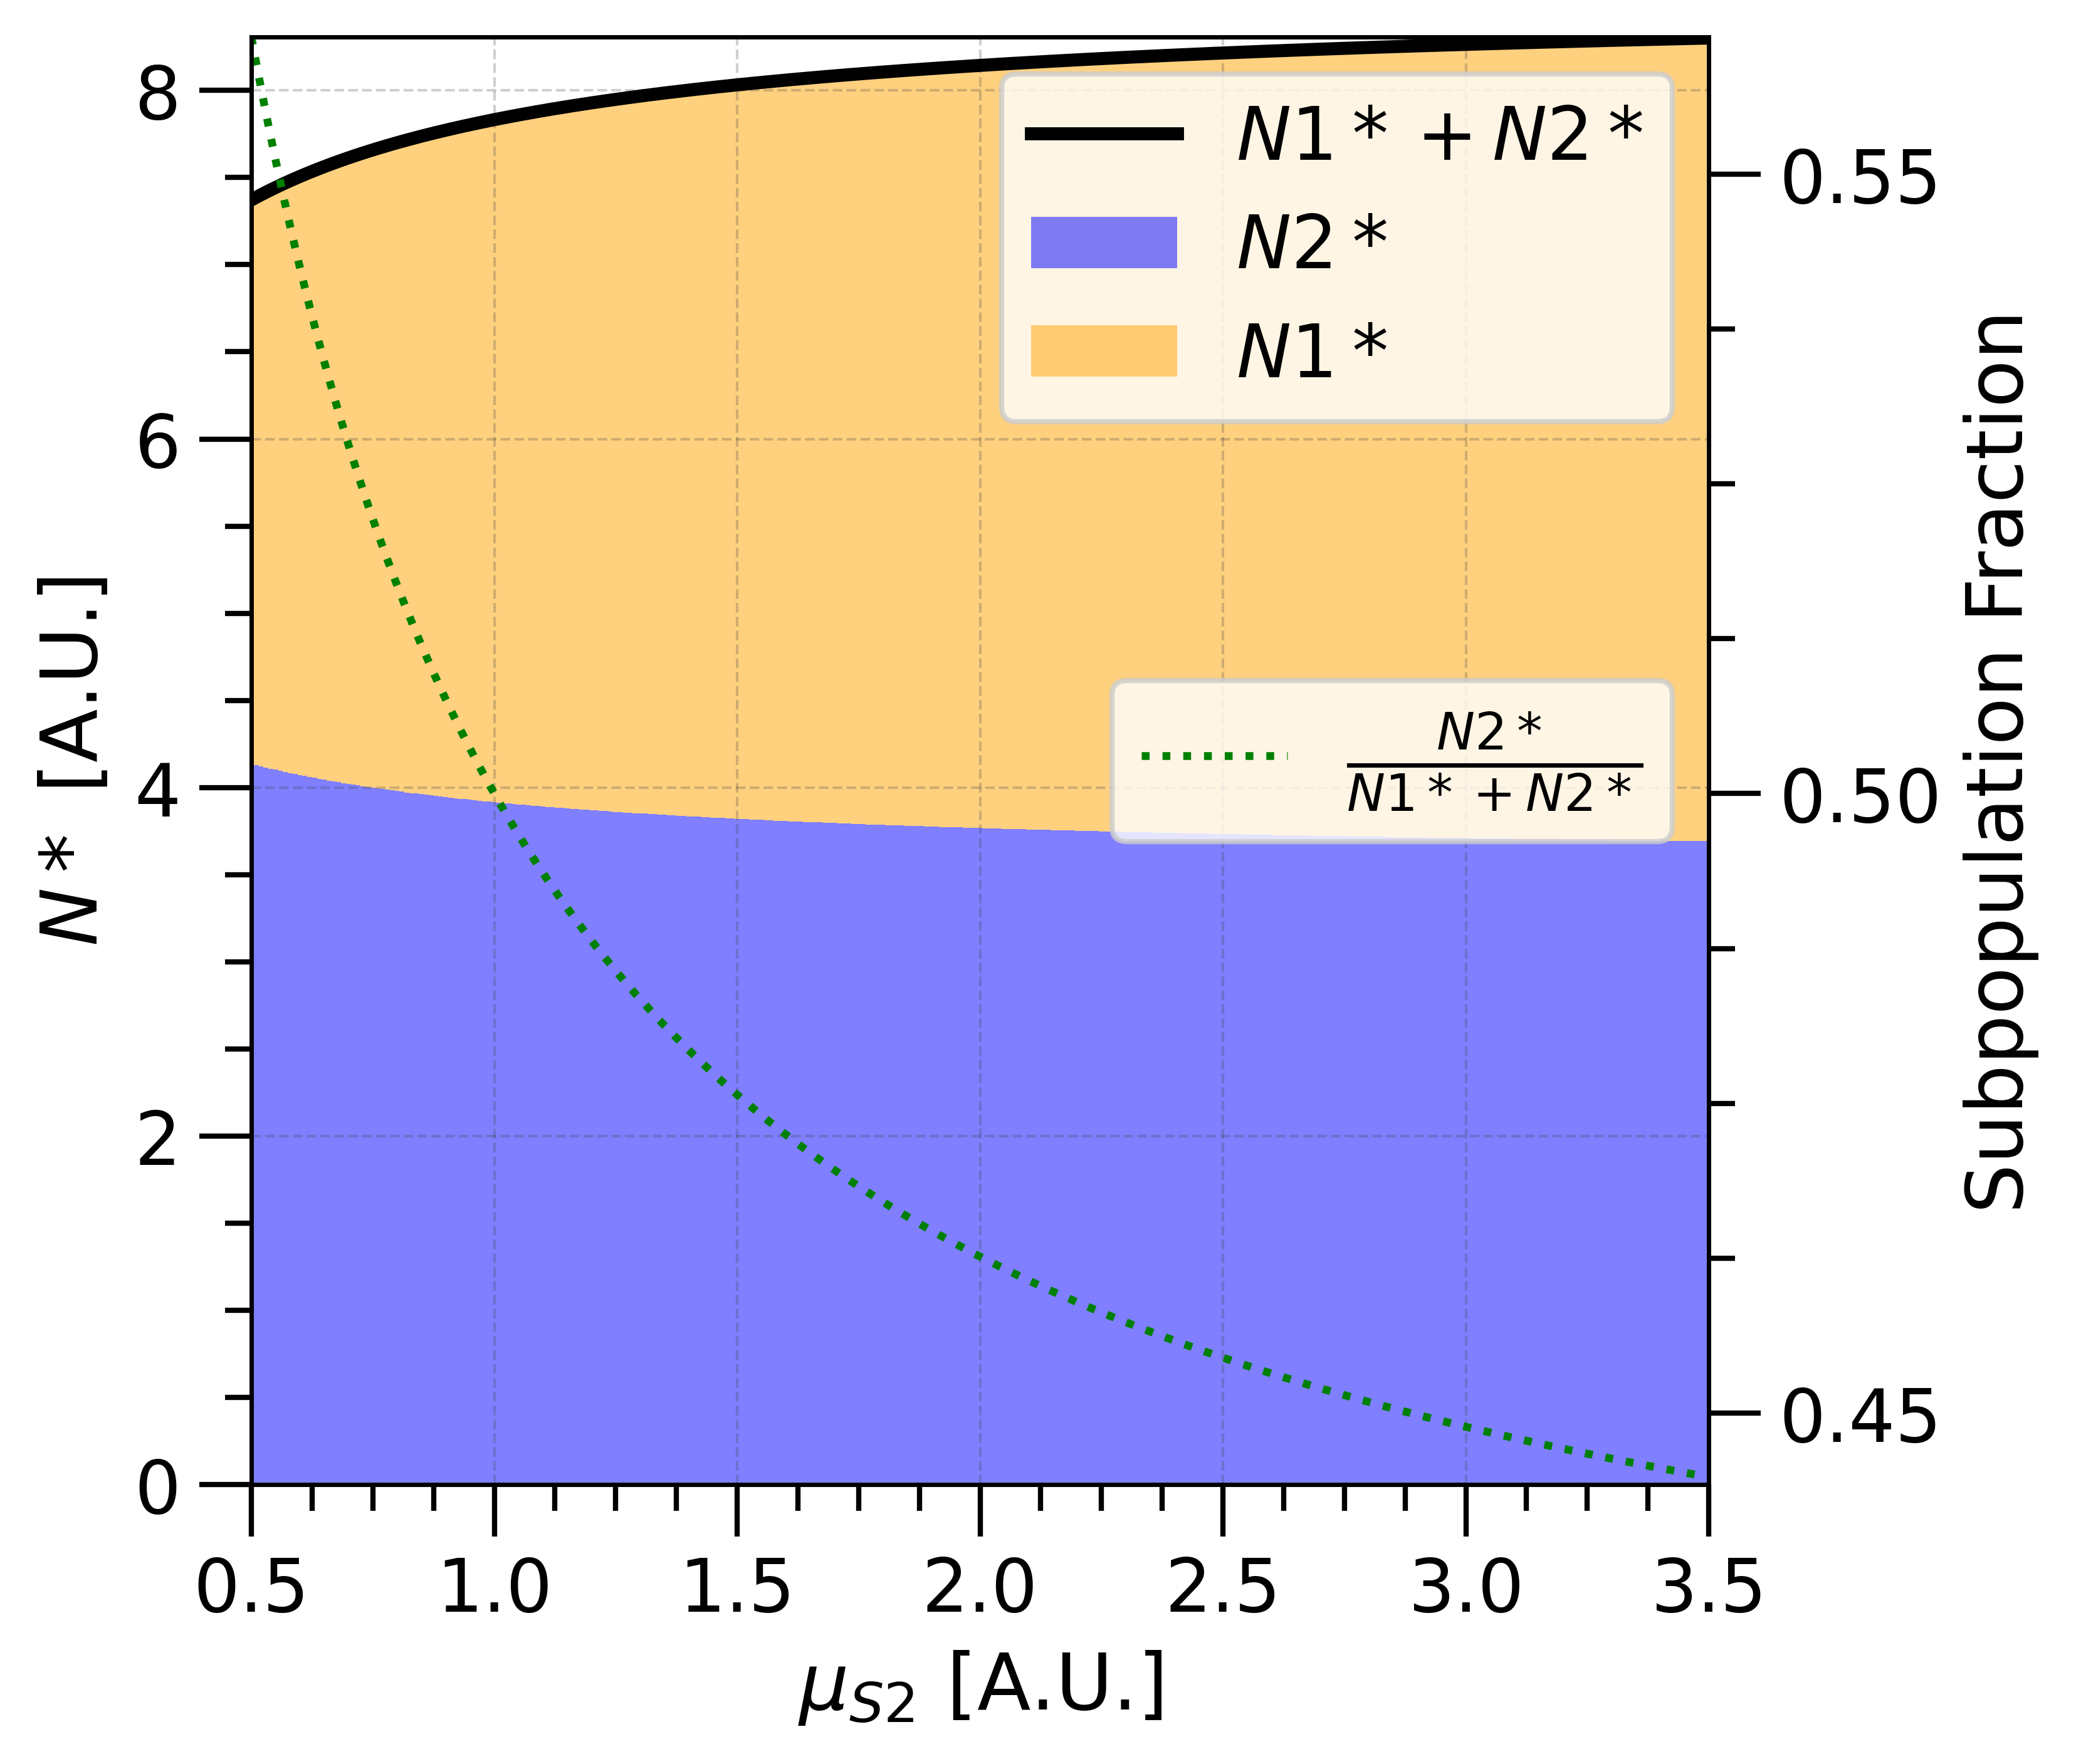

In [ ]:
fig4f  = plt.figure(figsize=(5,5), dpi=600)

ax1  = fig4f.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(0.5, 3.5)
ax1.set_ylim(0, fulled_series[-1])

ax1.xaxis.set_major_locator(MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(AutoMinorLocator(4))

ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

# ax1.plot(mu_range, fulled_series, label='$N1 + N2$', color = 'k', linewidth=2.5)
ax1.bar(mu_range, N2_series, width=step_mu,  bottom=0, label='$N2*$', color='blue', alpha=0.5, hatch='')
ax1.bar(mu_range, N1_series, width=step_mu, bottom=N2_series, label='$N1*$', color='orange', alpha=0.5, hatch='')
ax1.plot(mu_range, fulled_series, label='$N1* + N2*$', color = 'k', linewidth=2.5)


ax1.set_xlabel('$μ_{S2} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N*$ [A.U.]', fontsize = 15)
ax1.legend(loc=1, fontsize=14)

ax2 = ax1.twinx()

ax2.set_xlim(0.5, 3.5)
ax2.set_ylim(min(dotted_series), max(dotted_series))

ax2.xaxis.set_major_locator(MultipleLocator(0.5))
ax2.xaxis.set_minor_locator(AutoMinorLocator(4))


ax2.yaxis.set_major_locator(MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(AutoMinorLocator(4))

ax2.yaxis.set_major_formatter("{x:.2f}") # value with 2 decimal places ("2 floats")
# ax2.yaxis.set_minor_formatter("{x:.4f}") # value with 4 decimal places ("4 floats")


ax2.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax2.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax2.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax2.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=5, labelrotation=00)

# ax2.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

ax2.plot(mu_range, dotted_series, label=r'$\frac{N2*}{N1* + N2*}$', color = 'green', linestyle=':')

ax2.legend(loc=7, fontsize=14)

ax2.set_ylabel(r'Subpopulation Fraction', fontsize=15)

plt.show()

## Fig. S13B

In heterogeneous populations, the presence of oncogenic variants that increase CMR (higher $μ_S$) in a subpopulation may result in the counterintuitive effect of increasing the overall population density ($N^*$) even if the novel mutation that increases CMR appears at a very low frequency.

In [ ]:
# Initial conditions for a single Consumer population
J_A1i, J_S1i, A1i, S1i = 2.198562, 0.0, 1.406321, 1.203161 # Initial values for subpop 1
J_A2i, J_S2i, A2i, S2i = J_A1i*0.2, J_S1i*0, A1i*0.2, S1i*0.2 # Subpop 2 is 20% of the other

# Initial Resource value
Ri = 0.203404

#set all initial values into a list
init_values = [Ri, J_A1i, J_S1i, A1i, S1i, J_A2i, J_S2i, A2i, S2i]

#parameter SET (for full population)

kja1, kjs1, ka1, ks1 = 0.10, 0.00, 1.1, 1.8 # consuming rates
kja2, kjs2, ka2, ks2 = kja1, kjs1, ka1, ks1 # no difference between subpops

#Life history trait parameters
ba1, bs1 = 5.0, 0.0 # fertility rates for both types of juveniles
ga1, gs1 = 1.0, 0.0 # maturity rates for both types of juveniles
s1 = 0.5 # senescence of adults into seniors
mja1, mjs1 = 0.5, 0.0 # mortality rates for both types of juveniles
ma1 = 0.5 # # mortality rate for  adults
ms1 = 1.0 # this value is gonna be changed by the function in next code-cell

# no difference between subpopulations
ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2, ms2 = ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1, ms1

#Cooperation and Competition parameters
a1 = 0 # No explicit juvenile benefit of senior presence
a2 = a1 # No differences between subpops

w1 = 0 # No explicit detrimental effect of seniors over juveniles
w2 = w1 # No differences between subpops

r = 0 # Weight on Resources for competitive interactions.
# When resources abound, the effect is diminished.
# When resources are scarce competition is tougher.


# productivity of Resource population
p = 5.0

#set all parameters into a tuple
param_values = (p, r,
                kja1, kjs1, ka1, ks1,
                a1, w1,
                ba1, bs1, ga1, gs1, s1, mja1, mjs1, ma1,
                ms1,
                kja2, kjs2, ka2, ks2,
                a2, w2,
                ba2, bs2, ga2, gs2, s2, mja2, mjs2, ma2,
                ms2)

#set all parameters into a DataFrame
param = frame(param_values)

In [ ]:
##SETTINGS FOR SIMULATION

# for time range
t_ini = 0
t_fin = 2000
dt = 0.1

#for control parameter range
start_mu = 0.1
end_mu = 3.6
step_mu = 0.1


In [ ]:
mu_range, sim = function(system = MetaPopA, start = start_mu, end = end_mu, step = step_mu, param = param, init_cond = init_values,
             t_fin = t_fin, dt = dt, control1='$μ_{S2}$', control2='$μ_{S2}$', full = True)
fulled_series = []
dotted_series = []
for i in range(len(mu_range)):
  fulled_series.append(sim[i].get('last_value')['N(t)'])
  dotted_series.append(sim[i].get('last_value')['N2(t)']/sim[i].get('last_value')['N1(t)'])
  # fulled_series.append(sim_G[i].get('last_value')['N(t)']/sim_G[0].get('last_value')['N(t)'])

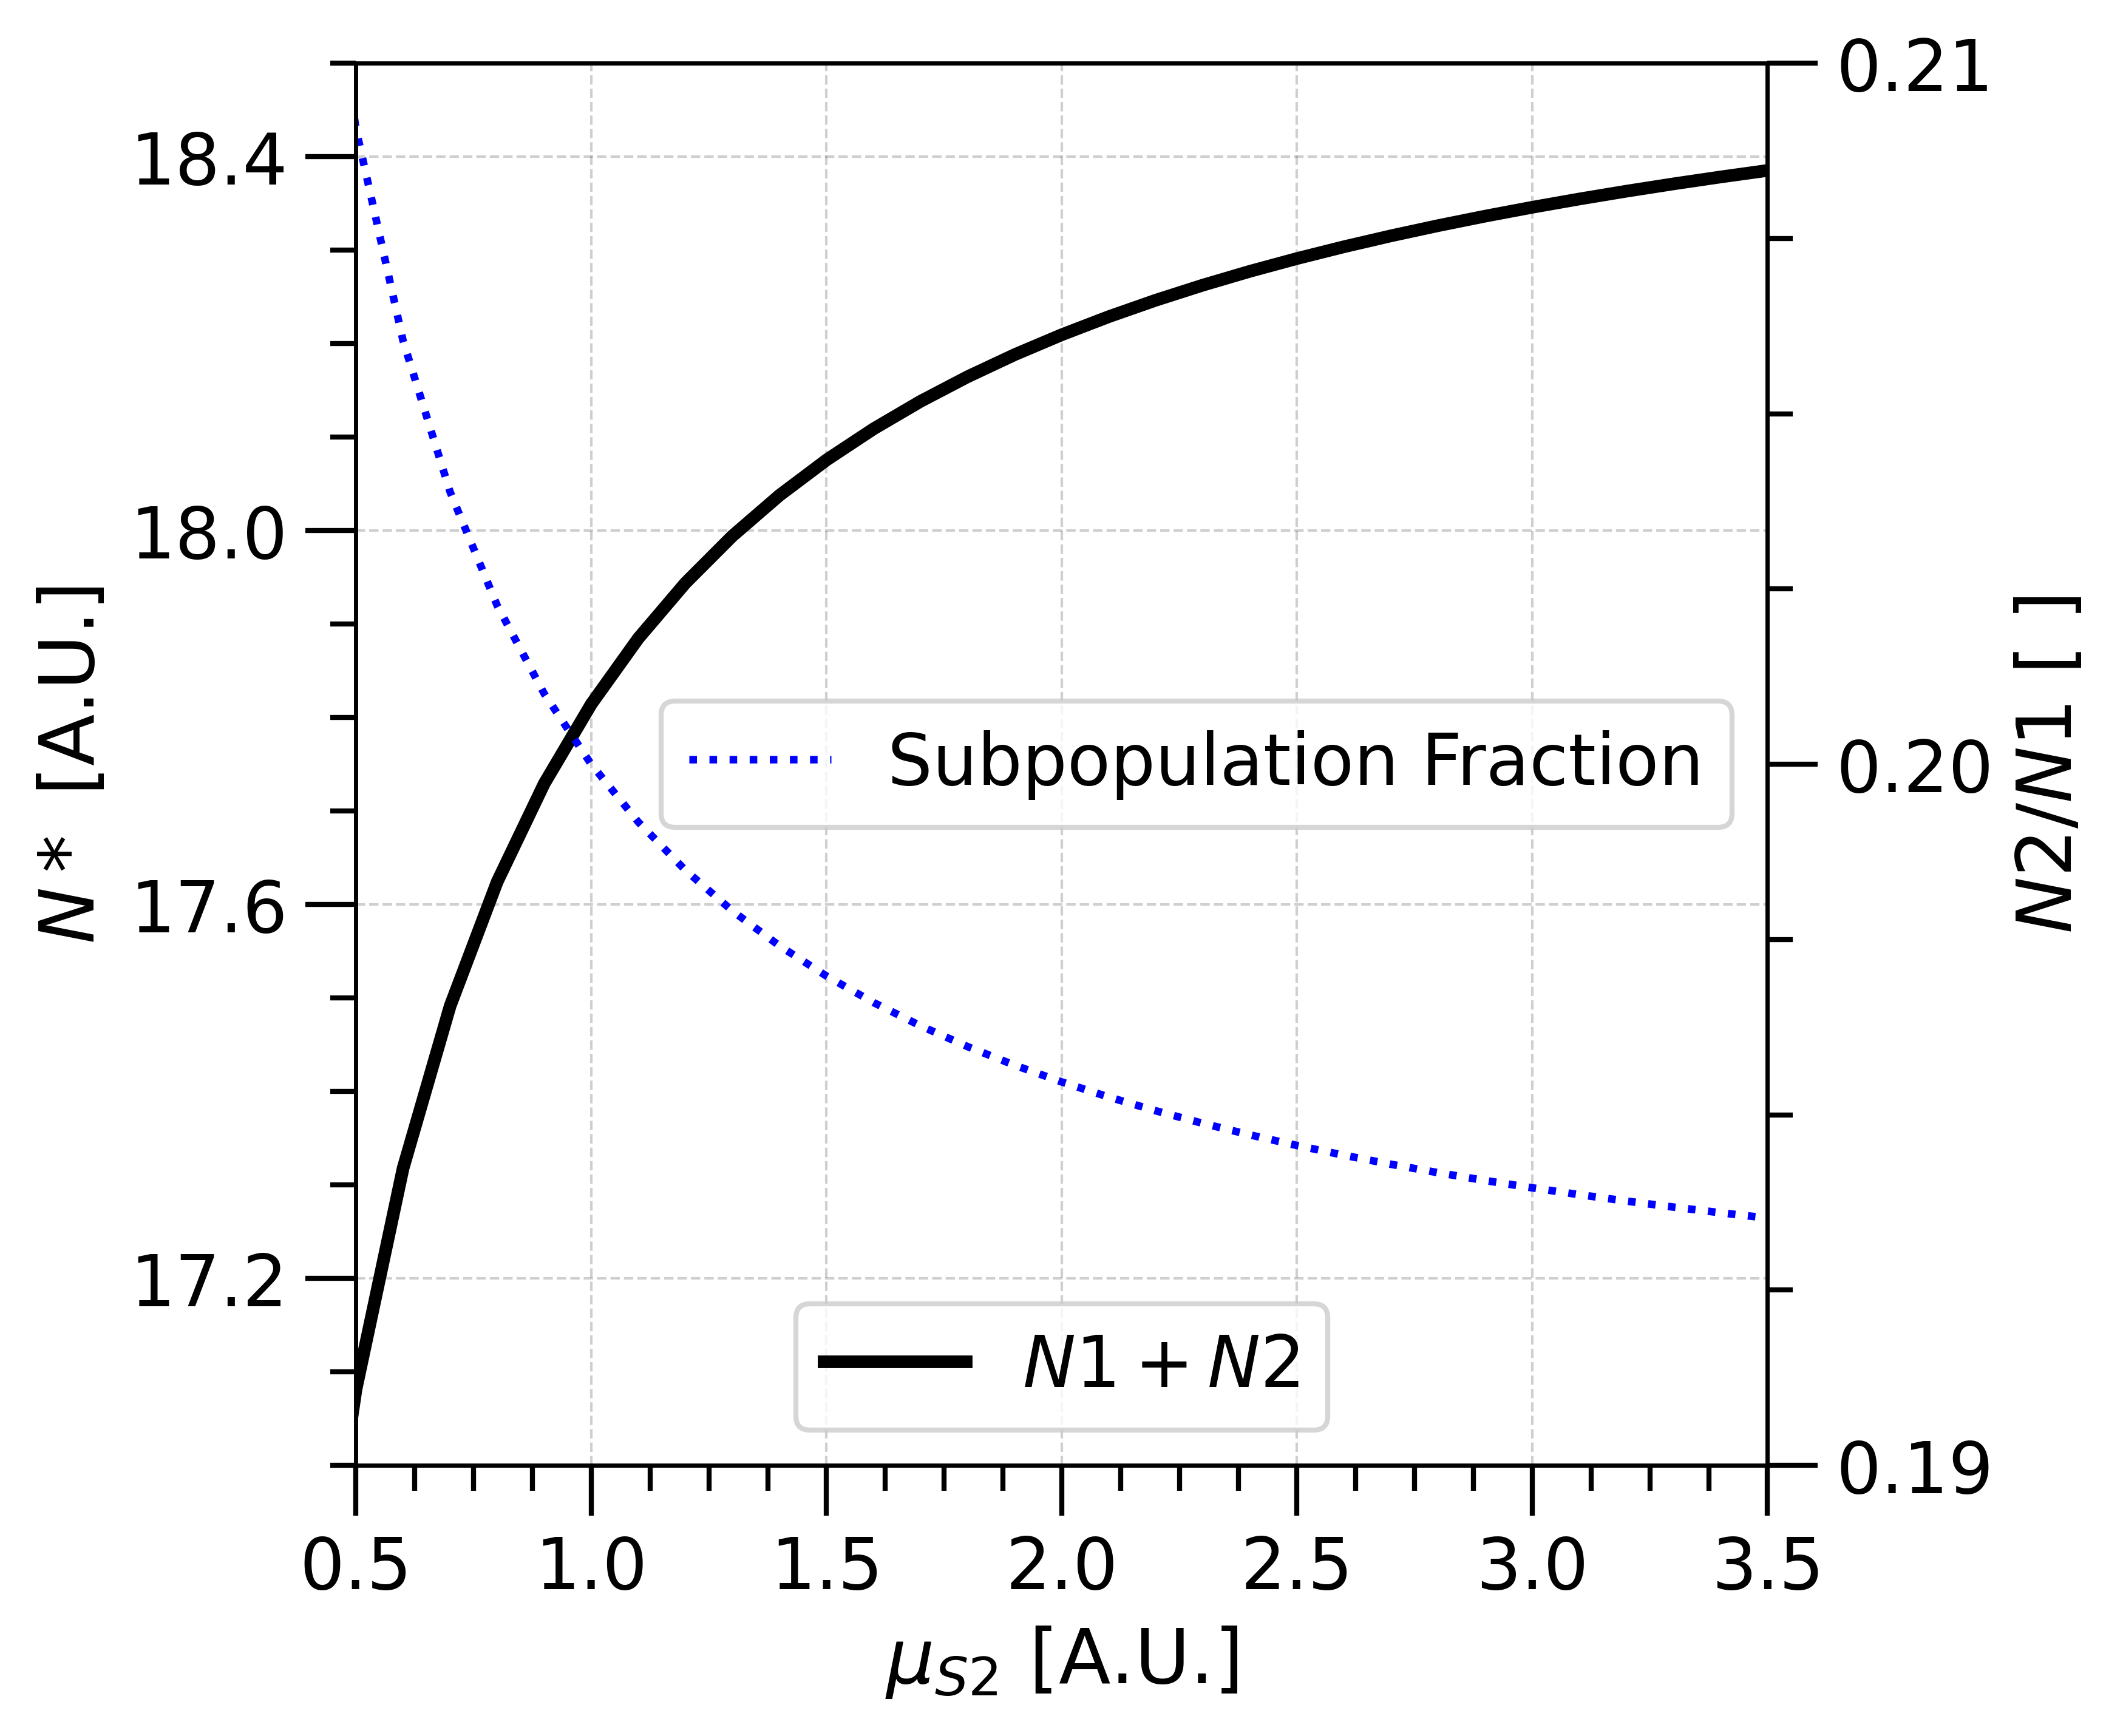

In [ ]:
fig13  = plt.figure(figsize=(5,5), dpi=600)

ax1  = fig13.add_subplot()
# ax1  = fig.add_axes([1, 1, 1, 1], aspect=2)

ax1.set_xlim(0.5, 3.5)
ax1.set_ylim(17, 18.5)

ax1.xaxis.set_major_locator(MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(AutoMinorLocator(4))

ax1.yaxis.set_major_locator(MultipleLocator(.4))
ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

ax1.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax1.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax1.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)

ax1.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

ax1.plot(mu_range, fulled_series, label='$N1 + N2$', color = 'k', linewidth=2.5)


ax1.set_xlabel('$μ_{S2} \ $[A.U.]', fontsize = 15)
ax1.set_ylabel('$N*$ [A.U.]', fontsize = 15)
ax1.legend(loc=8, fontsize=14)

ax2 = ax1.twinx()

ax2.set_xlim(0.5, 3.5)
ax2.set_ylim(0.19, 0.21)

ax2.xaxis.set_major_locator(MultipleLocator(0.5))
ax2.xaxis.set_minor_locator(AutoMinorLocator(4))


ax2.yaxis.set_major_locator(MultipleLocator(.01))
ax2.yaxis.set_minor_locator(AutoMinorLocator(4))

ax2.yaxis.set_major_formatter("{x:.2f}") # value with 2 decimal places ("2 floats")
# ax2.yaxis.set_minor_formatter("{x:.4f}") # value with 4 decimal places ("4 floats")


ax2.tick_params(axis='x', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax2.tick_params(axis='x', which='minor', width=1.0, length=5., labelsize=10, labelrotation=00)
ax2.tick_params(axis='y', which='major', width=1.0, length=10, labelsize=14, labelrotation=00)
ax2.tick_params(axis='y', which='minor', width=1.0, length=5., labelsize=5, labelrotation=00)

# ax2.grid(axis= 'both', which = 'major', linestyle="--", linewidth=0.5, color='.25', zorder=-10, alpha = 0.25)

ax2.plot(mu_range, dotted_series, label='Subpopulation Fraction', color = 'blue', linestyle=':')

ax2.legend(loc=5, fontsize=14)

ax2.set_ylabel(r'$N2/N1$ [ ]', fontsize=15)

plt.show()

## Fig. 13C

## Fig. 13D

## Fig. 13E

## Fig. 13F